# setup


In [1]:
%%capture
!pip install prophet

## load s&co data

In [2]:
# use v1.2 datasets; load from our repo for convenience
csv_urls = {
    'members': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/source_data/SCoData_members_v1.2_2022-01.csv',
    'books': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/source_data/SCoData_books_v1.2_2022-01.csv',
    'events': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/source_data/SCoData_events_v1.2_2022-01.csv',
    # project-specific data
    'partial_borrowers': 'https://github.com/ZoeLeBlanc/unknown_borrowers/raw/main/dataset_generator/data/partial_borrowers_collapsed.csv',
    'borrow_overrides': 'https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/dataset_generator/data/long_borrow_overrides.csv'
}

In [3]:
import pandas as pd

# load events
events_df = pd.read_csv(csv_urls['events'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## prepare logbook event data

In [4]:
# identify to logbook events

logbook_events_df = events_df[events_df.source_type.str.contains('Logbook')][[
   'event_type', 'start_date', 'end_date', 'subscription_purchase_date',
   'member_uris', 'member_names',
   'subscription_duration', 'subscription_duration_days',
   'subscription_volumes', 'subscription_category',
   'source_type'
]]
# .dropna(subset=['start_date'])

logbook_events_df['start_date'] = pd.to_datetime(logbook_events_df['start_date'])
logbook_events_df['subscription_purchase_date'] = pd.to_datetime(logbook_events_df['subscription_purchase_date'])


In [5]:
logbook_events_df.event_type.value_counts()

Renewal             4398
Subscription        4168
Reimbursement       2762
Supplement           190
Separate Payment      83
Name: event_type, dtype: int64

In [6]:
logbook_events_df.source_type.value_counts()

Logbook                                              8324
Logbook;Address Book                                 2079
Logbook;Lending Library Card                         1077
Lending Library Card;Logbook                           59
Logbook;Lending Library Card;Address Book              54
Logbook;Lending Library Card;Lending Library Card       5
Logbook;Address Book;Lending Library Card               2
Lending Library Card;Logbook;Address Book               1
Name: source_type, dtype: int64

In [7]:
# set logbook date; for subscriptions, the date recorded in the logbook is purchase date instead of start date
logbook_events_df['logbook_date'] = logbook_events_df.apply(lambda row: row.subscription_purchase_date if pd.notna(row.subscription_purchase_date) else row.start_date, axis=1)
logbook_events_df.dropna(subset=['logbook_date'])
logbook_events_df

event_type start_date    end_date subscription_purchase_date  \
17      Subscription 1925-01-01         NaN                 1925-01-01   
114     Subscription 1934-01-01         NaN                 1934-01-01   
433     Subscription 1930-05-01     1930-10                 1930-05-01   
671     Subscription 1919-11-17  1919-12-17                 1919-11-17   
672     Subscription 1919-11-18  1919-12-18                 1919-11-18   
...              ...        ...         ...                        ...   
35115        Renewal 1941-11-24  1941-12-24                 1941-11-24   
35116        Renewal 1941-12-04  1942-01-04                 1941-12-04   
35117  Reimbursement 1941-12-04  1941-12-04                        NaT   
35118        Renewal 1941-12-08  1942-03-08                 1941-12-08   
35119        Renewal 1941-12-09  1942-01-09                 1941-12-09   

                                             member_uris  \
17     https://shakespeareandco.princeton.edu/members...   
114    https://shakespeareandco.princeton.edu/members...   
433    https://shakespeareandco.princeton.edu/members...   
671    https://shakespeareandco.princeton.edu/members...   
672    https://shakespeareandco.princeton.edu/members...   
...                                                  ...   
35115  https://shakespeareandco.princeton.edu/members...   
35116  https://shakespeareandco.princeton.edu/members...   
35117  https://shakespeareandco.princeton.edu/members...   
35118  https://shakespeareandco.princeton.edu/members...   
35119  https://shakespeareandco.princeton.edu/members...   

                                    member_names subscription_duration  \
17     Mary Arnold Childs / Mrs. Ludwig Lewisohn                   NaN   
114                                 Mrs. Cayford                   NaN   
433                                    Sue Moody                   NaN   
671             Claude Cahun / Mlle Lucie Schwob               1 month   
672                                Henri Regnier               1 month   
...                                          ...                   ...   
35115                                  Mme Domer               1 month   
35116                                    Quesney               1 month   
35117                                    Quesney                   NaN   
35118                               Mlle Renauld              3 months   
35119                                   Kohlberg               1 month   

       subscription_duration_days  subscription_volumes subscription_category  \
17                            NaN                   NaN                   NaN   
114                           NaN                   NaN                   NaN   
433                           NaN                   NaN                   NaN   
671                          30.0                   1.0                   NaN   
672                          30.0                   1.0               Student   
...                           ...                   ...                   ...   
35115                        30.0                   1.0                   NaN   
35116                        31.0                   1.0                   NaN   
35117                         NaN                   NaN                   NaN   
35118                        90.0                   2.0                     A   
35119                        31.0                   1.0                 Other   

                        source_type logbook_date  
17                          Logbook   1925-01-01  
114                         Logbook   1934-01-01  
433            Logbook;Address Book   1930-05-01  
671    Lending Library Card;Logbook   1919-11-17  
672    Logbook;Lending Library Card   1919-11-18  
...                             ...          ...  
35115                       Logbook   1941-11-24  
35116                       Logbook   1941-12-04  
35117                       Logbook   1941-12-04  
35118                       

In [8]:
# check non-logbook membership events
membership_events = events_df[events_df.event_type.isin(['Renewal', 'Subscription', 'Reimbursement' ,'Supplement', 'Separate Payment'])]
nonlogbook_membership_events = membership_events[~membership_events.source_type.str.contains('Logbook')]
nonlogbook_membership_events

event_type start_date end_date  \
1       Subscription       1921      NaN   
4       Subscription       1922      NaN   
6       Subscription       1923     1923   
7       Subscription       1923      NaN   
9       Subscription       1923      NaN   
...              ...        ...      ...   
35512  Reimbursement        NaN      NaN   
35517  Reimbursement        NaN      NaN   
35518  Reimbursement        NaN      NaN   
35520  Reimbursement        NaN      NaN   
35522  Reimbursement        NaN      NaN   

                                             member_uris        member_names  \
1      https://shakespeareandco.princeton.edu/members...         Mme Garreta   
4      https://shakespeareandco.princeton.edu/members...         Mr. Lincoln   
6      https://shakespeareandco.princeton.edu/members...      S. Q. Millward   
7      https://shakespeareandco.princeton.edu/members...       Mr. Foulquier   
9      https://shakespeareandco.princeton.edu/members...      Mrs. Hefferson   
...                                                  ...                 ...   
35512  https://shakespeareandco.princeton.edu/members...  Mrs. N. F. Connont   
35517  https://shakespeareandco.princeton.edu/members...       Austin Clarke   
35518  https://shakespeareandco.princeton.edu/members...       Henri Gutmann   
35520  https://shakespeareandco.princeton.edu/members...         Mr. Baldwin   
35522  https://shakespeareandco.princeton.edu/members...        M. A. Davies   

         member_sort_names  subscription_price_paid  subscription_deposit  \
1             Garreta, Mme                      NaN                   NaN   
4             Lincoln, Mr.                      NaN                   7.0   
6          Millward, S. Q.                      NaN                   NaN   
7           Foulquier, Mr.                      NaN                   NaN   
9          Hefferson, Mrs.                      NaN                   NaN   
...                    ...                      ...                   ...   
35512  Connont, Mrs. N. F.                      NaN                   NaN   
35517       Clarke, Austin                      NaN                   NaN   
35518       Gutmann, Henri                      NaN                   NaN   
35520         Baldwin, Mr.                      NaN                   NaN   
35522        Davies, M. A.                      NaN                   NaN   

      subscription_duration  subscription_duration_days  ...  item_uri  \
1                       NaN                         NaN  ...       NaN   
4                       NaN                         NaN  ...       NaN   
6                       NaN                         NaN  ...       NaN   
7                       NaN                         NaN  ...       NaN   
9                       NaN                         NaN  ...       NaN   
...                     ...                         ...  ...       ...   
35512                   NaN                         NaN  ...       NaN   
35517                   NaN                         NaN  ...       NaN   
35518                   NaN                         NaN  ...       NaN   
35520                   NaN                         NaN  ...       NaN   
35522                   NaN                         NaN  ...       NaN   

      item_title item_volume  item_authors item_year  item_notes  \
1            NaN         NaN           NaN       NaN         NaN   
4            NaN         NaN           NaN       NaN         NaN   
6            NaN         NaN           NaN       NaN         NaN   
7            NaN         NaN           NaN       NaN         NaN   
9            NaN         NaN           NaN       NaN         NaN   
...          ...         ...           ...       ...         ...   
35512        NaN         NaN           NaN       NaN         NaN   
35517        NaN         NaN           NaN       NaN         NaN   
35518        NaN         NaN           NaN       NaN         NaN   
35520        NaN         N

In [9]:
membership_events.event_type.value_counts()

Subscription        4839
Renewal             4799
Reimbursement       3126
Supplement           190
Separate Payment      85
Name: event_type, dtype: int64

## calculate logbook gaps

In [10]:
import requests

response = requests.get('https://raw.githubusercontent.com/ZoeLeBlanc/unknown_borrowers/main/missing-data-estimates/logbook-dates.json')
logbook_dates = response.json()
# these are the dates that are *covered* by the logbooks we have
logbook_dates

[{'endDate': '1923-12-31', 'startDate': '1919-11-17'},
 {'endDate': '1927-10-29', 'startDate': '1924-01-02'},
 {'endDate': '1927-12-31', 'startDate': '1927-11-02'},
 {'endDate': '1928-04-30', 'startDate': '1928-03-01'},
 {'endDate': '1928-12-31', 'startDate': '1928-05-01'},
 {'endDate': '1929-11-30', 'startDate': '1929-01-02'},
 {'endDate': '1930-01-02', 'startDate': '1929-12-02'},
 {'endDate': '1930-07-31', 'startDate': '1930-06-02'},
 {'endDate': '1931-02-16', 'startDate': '1931-01-01'},
 {'endDate': '1934-02-06', 'startDate': '1932-09-26'},
 {'endDate': '1934-12-31', 'startDate': '1934-02-09'},
 {'endDate': '1935-12-28', 'startDate': '1935-01-12'},
 {'endDate': '1936-12-31', 'startDate': '1936-01-02'},
 {'endDate': '1938-05-05', 'startDate': '1938-02-17'},
 {'endDate': '1939-08-28', 'startDate': '1938-10-21'},
 {'endDate': '1941-12-12', 'startDate': '1939-09-13'}]

In [11]:
from datetime import timedelta

# adapted from KM's notebook

logbook_gaps = []
skipped_gaps = []

oneday = timedelta(days=1)


for i in range(len(logbook_dates) - 1):
  # gaps are between the logbook dates, so gap start is end of the first
  # and gap end is the start of the next

  # NOTE: adjusted from KM implementation: k
  # gap start and end dates are now included in the range instead of bounds outside the range
  gap_start = pd.to_datetime(logbook_dates[i]['endDate']) + oneday
  gap_end = pd.to_datetime(logbook_dates[i+1]['startDate']) - oneday
  interval = { 'start': gap_start, 'end': gap_end, 'days': (gap_end - gap_start).days }

  if interval['days'] > 12:
      logbook_gaps.append(interval) 
  elif interval['days'] > 0:  # ignore 0 and -1 duration "gaps"!
     skipped_gaps.append(interval)


print(f"The {len(logbook_gaps)} large gaps in the logbooks")
for interval in logbook_gaps:
    print(f"\t{interval['start'].strftime('%B %d %Y')} to {interval['end'].strftime('%B %d %Y')} ({interval['days']} days)")

print(f"\nThe {len(skipped_gaps)} small gaps in the logbooks that will be skipped")
for interval in skipped_gaps:
    print(f"\t{interval['start'].strftime('%B %d %Y')} to {interval['end'].strftime('%B %d %Y')} ({interval['days']} day{'s' if interval['days'] != 1 else ''})")

The 7 large gaps in the logbooks
	January 01 1928 to February 29 1928 (59 days)
	January 03 1930 to June 01 1930 (149 days)
	August 01 1930 to December 31 1930 (152 days)
	February 17 1931 to September 25 1932 (586 days)
	January 01 1937 to February 16 1938 (411 days)
	May 06 1938 to October 20 1938 (167 days)
	August 29 1939 to September 12 1939 (14 days)

The 4 small gaps in the logbooks that will be skipped
	October 30 1927 to November 01 1927 (2 days)
	February 07 1934 to February 08 1934 (1 day)
	January 01 1935 to January 11 1935 (10 days)
	December 29 1935 to January 01 1936 (3 days)


In [12]:
# how many days total in the logbook gaps, the way I calculate them?
sum(gap['days'] for gap in logbook_gaps)

1538

In [13]:
1.3 * 1538

1999.4

In [14]:
# get logbook event data *except* for during gaps
# — v1.2 dataset has 9 stray events in these gaps; 8 misattributed to logbook source, one documented in a later logbook

logbook_events_nogaps = logbook_events_df.copy()

for i, gap in enumerate(logbook_gaps):
  gap_start = gap['start']
  gap_end = gap['end']
  logbook_events_nogaps = logbook_events_nogaps[~((logbook_events_nogaps.logbook_date >= gap_start) & (logbook_events_nogaps.logbook_date <= gap_end))]

logbook_events_nogaps

event_type start_date    end_date subscription_purchase_date  \
17      Subscription 1925-01-01         NaN                 1925-01-01   
114     Subscription 1934-01-01         NaN                 1934-01-01   
671     Subscription 1919-11-17  1919-12-17                 1919-11-17   
672     Subscription 1919-11-18  1919-12-18                 1919-11-18   
676     Subscription 1919-11-18  1919-12-18                 1919-11-18   
...              ...        ...         ...                        ...   
35115        Renewal 1941-11-24  1941-12-24                 1941-11-24   
35116        Renewal 1941-12-04  1942-01-04                 1941-12-04   
35117  Reimbursement 1941-12-04  1941-12-04                        NaT   
35118        Renewal 1941-12-08  1942-03-08                 1941-12-08   
35119        Renewal 1941-12-09  1942-01-09                 1941-12-09   

                                             member_uris  \
17     https://shakespeareandco.princeton.edu/members...   
114    https://shakespeareandco.princeton.edu/members...   
671    https://shakespeareandco.princeton.edu/members...   
672    https://shakespeareandco.princeton.edu/members...   
676    https://shakespeareandco.princeton.edu/members...   
...                                                  ...   
35115  https://shakespeareandco.princeton.edu/members...   
35116  https://shakespeareandco.princeton.edu/members...   
35117  https://shakespeareandco.princeton.edu/members...   
35118  https://shakespeareandco.princeton.edu/members...   
35119  https://shakespeareandco.princeton.edu/members...   

                                    member_names subscription_duration  \
17     Mary Arnold Childs / Mrs. Ludwig Lewisohn                   NaN   
114                                 Mrs. Cayford                   NaN   
671             Claude Cahun / Mlle Lucie Schwob               1 month   
672                                Henri Regnier               1 month   
676                                Denise Ulmann               1 month   
...                                          ...                   ...   
35115                                  Mme Domer               1 month   
35116                                    Quesney               1 month   
35117                                    Quesney                   NaN   
35118                               Mlle Renauld              3 months   
35119                                   Kohlberg               1 month   

       subscription_duration_days  subscription_volumes subscription_category  \
17                            NaN                   NaN                   NaN   
114                           NaN                   NaN                   NaN   
671                          30.0                   1.0                   NaN   
672                          30.0                   1.0               Student   
676                          30.0                   2.0               Student   
...                           ...                   ...                   ...   
35115                        30.0                   1.0                   NaN   
35116                        31.0                   1.0                   NaN   
35117                         NaN                   NaN                   NaN   
35118                        90.0                   2.0                     A   
35119                        31.0                   1.0                 Other   

                        source_type logbook_date  
17                          Logbook   1925-01-01  
114                         Logbook   1934-01-01  
671    Lending Library Card;Logbook   1919-11-17  
672    Logbook;Lending Library Card   1919-11-18  
676    Logbook;Lending Library Card   1919-11-18  
...                             ...          ...  
35115                       Logbook   1941-11-24  
35116                       Logbook   1941-12-04  
35117                       Logbook   1941-12-04  
35118                       

# missing membership events

## logbook / membership events by week

In [15]:
logbooks_weekly_count = logbook_events_nogaps.groupby([pd.Grouper(key='logbook_date', freq='W')])['event_type'].count().reset_index()
logbooks_weekly_count.rename(columns={'event_type': 'total'}, inplace=True)
logbooks_weekly_count

logbook_date  total
0      1919-11-23     12
1      1919-11-30     12
2      1919-12-07     12
3      1919-12-14      6
4      1919-12-21      4
...           ...    ...
1186   1942-08-16      0
1187   1942-08-23      0
1188   1942-08-30      0
1189   1942-09-06      0
1190   1942-09-13      1

[1191 rows x 2 columns]

In [16]:
# plot logbooks with no gaps to check logic

import altair as alt


base = alt.Chart(logbooks_weekly_count).encode(
    alt.X('logbook_date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

line = base.mark_line().encode(
    alt.Y('total',
          axis=alt.Axis(title='total events per week'))
)
line

# sns.set(rc = {'figure.figsize':(20,8)})

# fig, ax = plt.subplots(figsize=(20, 5))
# sns.lineplot(data=logbook_events_nogaps_monthly, x='logbook_date', y='total')

# for gap in logbook_gaps:
#   ax.axvspan(pd.to_datetime(gap['start']), pd.to_datetime(gap['end']), color="gray", alpha=0.3)

alt.Chart(...)

In [17]:
logbook_gaps_df = pd.DataFrame(logbook_gaps)
logbook_gaps_df

start        end  days
0 1928-01-01 1928-02-29    59
1 1930-01-03 1930-06-01   149
2 1930-08-01 1930-12-31   152
3 1931-02-17 1932-09-25   586
4 1937-01-01 1938-02-16   411
5 1938-05-06 1938-10-20   167
6 1939-08-29 1939-09-12    14

In [18]:
# draw rectangles to highlight logbook gaps
logbook_gaps_span = alt.Chart(logbook_gaps_df).encode(
     alt.X('start')
).properties(
    width=1200,
    height=300
).mark_rect(
    opacity=0.2, color="gray"
).encode(
    x='start',
    x2='end',
    y=alt.value(0),  # 0 pixels from bottom
    y2=alt.value(275)  # 300 pixels from top
)


line + logbook_gaps_span

alt.LayerChart(...)

In [19]:
# todo / adapt code from previous logbook for missing membership forecast & estimations

# missing members

## member data setup

In [20]:
# split multiple members for shared accounts in events
events_df[
    ["first_member_uri", "second_member_uri"]
] = events_df.member_uris.str.split(";", expand=True)

# working with the first member for now...
# generate short ids equivalent to those in member and book dataframes
events_df["member_id"] = events_df.first_member_uri.apply(
    lambda x: x.split("/")[-2]
)
events_df["item_id"] = events_df.item_uri.apply(
    lambda x: x.split("/")[-2] if pd.notna(x) else None
)

In [21]:
# looking at all the data, what is the first event for each member?
member_dates = events_df.copy()

# make sure each event has an earliest known date
def earliest_date(row):
  dates = [val for val in [row.start_date, row.subscription_purchase_date, row.end_date] if not pd.isna(val)]
  if dates:
    return min(dates)     

member_dates['earliest_date'] = member_dates.apply(earliest_date, axis=1)
member_dates[['event_type', 'member_id', 'earliest_date', 'start_date', 'end_date' ,'subscription_purchase_date', 'source_type']]

event_type            member_id earliest_date start_date  \
0            Generic   linossier-raymonde          1920       1920   
1       Subscription              garreta          1921       1921   
2             Borrow                 rhys          1922       1922   
3            Generic                walsh          1922       1922   
4       Subscription            lincoln-1          1922       1922   
...              ...                  ...           ...        ...   
35518  Reimbursement        gutmann-henri          None        NaN   
35519        Generic  bernheim-antoinette          None        NaN   
35520  Reimbursement           baldwin-mr          None        NaN   
35521        Generic  bernheim-antoinette          None        NaN   
35522  Reimbursement           davies-m-a          None        NaN   

         end_date subscription_purchase_date           source_type  
0             NaN                        NaN  Lending Library Card  
1             NaN                       1921          Address Book  
2      1922-08-23                        NaN  Lending Library Card  
3             NaN                        NaN  Lending Library Card  
4             NaN                       1922          Address Book  
...           ...                        ...                   ...  
35518         NaN                        NaN          Address Book  
35519         NaN                        NaN  Lending Library Card  
35520         NaN                        NaN          Address Book  
35521         NaN                        NaN  Lending Library Card  
35522         NaN                        NaN          Address Book  

[35523 rows x 7 columns]

In [22]:
# convert earliest date to datetime; convert partially known dates to -01-01  for now
member_dates['date'] = pd.to_datetime(member_dates['earliest_date'], errors='coerce')
member_dates[['event_type', 'member_id', 'date', 'start_date', 'end_date' ,'subscription_purchase_date', 'source_type']]

event_type            member_id       date start_date    end_date  \
0            Generic   linossier-raymonde 1920-01-01       1920         NaN   
1       Subscription              garreta 1921-01-01       1921         NaN   
2             Borrow                 rhys 1922-01-01       1922  1922-08-23   
3            Generic                walsh 1922-01-01       1922         NaN   
4       Subscription            lincoln-1 1922-01-01       1922         NaN   
...              ...                  ...        ...        ...         ...   
35518  Reimbursement        gutmann-henri        NaT        NaN         NaN   
35519        Generic  bernheim-antoinette        NaT        NaN         NaN   
35520  Reimbursement           baldwin-mr        NaT        NaN         NaN   
35521        Generic  bernheim-antoinette        NaT        NaN         NaN   
35522  Reimbursement           davies-m-a        NaT        NaN         NaN   

      subscription_purchase_date           source_type  
0                            NaN  Lending Library Card  
1                           1921          Address Book  
2                            NaN  Lending Library Card  
3                            NaN  Lending Library Card  
4                           1922          Address Book  
...                          ...                   ...  
35518                        NaN          Address Book  
35519                        NaN  Lending Library Card  
35520                        NaN          Address Book  
35521                        NaN  Lending Library Card  
35522                        NaN          Address Book  

[35523 rows x 7 columns]

In [23]:
# limit to the fields we want, drop unknown dates
members_added = member_dates[['event_type', 'member_id', 'date', 'source_type']].dropna(subset=['date'])
members_added

event_type           member_id       date           source_type
0           Generic  linossier-raymonde 1920-01-01  Lending Library Card
1      Subscription             garreta 1921-01-01          Address Book
2            Borrow                rhys 1922-01-01  Lending Library Card
3           Generic               walsh 1922-01-01  Lending Library Card
4      Subscription           lincoln-1 1922-01-01          Address Book
...             ...                 ...        ...                   ...
35135       Generic              massey 1961-05-15  Lending Library Card
35136   Crossed out              massey 1961-05-15  Lending Library Card
35137       Generic              massey 1961-05-15  Lending Library Card
35138       Generic              massey 1961-05-15  Lending Library Card
35139       Generic               samyn 1962-03-21  Lending Library Card

[35069 rows x 4 columns]

In [24]:
# limit to official time period
from datetime import datetime

members_added = members_added[members_added['date'] < datetime(1942, 1, 1)]

In [25]:
# limit to member uri and date; then group by member and get the first date
members_grouped = members_added[["member_id", "date"]].groupby("member_id")
members_first_dates = members_grouped.first().reset_index()

# members_added = members_added[['member_id', 'date']].drop_duplicates()
# members_added.sort_values('member_id')
members_first_dates.sort_values("date")

member_id       date
725           cahun 1919-11-17
1599  flot-marcelle 1919-11-17
3879        regnier 1919-11-18
4680         ulmann 1919-11-18
2490       keller-m 1919-11-18
...             ...        ...
2607        lacorne 1941-12-05
160          azgema 1941-12-06
2573     kohlberg-8 1941-12-09
1827         godard 1941-12-09
1261   desraux-mlle 1941-12-22

[5085 rows x 2 columns]

In [26]:
newmember_yearly_count = members_first_dates.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
newmember_yearly_count.rename(columns={'member_id': 'total'}, inplace=True)
newmember_yearly_count

date  total
0  1919-12-31     40
1  1920-12-31    187
2  1921-12-31    265
3  1922-12-31    332
4  1923-12-31    286
5  1924-12-31    339
6  1925-12-31    411
7  1926-12-31    449
8  1927-12-31    335
9  1928-12-31    306
10 1929-12-31    316
11 1930-12-31     85
12 1931-12-31     98
13 1932-12-31    149
14 1933-12-31    243
15 1934-12-31    134
16 1935-12-31    201
17 1936-12-31    200
18 1937-12-31    110
19 1938-12-31    135
20 1939-12-31    172
21 1940-12-31    128
22 1941-12-31    164

In [27]:
newmember_base = alt.Chart(newmember_yearly_count, title='new members by year').encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

newmember_line = newmember_base.mark_line().encode(
    alt.Y('total',
          axis=alt.Axis(title='new members by year'))
)
newmember_line

alt.Chart(...)

In [28]:
newmember_line + logbook_gaps_span

alt.LayerChart(...)

In [29]:
# group again but report on source and event type;
# customize sorting to order so subscriptions will show up first
from pandas.api.types import CategoricalDtype

# main order we care about is subscription first; other order matters less; reimbursement would be expected last
event_type = CategoricalDtype(categories=["Subscription", "Renewal", "Separate Payment", "Borrow", "Purchase", "Supplement", "Request", "Gift", "Crossed out", "Reimbursement"], ordered=True)
# copy member data frame, and convert event type to our new categorical type
member_events = members_added.copy()

member_events['event_type'] = member_events.event_type.astype(event_type)

# sort by date, then sort by event type so if there are any same-day events,
# subscription should always be first
member_events = member_events.sort_values(by=['date', 'event_type'])

members_first_events = member_events.groupby("member_id").first().reset_index()

members_first_events

member_id     event_type       date                   source_type
0         Cahn-1   Subscription 1919-12-27                       Logbook
1     Clauebou-1   Subscription 1941-11-26                       Logbook
2         Edward        Renewal 1941-01-22                       Logbook
3          Tyson  Reimbursement 1938-03-15                       Logbook
4         abbott   Subscription 1925-04-21          Logbook;Address Book
...          ...            ...        ...                           ...
5080      zimmer   Subscription 1920-01-16  Logbook;Lending Library Card
5081      zogheb         Borrow 1940-01-05          Lending Library Card
5082    zongenth   Subscription 1926-11-03                       Logbook
5083     zueblin   Subscription 1922-10-18                       Logbook
5084  zweigsmith        Renewal 1926-12-10                       Logbook

[5085 rows x 4 columns]

In [30]:
# confirm the number of rows in the df == the number of unique members included
len(members_first_events.member_id.unique())

5085

In [31]:
# what is the breakdown of event types for first events?
members_first_events.event_type.value_counts()

Subscription        4189
Renewal              550
Reimbursement        208
Borrow                91
Purchase              18
Separate Payment      12
Supplement            10
Gift                   3
Crossed out            1
Request                0
Name: event_type, dtype: int64

In [32]:
# what about source of first events
members_first_events.source_type.value_counts()

Logbook                                      2744
Logbook;Address Book                         1375
Address Book                                  445
Logbook;Lending Library Card                  242
Lending Library Card                          220
Lending Library Card;Address Book              22
Logbook;Lending Library Card;Address Book      19
Lending Library Card;Logbook                   15
Lending Library Card;Lending Library Card       2
Lending Library Card;Logbook;Address Book       1
Name: source_type, dtype: int64

### new members added, logbooks only

In [33]:
# get first events for each member from logbooks only

# go back to member events, limit to logbook events, then group and get first event
logbook_first_events = member_events[member_events.source_type.str.contains('Logbook')].groupby("member_id").first().reset_index()
logbook_first_events

member_id     event_type       date                   source_type
0         Cahn-1   Subscription 1919-12-27                       Logbook
1     Clauebou-1   Subscription 1941-11-26                       Logbook
2         Edward        Renewal 1941-01-22                       Logbook
3          Tyson  Reimbursement 1938-03-15                       Logbook
4         abbott   Subscription 1925-04-21          Logbook;Address Book
...          ...            ...        ...                           ...
4592      zimmer   Subscription 1920-01-16  Logbook;Lending Library Card
4593      zogheb   Subscription 1940-01-31  Logbook;Lending Library Card
4594    zongenth   Subscription 1926-11-03                       Logbook
4595     zueblin   Subscription 1922-10-18                       Logbook
4596  zweigsmith        Renewal 1926-12-10                       Logbook

[4597 rows x 4 columns]

In [34]:
# confirm one row per member
len(logbook_first_events.member_id.unique())

4597

In [35]:
# check source type breakdown
logbook_first_events.source_type.value_counts()

Logbook                                              2828
Logbook;Address Book                                 1412
Logbook;Lending Library Card                          309
Logbook;Lending Library Card;Address Book              25
Lending Library Card;Logbook                           20
Logbook;Lending Library Card;Lending Library Card       1
Logbook;Address Book;Lending Library Card               1
Lending Library Card;Logbook;Address Book               1
Name: source_type, dtype: int64

In [36]:
# get new member yearly count for logbook-sourced events only 
logbook_newmembers_by_year = logbook_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
logbook_newmembers_by_year.rename(columns={'member_id': 'total'}, inplace=True)
logbook_newmembers_by_year

date  total
0  1919-12-31     53
1  1920-12-31    193
2  1921-12-31    278
3  1922-12-31    322
4  1923-12-31    280
5  1924-12-31    325
6  1925-12-31    404
7  1926-12-31    436
8  1927-12-31    296
9  1928-12-31    289
10 1929-12-31    283
11 1930-12-31     33
12 1931-12-31     22
13 1932-12-31     78
14 1933-12-31    240
15 1934-12-31    105
16 1935-12-31    212
17 1936-12-31    183
18 1937-12-31      1
19 1938-12-31    112
20 1939-12-31    173
21 1940-12-31    125
22 1941-12-31    154

In [37]:
logbook_newmember_base = alt.Chart(logbook_newmembers_by_year, title='new members by year').encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

logbook_newmember_line = logbook_newmember_base.mark_line(color="purple").encode(
    alt.Y('total',
          axis=alt.Axis(title='new members by year'))
)
newmember_line + logbook_newmember_line

alt.LayerChart(...)

### aggregate by month instead of year

confusing because totals and graphs in the dataset essay are monthly, it looks wrong

In [38]:
# get new member monthly count for logbook-sourced events only 
logbook_newmembers_by_month = logbook_first_events.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
logbook_newmembers_by_month.rename(columns={'member_id': 'total'}, inplace=True)
logbook_newmembers_by_month

date  total
0   1919-11-30     23
1   1919-12-31     30
2   1920-01-31     28
3   1920-02-29     19
4   1920-03-31     20
..         ...    ...
261 1941-08-31      1
262 1941-09-30     17
263 1941-10-31     26
264 1941-11-30     21
265 1941-12-31      6

[266 rows x 2 columns]

In [39]:
logbook_newmember_monthly_base = alt.Chart(logbook_newmembers_by_month, title='new members by month').encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

logbook_newmember_monthly_line = logbook_newmember_monthly_base.mark_line(color="purple", opacity=0.5).encode(
    alt.Y('total',
          axis=alt.Axis(title='new members by month'))
)
logbook_newmember_monthly_line

alt.Chart(...)

In [40]:
newmember_monthly_count = members_first_dates.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
newmember_monthly_count.rename(columns={'member_id': 'total'}, inplace=True)
newmember_monthly_count

date  total
0   1919-11-30     17
1   1919-12-31     23
2   1920-01-31     25
3   1920-02-29     18
4   1920-03-31     23
..         ...    ...
261 1941-08-31      1
262 1941-09-30     18
263 1941-10-31     25
264 1941-11-30     23
265 1941-12-31      6

[266 rows x 2 columns]

In [41]:
newmember_monthly_base = alt.Chart(newmember_monthly_count, title='new members by month').encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

newmember_monthly_line = newmember_monthly_base.mark_line(opacity=0.5).encode(
    alt.Y('total',
          axis=alt.Axis(title='new members by month'))
)
newmember_monthly_line

alt.Chart(...)

In [42]:
logbook_newmember_monthly_line + newmember_monthly_line

alt.LayerChart(...)

### members only documented in address books

In [43]:
# what about members we _only_ know about from the address books?

# any member with at least one event in the logbooks
logbook_members = member_events[member_events.source_type.str.contains('Logbook')].member_id.unique()
# any member with at least one event on a card
lending_card_members = member_events[member_events.source_type.str.contains('Lending Library Card')].member_id.unique()
# any member with at least one event from an address book
addressbook_members = member_events[member_events.source_type.str.contains('Address Book')].member_id.unique()

# get a list of address-book-only members 
address_book_only_members = set(member_events.member_id.unique()) - set(logbook_members) - set(lending_card_members)
print('%d members who only have events from the address books' % len(address_book_only_members))


329 members who only have events from the address books


In [44]:
# check logic
member_events[member_events.member_id.isin(address_book_only_members)]

event_type          member_id       date   source_type
216     Subscription             boue-l 1920-03-01  Address Book
224     Subscription      dunlap-sheila 1920-10-01  Address Book
228     Subscription   grant-mrs-robert 1921-01-01  Address Book
233     Subscription          madam-g-s 1921-07-01  Address Book
4       Subscription          lincoln-1 1922-01-01  Address Book
...              ...                ...        ...           ...
20967   Subscription      stavis-barrie 1937-07-03  Address Book
20997   Subscription    baumel-germaine 1937-07-07  Address Book
21000   Subscription   ruellan-severine 1937-07-08  Address Book
21001   Subscription    matthews-sylvia 1937-07-08  Address Book
21004  Reimbursement  karwoski-theodore 1937-07-08  Address Book

[365 rows x 4 columns]

In [45]:
member_events[member_events.member_id.isin(address_book_only_members)].source_type.describe()

count              365
unique               1
top       Address Book
freq               365
Name: source_type, dtype: object

In [46]:
# get date added for address-only members

addressbook_first_events = member_events[member_events.member_id.isin(address_book_only_members)].groupby("member_id").first().reset_index()
addressbook_first_events

member_id    event_type       date   source_type
0     abbott-berenice  Subscription 1926-09-01  Address Book
1            abrahams  Subscription 1937-06-29  Address Book
2              abrami  Subscription 1937-02-05  Address Book
3        agard-walter  Subscription 1932-01-01  Address Book
4    aguilar-anina-de  Subscription 1931-01-01  Address Book
..                ...           ...        ...           ...
324    venturi-franco  Subscription 1937-01-12  Address Book
325   wallace-michael  Subscription 1937-04-02  Address Book
326             wicks  Subscription 1937-04-08  Address Book
327           young-g  Subscription 1937-05-10  Address Book
328     yvonne-abelin  Subscription 1933-11-25  Address Book

[329 rows x 4 columns]

In [47]:
# get new member yearly count for addressbook-only members events only 
addressbook_newmembers_by_year = addressbook_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
addressbook_newmembers_by_year.rename(columns={'member_id': 'total'}, inplace=True)
addressbook_newmembers_by_year

date  total
0  1920-12-31      2
1  1921-12-31      2
2  1922-12-31      9
3  1923-12-31      8
4  1924-12-31      8
5  1925-12-31      7
6  1926-12-31     13
7  1927-12-31     17
8  1928-12-31     16
9  1929-12-31     18
10 1930-12-31     36
11 1931-12-31     50
12 1932-12-31     57
13 1933-12-31      3
14 1934-12-31      9
15 1935-12-31      1
16 1936-12-31     10
17 1937-12-31     63

In [48]:
addressbook_newmembers_by_year.total.sum()

329

### members only documented on lending cards

In [49]:
# do we have any lending-card only members?

# get a list of address-book-only members 
lending_card_only_members = set(member_events.member_id.unique()) - set(logbook_members) - set(addressbook_members)
print('%d members who only have events from lending library cards' % len(lending_card_only_members))


124 members who only have events from lending library cards


In [50]:
# check logic
member_events[member_events.member_id.isin(lending_card_only_members)]

event_type        member_id       date           source_type
705       Borrow           winger 1919-12-02  Lending Library Card
706       Borrow           winger 1919-12-02  Lending Library Card
751       Borrow           winger 1920-01-05  Lending Library Card
752       Borrow           winger 1920-01-05  Lending Library Card
774       Borrow           winger 1920-01-16  Lending Library Card
...          ...              ...        ...                   ...
29423     Borrow  woodward-daphne 1941-12-08  Lending Library Card
29445     Borrow  valery-francois 1941-12-12  Lending Library Card
29451     Borrow  valery-francois 1941-12-12  Lending Library Card
29459     Borrow  valery-francois 1941-12-12  Lending Library Card
29460     Borrow  valery-francois 1941-12-12  Lending Library Card

[2179 rows x 4 columns]

In [51]:
cardonly_members = member_events[member_events.member_id.isin(lending_card_only_members)]
cardonly_members['year'] = cardonly_members.date.apply(lambda x: x.year)
cardonly_members.year.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([1919, 1920, 1922, 1923, 1924, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941])

In [52]:
# card-only member first events
cardonly_first_events = member_events[member_events.member_id.isin(lending_card_only_members)].groupby("member_id").first().reset_index()
cardonly_first_events

member_id    event_type       date           source_type
0                 beach-family          Gift 1930-12-01  Lending Library Card
1              benjamin-walter        Borrow 1940-02-23  Lending Library Card
2          bernheim-antoinette        Borrow 1934-10-23  Lending Library Card
3    bertrand-fontaine-therese        Borrow 1938-01-01  Lending Library Card
4                         bird           NaN 1933-03-29  Lending Library Card
..                         ...           ...        ...                   ...
119    williamson-scott-graham        Borrow 1934-09-24  Lending Library Card
120                     winger        Borrow 1919-12-02  Lending Library Card
121                  wissotzky  Subscription 1937-11-04  Lending Library Card
122            woodward-daphne        Borrow 1940-08-28  Lending Library Card
123               ybarra-penny        Borrow 1936-01-15  Lending Library Card

[124 rows x 4 columns]

In [53]:
# get new member yearly count for lending card-only members
cardonly_newmembers_by_year = cardonly_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
cardonly_newmembers_by_year.rename(columns={'member_id': 'total'}, inplace=True)
cardonly_newmembers_by_year

date  total
0  1919-12-31      1
1  1920-12-31      1
2  1921-12-31      0
3  1922-12-31      3
4  1923-12-31      1
5  1924-12-31      0
6  1925-12-31      2
7  1926-12-31      0
8  1927-12-31      4
9  1928-12-31      5
10 1929-12-31      3
11 1930-12-31      7
12 1931-12-31     14
13 1932-12-31     11
14 1933-12-31      4
15 1934-12-31     11
16 1935-12-31      5
17 1936-12-31      5
18 1937-12-31     12
19 1938-12-31     20
20 1939-12-31      5
21 1940-12-31      6
22 1941-12-31      4

### other members

In [54]:
# get all other members so we can generate stacked area chart properly

other_members = set(member_events.member_id.unique()) - set(lending_card_only_members) - set(address_book_only_members)
print('%d "regular" members (not addressbook or lending card only)' % len(other_members))
 

4632 "regular" members (not addressbook or lending card only)


In [55]:
# other member first events
other_member_first_events = member_events[member_events.member_id.isin(other_members)].groupby("member_id").first().reset_index()
other_member_first_events

member_id     event_type       date                   source_type
0         Cahn-1   Subscription 1919-12-27                       Logbook
1     Clauebou-1   Subscription 1941-11-26                       Logbook
2         Edward        Renewal 1941-01-22                       Logbook
3          Tyson  Reimbursement 1938-03-15                       Logbook
4         abbott   Subscription 1925-04-21          Logbook;Address Book
...          ...            ...        ...                           ...
4627      zimmer   Subscription 1920-01-16  Logbook;Lending Library Card
4628      zogheb         Borrow 1940-01-05          Lending Library Card
4629    zongenth   Subscription 1926-11-03                       Logbook
4630     zueblin   Subscription 1922-10-18                       Logbook
4631  zweigsmith        Renewal 1926-12-10                       Logbook

[4632 rows x 4 columns]

In [56]:
# new member yearly count 
other_newmembers_by_year = other_member_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
other_newmembers_by_year.rename(columns={'member_id': 'total'}, inplace=True)
other_newmembers_by_year

date  total
0  1919-12-31     53
1  1920-12-31    194
2  1921-12-31    282
3  1922-12-31    318
4  1923-12-31    283
5  1924-12-31    324
6  1925-12-31    406
7  1926-12-31    437
8  1927-12-31    298
9  1928-12-31    295
10 1929-12-31    281
11 1930-12-31     38
12 1931-12-31     26
13 1932-12-31     86
14 1933-12-31    231
15 1934-12-31    115
16 1935-12-31    205
17 1936-12-31    179
18 1937-12-31     30
19 1938-12-31    111
20 1939-12-31    163
21 1940-12-31    123
22 1941-12-31    154

In [57]:
# plot all three sets of new members together

# combine into a single df for plotting with altair

def combine_newmember_counts():
  # new_member_counts = newmember_yearly_count.copy()
  # new_member_counts['series'] = 'all events'

  # FIXME: this is not plotting the same thing as the others!
  # logbook_newmembers = logbook_newmembers_by_year.copy()
  # logbook_newmembers['series'] = 'logbook events only'

  other_newmembers = other_newmembers_by_year.copy()
  other_newmembers['series'] = 'all other members'

  addressbook_newmembers = addressbook_newmembers_by_year.copy()
  addressbook_newmembers['series'] = 'addressbook-only members'
  
  card_newmembers = cardonly_newmembers_by_year.copy()
  card_newmembers['series'] = 'card-only members'
  
  # combined_new_member_counts_df = pd.concat([new_member_counts, logbook_newmembers, addressbook_newmembers])
  combined_new_member_counts_df = pd.concat([other_newmembers, addressbook_newmembers, card_newmembers])

  return combined_new_member_counts_df

combine_newmember_counts_df = combine_newmember_counts()
combine_newmember_counts_df


# # clear from any previous run
# plt.clf()
# # setup shared axis
# fig, ax = plt.subplots(figsize=(20, 5))

# sns.lineplot(data=newmember_yearly_count, x='date', y='total', label='new members (all events)')
# sns.lineplot(data=logbook_newmembers_by_year, x='date', y='total', label='new members (logbook events only)')
# sns.lineplot(data=addressbook_newmembers_by_year, x='date', y='total', label='new members (addressbook-only members)')

# for i, gap in enumerate(logbook_gaps): 
#   gap_start = pd.to_datetime(gap['start'])
#   gap_end = pd.to_datetime(gap['end'])
#   ax.axvspan(gap_start, gap_end, color="gray", alpha=0.2)

date  total             series
0  1919-12-31     53  all other members
1  1920-12-31    194  all other members
2  1921-12-31    282  all other members
3  1922-12-31    318  all other members
4  1923-12-31    283  all other members
..        ...    ...                ...
18 1937-12-31     12  card-only members
19 1938-12-31     20  card-only members
20 1939-12-31      5  card-only members
21 1940-12-31      6  card-only members
22 1941-12-31      4  card-only members

[64 rows x 3 columns]

In [58]:
domain = ['addressbook-only members', 'card-only members', 'all other members']
range_ = ['#d7191c', '#fdae61', '#2c7bb6']

newmember_stacked = alt.Chart(combine_newmember_counts_df, title='new members by source').mark_area(opacity=0.5).encode(
    x="date:T",
    y="total",
    color=alt.Color("series", legend=alt.Legend(title="member group"), scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=1200,
    height=275
)
newmember_stacked

alt.Chart(...)

In [59]:
newmember_stacked + newmember_line + logbook_newmember_line

alt.LayerChart(...)

In [60]:
newmember_stacked + newmember_line + logbook_newmember_line + logbook_gaps_span

alt.LayerChart(...)

### aggregate new members from source by month

In [61]:
# get new member monthly count for addressbook-only members events only 
addressbook_newmembers_by_month = addressbook_first_events.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
addressbook_newmembers_by_month.rename(columns={'member_id': 'total'}, inplace=True)
addressbook_newmembers_by_month

date  total
0   1920-03-31      1
1   1920-04-30      0
2   1920-05-31      0
3   1920-06-30      0
4   1920-07-31      0
..         ...    ...
204 1937-03-31     11
205 1937-04-30     12
206 1937-05-31      5
207 1937-06-30     10
208 1937-07-31      4

[209 rows x 2 columns]

In [62]:
# get new member monthly count for lending card-only members
cardonly_newmembers_by_month = cardonly_first_events.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
cardonly_newmembers_by_month.rename(columns={'member_id': 'total'}, inplace=True)
cardonly_newmembers_by_month

date  total
0   1919-12-31      1
1   1920-01-31      0
2   1920-02-29      0
3   1920-03-31      0
4   1920-04-30      0
..         ...    ...
257 1941-05-31      0
258 1941-06-30      0
259 1941-07-31      0
260 1941-08-31      0
261 1941-09-30      1

[262 rows x 2 columns]

In [63]:
# new member monthly count 
other_newmembers_by_month = other_member_first_events.groupby([pd.Grouper(key='date', freq='M')])['member_id'].count().reset_index()
other_newmembers_by_month.rename(columns={'member_id': 'total'}, inplace=True)
other_newmembers_by_month

date  total
0   1919-11-30     23
1   1919-12-31     30
2   1920-01-31     28
3   1920-02-29     19
4   1920-03-31     21
..         ...    ...
261 1941-08-31      1
262 1941-09-30     17
263 1941-10-31     26
264 1941-11-30     21
265 1941-12-31      6

[266 rows x 2 columns]

In [64]:
# combine into a single df for plotting with altair

def combine_newmember_monthly_counts():
  # new_member_counts = newmember_yearly_count.copy()
  # new_member_counts['series'] = 'all events'

  # FIXME: this is not plotting the same thing as the others!
  # logbook_newmembers = logbook_newmembers_by_year.copy()
  # logbook_newmembers['series'] = 'logbook events only'

  other_newmembers = other_newmembers_by_month.copy()
  other_newmembers['series'] = 'all other members'

  addressbook_newmembers = addressbook_newmembers_by_month.copy()
  addressbook_newmembers['series'] = 'addressbook-only members'
  
  card_newmembers = cardonly_newmembers_by_month.copy()
  card_newmembers['series'] = 'card-only members'
  
  # combined_new_member_counts_df = pd.concat([new_member_counts, logbook_newmembers, addressbook_newmembers])
  combined_new_member_counts_df = pd.concat([other_newmembers, addressbook_newmembers, card_newmembers])

  return combined_new_member_counts_df

combine_newmember_monthly_counts_df = combine_newmember_monthly_counts()
combine_newmember_monthly_counts_df


date  total             series
0   1919-11-30     23  all other members
1   1919-12-31     30  all other members
2   1920-01-31     28  all other members
3   1920-02-29     19  all other members
4   1920-03-31     21  all other members
..         ...    ...                ...
257 1941-05-31      0  card-only members
258 1941-06-30      0  card-only members
259 1941-07-31      0  card-only members
260 1941-08-31      0  card-only members
261 1941-09-30      1  card-only members

[737 rows x 3 columns]

In [65]:
domain = ['addressbook-only members', 'card-only members', 'all other members']
range_ = ['#d7191c', '#fdae61', '#2c7bb6']

newmember_monthly_stacked = alt.Chart(combine_newmember_monthly_counts_df, title='new members by source').mark_area(opacity=0.5).encode(
    x="date:T",
    y="total",
    color=alt.Color("series", legend=alt.Legend(title="member group"), scale=alt.Scale(domain=domain, range=range_))
).properties(
    width=1200,
    height=275
)
newmember_monthly_stacked

alt.Chart(...)

In [66]:
newmember_monthly_stacked + newmember_monthly_line + logbook_newmember_monthly_line

alt.LayerChart(...)

In [67]:
newmember_monthly_stacked + newmember_monthly_line + logbook_newmember_monthly_line + logbook_gaps_span

alt.LayerChart(...)

## new members by first subscription

In [68]:
# to model properly, we only expect membership to start with a subscription
# include renewals, since sometimes they were written down for each other

# go back to member events, limit to logbooks AND by event type, then group and get first event for each member
subscription_first_events = member_events[member_events.source_type.str.contains('Logbook') & member_events.event_type.isin(['Subscription', 'Renewal'])].groupby("member_id").first().reset_index()
subscription_first_events

member_id    event_type       date                   source_type
0         Cahn-1  Subscription 1919-12-27                       Logbook
1     Clauebou-1  Subscription 1941-11-26                       Logbook
2         Edward       Renewal 1941-01-22                       Logbook
3         abbott  Subscription 1925-04-21          Logbook;Address Book
4          abdul  Subscription 1941-11-27                       Logbook
...          ...           ...        ...                           ...
4315      zimmer  Subscription 1920-01-16  Logbook;Lending Library Card
4316      zogheb  Subscription 1940-01-31  Logbook;Lending Library Card
4317    zongenth  Subscription 1926-11-03                       Logbook
4318     zueblin  Subscription 1922-10-18                       Logbook
4319  zweigsmith       Renewal 1926-12-10                       Logbook

[4320 rows x 4 columns]

In [69]:
len(subscription_first_events.member_id.unique())

4320

In [70]:
# exclude from gaps, just in case

subscription_first_events_nogaps = subscription_first_events.copy()

for i, gap in enumerate(logbook_gaps):
  gap_start = gap['start']
  gap_end = gap['end']
  subscription_first_events_nogaps = subscription_first_events_nogaps[~((subscription_first_events_nogaps.date >= gap_start) & (subscription_first_events_nogaps.date <= gap_end))]

len(subscription_first_events_nogaps.member_id.unique())

4315

In [71]:
# get new member yearly count based only on subscriptions
# newmember_subscriptions_by_year = subscription_first_events.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()

newmember_subscriptions_by_year = subscription_first_events_nogaps.groupby([pd.Grouper(key='date', freq='Y')])['member_id'].count().reset_index()
newmember_subscriptions_by_year.rename(columns={'member_id': 'total'}, inplace=True)
newmember_subscriptions_by_year

date  total
0  1919-12-31     53
1  1920-12-31    192
2  1921-12-31    278
3  1922-12-31    320
4  1923-12-31    275
5  1924-12-31    319
6  1925-12-31    395
7  1926-12-31    400
8  1927-12-31    276
9  1928-12-31    260
10 1929-12-31    257
11 1930-12-31     21
12 1931-12-31     20
13 1932-12-31     63
14 1933-12-31    220
15 1934-12-31     83
16 1935-12-31    188
17 1936-12-31    181
18 1937-12-31      0
19 1938-12-31     81
20 1939-12-31    160
21 1940-12-31    121
22 1941-12-31    152

In [72]:
# get new member monthly count based only on subscriptions, so we can forecast with prophet
newmember_subscriptions_by_week = subscription_first_events_nogaps.groupby([pd.Grouper(key='date', freq='W')])['member_id'].count().reset_index()
newmember_subscriptions_by_week.rename(columns={'member_id': 'total'}, inplace=True)
newmember_subscriptions_by_week

date  total
0    1919-11-23     12
1    1919-11-30     11
2    1919-12-07     12
3    1919-12-14      6
4    1919-12-21      4
...         ...    ...
1147 1941-11-16      4
1148 1941-11-23      1
1149 1941-11-30      9
1150 1941-12-07      3
1151 1941-12-14      2

[1152 rows x 2 columns]

In [73]:
# plot new subscriptions logbooks with gaps


newsubs_base = alt.Chart(newmember_subscriptions_by_week).encode(
    alt.X('date:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

newsubs_line = newsubs_base.mark_line().encode(
    alt.Y('total',
          axis=alt.Axis(title='new subscriptions per week'))
)
newsubs_line + logbook_gaps_span

alt.LayerChart(...)

### use prophet to forecast missing subscriptions

In [74]:
# TODO: should we really just train two models for the two chunks of sequential data we have?

In [75]:
from datetime import date, timedelta
import math

from prophet import Prophet

post1932 = pd.to_datetime(date(1932, 9, 27))


def forecast_missing_newsubs():
  # show some number of months before/after the gap and forecast
  oneweek = timedelta(days=7)

  # lists to aggregate forecasts and models
  all_newsub_weekly_forecasts_dfs = []

  # there's a significant difference between 1920s and 1930s data,
  # and there's a big gap in 1931-1932
  # for gaps after 1936, only include counts after the 1932 gap
  #   February 16 1931 to September 26 1932 (588 days)
  #   December 31 1936 to February 17 1938 (413 days)

  post1932 = pd.to_datetime(date(1932, 9, 27))

  for i, gap in enumerate(logbook_gaps):
    weekly_m = Prophet()
    gap_start = gap['start']
    gap_end = gap['end']
    print('forecasting %s' % gap)

    preceding_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date < gap_start]

    # for late gaps, only include counts after september 1932
    if gap_start.year >= 1936:
      preceding_data = preceding_data[preceding_data.date >= post1932 ]

    # drop any zeroes, so prophet doesn't fit to missing data
    # preceding_data = preceding_data[preceding_data.total.gt(0)]

    # rename monthly count columns for prophet and fit the data
    weekly_m.fit(preceding_data.rename(columns={'date': 'ds', 'total': 'y'}))

    # make a future dataframe to cover the gap 
    # (need at least 1 extra; may want to add more while testing)
    forecast_for = math.ceil(gap['days']/ 7) + 7
    print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))
    newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')
    newsub_weeks_fcst = weekly_m.predict(newsub_weeks_future)

    # plot the forecast around our gap
    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
    display(forecast_near_gap.head())
    # all_gap_forecasts_dfs.append(forecast_near_gap)

    newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

    all_newsub_weekly_forecasts_dfs.append(newsub_weeks_fcst.copy())

  # combine all the forecasts into a single df
  newsub_weekly_forecasts_dfs = pd.concat(all_newsub_weekly_forecasts_dfs)
  # all_gap_forecasts = pd.concat(all_gap_forecasts_dfs)

  return newsub_weekly_forecasts_dfs


newsub_weekly_forecasts = forecast_missing_newsubs()
newsub_weekly_forecasts

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
423 1928-01-01  6.283192    2.900794    9.878944     6.283192     6.283192   
424 1928-01-08  6.276855    3.104063    9.945647     6.276855     6.276855   
425 1928-01-15  6.270518    3.575780   10.282245     6.270518     6.270518   
426 1928-01-22  6.264180    4.192965   11.157859     6.264180     6.264185   
427 1928-01-29  6.257843    4.453289   11.320560     6.257689     6.258004   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
423        0.071141              0.071141              0.071141  0.071141   
424        0.352564              0.352564              0.352564  0.352564   
425        0.783822              0.783822              0.783822  0.783822   
426        1.350041              1.350041              1.350041  1.350041   
427        1.606711              1.606711              1.606711  1.606711   

     yearly_lower  yearly_upper  multiplicative_terms  \
423      0.071141      0.071141                   0.0   
424      0.352564      0.352564                   0.0   
425      0.783822      0.783822                   0.0   
426      1.350041      1.350041                   0.0   
427      1.606711      1.606711                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
423                         0.0                         0.0  6.354333  
424                         0.0                         0.0  6.629419  
425                         0.0                         0.0  7.054340  
426                         0.0                         0.0  7.614221  
427                         0.0                         0.0  7.864554

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
527 1929-12-29  4.544496    0.887295    7.820490     4.544496     4.544496   
528 1930-01-05  4.533026    0.877712    7.845218     4.533026     4.533026   
529 1930-01-12  4.521556    1.133037    8.132887     4.521556     4.521556   
530 1930-01-19  4.510086    1.459799    8.359882     4.510086     4.510086   
531 1930-01-26  4.498616    1.626732    8.733958     4.498616     4.498616   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
527       -0.282590             -0.282590             -0.282590 -0.282590   
528       -0.181615             -0.181615             -0.181615 -0.181615   
529        0.062470              0.062470              0.062470  0.062470   
530        0.507146              0.507146              0.507146  0.507146   
531        0.852603              0.852603              0.852603  0.852603   

     yearly_lower  yearly_upper  multiplicative_terms  \
527     -0.282590     -0.282590                   0.0   
528     -0.181615     -0.181615                   0.0   
529      0.062470      0.062470                   0.0   
530      0.507146      0.507146                   0.0   
531      0.852603      0.852603                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
527                         0.0                         0.0  4.261906  
528                         0.0                         0.0  4.351411  
529                         0.0                         0.0  4.584026  
530                         0.0                         0.0  5.017232  
531                         0.0                         0.0  5.351219

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
557 1930-07-27  2.886892   -1.354084    5.548430     2.886892     2.886892   
558 1930-08-03  2.868120   -1.676552    5.231476     2.868120     2.868120   
559 1930-08-10  2.849348   -1.946257    5.045037     2.849348     2.849348   
560 1930-08-17  2.830577   -2.130745    4.492988     2.830577     2.830577   
561 1930-08-24  2.811805   -2.220411    5.044148     2.811805     2.811805   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
557       -0.854272             -0.854272             -0.854272 -0.854272   
558       -0.984003             -0.984003             -0.984003 -0.984003   
559       -1.310248             -1.310248             -1.310248 -1.310248   
560       -1.566631             -1.566631             -1.566631 -1.566631   
561       -1.333983             -1.333983             -1.333983 -1.333983   

     yearly_lower  yearly_upper  multiplicative_terms  \
557     -0.854272     -0.854272                   0.0   
558     -0.984003     -0.984003                   0.0   
559     -1.310248     -1.310248                   0.0   
560     -1.566631     -1.566631                   0.0   
561     -1.333983     -1.333983                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
557                         0.0                         0.0  2.032620  
558                         0.0                         0.0  1.884117  
559                         0.0                         0.0  1.539100  
560                         0.0                         0.0  1.263946  
561                         0.0                         0.0  1.477822

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
586 1931-02-15  1.435923   -2.757448    4.306186     1.435923     1.435923   
587 1931-02-22  1.411242   -3.072776    3.863356     1.411242     1.411242   
588 1931-03-01  1.386562   -2.824174    4.050286     1.386562     1.386562   
589 1931-03-08  1.361882   -2.618773    4.305246     1.361882     1.361882   
590 1931-03-15  1.337202   -2.252346    4.489077     1.337202     1.337202   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
586       -0.701202             -0.701202             -0.701202 -0.701202   
587       -1.001721             -1.001721             -1.001721 -1.001721   
588       -0.803600             -0.803600             -0.803600 -0.803600   
589       -0.387801             -0.387801             -0.387801 -0.387801   
590       -0.177769             -0.177769             -0.177769 -0.177769   

     yearly_lower  yearly_upper  multiplicative_terms  \
586     -0.701202     -0.701202                   0.0   
587     -1.001721     -1.001721                   0.0   
588     -0.803600     -0.803600                   0.0   
589     -0.387801     -0.387801                   0.0   
590     -0.177769     -0.177769                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
586                         0.0                         0.0  0.734721  
587                         0.0                         0.0  0.409521  
588                         0.0                         0.0  0.582963  
589                         0.0                         0.0  0.974081  
590                         0.0                         0.0  1.159433

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
221 1936-12-27  3.249000   -1.185169    5.048692     3.249000     3.249000   
222 1937-01-03  3.251137   -0.622096    5.569860     3.251137     3.251137   
223 1937-01-10  3.253275    0.654914    6.752132     3.253275     3.253282   
224 1937-01-17  3.255413    2.092600    7.952726     3.255240     3.255727   
225 1937-01-24  3.257550    2.769537    8.623008     3.256977     3.258385   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
221       -1.416064             -1.416064             -1.416064 -1.416064   
222       -0.731728             -0.731728             -0.731728 -0.731728   
223        0.350983              0.350983              0.350983  0.350983   
224        1.654644              1.654644              1.654644  1.654644   
225        2.550946              2.550946              2.550946  2.550946   

     yearly_lower  yearly_upper  multiplicative_terms  \
221     -1.416064     -1.416064                   0.0   
222     -0.731728     -0.731728                   0.0   
223      0.350983      0.350983                   0.0   
224      1.654644      1.654644                   0.0   
225      2.550946      2.550946                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
221                         0.0                         0.0  1.832936  
222                         0.0                         0.0  2.519409  
223                         0.0                         0.0  3.604257  
224                         0.0                         0.0  4.910056  
225                         0.0                         0.0  5.808496

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
291 1938-05-01  0.694788   -2.434500    3.814800     0.694788     0.694788   
292 1938-05-08  0.680937   -2.094463    3.849853     0.680937     0.680937   
293 1938-05-15  0.667086   -2.121556    3.824304     0.667086     0.667086   
294 1938-05-22  0.653235   -2.553792    3.489198     0.653216     0.653240   
295 1938-05-29  0.639384   -3.399967    2.772014     0.639311     0.639454   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
291        0.147900              0.147900              0.147900  0.147900   
292        0.247709              0.247709              0.247709  0.247709   
293        0.200241              0.200241              0.200241  0.200241   
294       -0.229376             -0.229376             -0.229376 -0.229376   
295       -0.892920             -0.892920             -0.892920 -0.892920   

     yearly_lower  yearly_upper  multiplicative_terms  \
291      0.147900      0.147900                   0.0   
292      0.247709      0.247709                   0.0   
293      0.200241      0.200241                   0.0   
294     -0.229376     -0.229376                   0.0   
295     -0.892920     -0.892920                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
291                         0.0                         0.0  0.842688  
292                         0.0                         0.0  0.928646  
293                         0.0                         0.0  0.867327  
294                         0.0                         0.0  0.423859  
295                         0.0                         0.0 -0.253536

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
360 1939-08-27  2.422450   -1.592297    5.053681     2.422450     2.422450   
361 1939-09-03  2.429456   -1.863103    4.974205     2.429456     2.429456   
362 1939-09-10  2.436461   -2.218121    4.450184     2.436461     2.436461   
363 1939-09-17  2.443467   -2.850890    3.697900     2.443399     2.443467   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
360       -0.592559             -0.592559             -0.592559 -0.592559   
361       -0.734274             -0.734274             -0.734274 -0.734274   
362       -1.358789             -1.358789             -1.358789 -1.358789   
363       -1.880882             -1.880882             -1.880882 -1.880882   

     yearly_lower  yearly_upper  multiplicative_terms  \
360     -0.592559     -0.592559                   0.0   
361     -0.734274     -0.734274                   0.0   
362     -1.358789     -1.358789                   0.0   
363     -1.880882     -1.880882                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
360                         0.0                         0.0  1.829891  
361                         0.0                         0.0  1.695182  
362                         0.0                         0.0  1.077672  
363                         0.0                         0.0  0.562585

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1919-11-23  4.393026    3.374852   10.432079     4.393026     4.393026   
1   1919-11-30  4.401090    2.897878    9.733766     4.401090     4.401090   
2   1919-12-07  4.409155    1.586997    8.604723     4.409155     4.409155   
3   1919-12-14  4.417219    0.907091    7.627146     4.417219     4.417219   
4   1919-12-21  4.425283    0.740327    7.495715     4.425283     4.425283   
..         ...       ...         ...         ...          ...          ...   
365 1939-10-01  2.457478   -1.835354    4.482652     2.456833     2.457873   
366 1939-10-08  2.464483   -0.764303    5.470834     2.463519     2.465236   
367 1939-10-15  2.471489   -0.116134    6.068102     2.469995     2.472563   
368 1939-10-22  2.478494    0.227821    6.751327     2.476574     2.480153   
369 1939-10-29  2.485500    0.969666    7.306128     2.482994     2.487848   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0          2.495598              2.495598              2.495598  2.495598   
1          1.825026              1.825026              1.825026  1.825026   
2          0.675632              0.675632              0.675632  0.675632   
3         -0.162189             -0.162189             -0.162189 -0.162189   
4         -0.327801             -0.327801             -0.327801 -0.327801   
..              ...                   ...                   ...       ...   
365       -1.042709             -1.042709             -1.042709 -1.042709   
366       -0.154475             -0.154475             -0.154475 -0.154475   
367        0.524799              0.524799              0.524799  0.524799   
368        1.047946              1.047946              1.047946  1.047946   
369        1.674937              1.674937              1.674937  1.674937   

     yearly_lower  yearly_upper  multiplicative_terms  \
0        2.495598      2.495598                   0.0   
1        1.825026      1.825026                   0.0   
2        0.675632      0.675632                   0.0   
3       -0.162189     -0.162189                   0.0   
4       -0.327801     -0.327801                   0.0   
..            ...           ...                   ...   
365     -1.042709     -1.042709                   0.0   
366     -0.154475     -0.154475                   0.0   
367      0.524799      0.524799                   0.0   
368      1.047946      1.047946                   0.0   
369      1.674937      1.674937                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                           0.0                         0.0  6.888624  
1                           0.0                         0.0  6.226117  
2                           0.0                         0.0  5.084787  
3                           0.0                         0.0  4.255030  
4                           0.0                         0.0  4.097482  
..                          ...                         ...       ...  
365                         0.0                         0.0  1.414769  
366                         0.0                         0.0  2.310008  
367                         0.0                         0.0  2.996287  
368                         0.0                         0.0  3.526440  
369                         0.0                         0.0  4.160436  

[3242 rows x 16 columns]

In [76]:
newsub_weekly_forecasts

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1919-11-23  4.393026    3.374852   10.432079     4.393026     4.393026   
1   1919-11-30  4.401090    2.897878    9.733766     4.401090     4.401090   
2   1919-12-07  4.409155    1.586997    8.604723     4.409155     4.409155   
3   1919-12-14  4.417219    0.907091    7.627146     4.417219     4.417219   
4   1919-12-21  4.425283    0.740327    7.495715     4.425283     4.425283   
..         ...       ...         ...         ...          ...          ...   
365 1939-10-01  2.457478   -1.835354    4.482652     2.456833     2.457873   
366 1939-10-08  2.464483   -0.764303    5.470834     2.463519     2.465236   
367 1939-10-15  2.471489   -0.116134    6.068102     2.469995     2.472563   
368 1939-10-22  2.478494    0.227821    6.751327     2.476574     2.480153   
369 1939-10-29  2.485500    0.969666    7.306128     2.482994     2.487848   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0          2.495598              2.495598              2.495598  2.495598   
1          1.825026              1.825026              1.825026  1.825026   
2          0.675632              0.675632              0.675632  0.675632   
3         -0.162189             -0.162189             -0.162189 -0.162189   
4         -0.327801             -0.327801             -0.327801 -0.327801   
..              ...                   ...                   ...       ...   
365       -1.042709             -1.042709             -1.042709 -1.042709   
366       -0.154475             -0.154475             -0.154475 -0.154475   
367        0.524799              0.524799              0.524799  0.524799   
368        1.047946              1.047946              1.047946  1.047946   
369        1.674937              1.674937              1.674937  1.674937   

     yearly_lower  yearly_upper  multiplicative_terms  \
0        2.495598      2.495598                   0.0   
1        1.825026      1.825026                   0.0   
2        0.675632      0.675632                   0.0   
3       -0.162189     -0.162189                   0.0   
4       -0.327801     -0.327801                   0.0   
..            ...           ...                   ...   
365     -1.042709     -1.042709                   0.0   
366     -0.154475     -0.154475                   0.0   
367      0.524799      0.524799                   0.0   
368      1.047946      1.047946                   0.0   
369      1.674937      1.674937                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper      yhat  
0                           0.0                         0.0  6.888624  
1                           0.0                         0.0  6.226117  
2                           0.0                         0.0  5.084787  
3                           0.0                         0.0  4.255030  
4                           0.0                         0.0  4.097482  
..                          ...                         ...       ...  
365                         0.0                         0.0  1.414769  
366                         0.0                         0.0  2.310008  
367                         0.0                         0.0  2.996287  
368                         0.0                         0.0  3.526440  
369                         0.0                         0.0  4.160436  

[3242 rows x 16 columns]

In [77]:
# plot the forecast against our actual data
from matplotlib import pyplot as plt
import seaborn as sns

oneweek = timedelta(days=7)



def plot_newsubs_weekly_forecast(forecast_df, show_model=False, separate_model_decades=False, newmember_subscriptions_by_week=newmember_subscriptions_by_week):
  # because we're forecasting multiple times, we need to drop duplicates
  forecast_uniq = forecast_df.drop_duplicates(keep='first').reset_index(drop=True)


  # clear from any previous run
  plt.clf()
  # setup shared axis
  fig, ax = plt.subplots(figsize=(20, 5))

  # limit the y axis so we don't show much below zero
  plt.ylim([0.5, newmember_subscriptions_by_week.total.max() + 5])
  sns.lineplot(data=newmember_subscriptions_by_week, x='date', y='total', label='documented')

  # plot the model fit faintly if requested
  # if show_model:

  #   if separate_model_decades:
  #     forecast_pre1932 = forecast_uniq[forecast_uniq.ds < post1932]
  #     forecast_post1932 = forecast_uniq[forecast_uniq.ds > post1932]
  #     sns.lineplot(data=forecast_pre1932, x='ds', y='yhat', ax=ax, color="red", alpha=0.5, label='1920s forecast model', ci=None)
  #     sns.lineplot(data=forecast_post1932, x='ds', y='yhat', ax=ax, color="purple", alpha=0.5, label='1930s forecast model', ci=None)

  #   else:
  #     sns.lineplot(data=forecast_uniq, x='ds', y='yhat', ax=ax, color="red", alpha=0.5, label='forecast model', ci=None)
      # ?? how is this plotting the error bars? or is it doing something else?

  # now plot the forecast estimate, with error bars, for each gap
  onemonth = timedelta(days=30)
  for i, gap in enumerate(logbook_gaps): 
    gap_start = gap['start']
    gap_end = gap['end']
    ax.axvspan(gap_start, gap_end, color="gray", alpha=0.2)


    if show_model:
      forecast_before_gap = forecast_uniq[forecast_uniq.ds < gap_start]
      if i > 0:
        forecast_before_gap = forecast_before_gap[forecast_uniq.ds > logbook_gaps[i - 1]['end']]

      model_plot_opts = {'color': 'red'}
      if i == 0:
        model_plot_opts['label'] = 'forecast model'

      if separate_model_decades and i > 0 and gap_start > post1932:
         model_plot_opts['color'] = 'purple'

      sns.lineplot(data=forecast_before_gap, x='ds', y='yhat', ax=ax, alpha=0.5, **model_plot_opts, ci=None)

    # NOTE: may want to adjust dates for partial months; for now, just include month before/after

    gap_forecast = forecast_uniq[(forecast_uniq.ds >= (gap_start - oneweek)) & (forecast_uniq.ds <= (gap_end + oneweek))]

    # gap_forecast = forecast_df[(forecast_df.ds >= gap_start - oneweek) & (forecast_df.ds <= gap_end + oneweek)]
    # only output label on the first one
    plot_opts = {}
    if i == 0:
      plot_opts['label'] = 'forecast'
    sns.lineplot(data=gap_forecast, x='ds', y='yhat', ax=ax, color="orange", ci=None, **plot_opts)
    # something is wrong with the fill between here...
    ax.fill_between(x='ds', y1='yhat_lower', y2='yhat_upper', data=gap_forecast, color="orange", alpha=0.2, step='mid')
    sns.lineplot(data=gap_forecast, x='ds', y='yhat_lower', dashes=[(2, 2)], color="orange", alpha=0.3, ci=None)
    sns.lineplot(data=gap_forecast, x='ds', y='yhat_upper', dashes=[(2, 2)], color="orange", alpha=0.3, ci=None)




#### plot the forecasts

<Figure size 432x288 with 0 Axes>

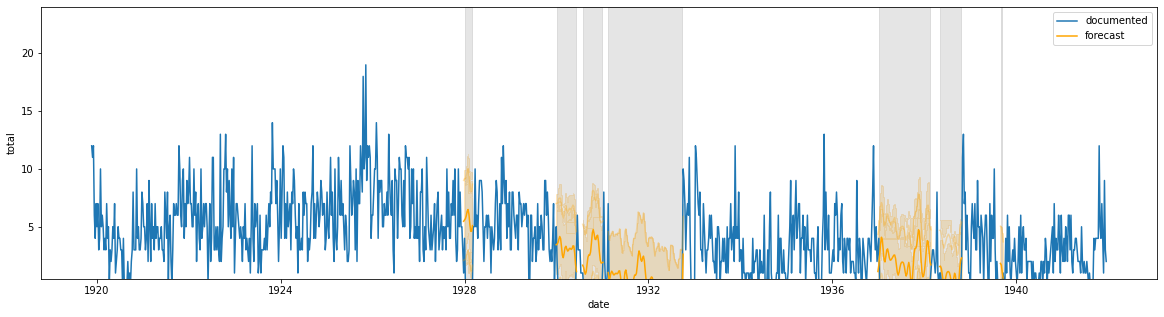

In [78]:
plot_newsubs_weekly_forecast(newsub_weekly_forecasts)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

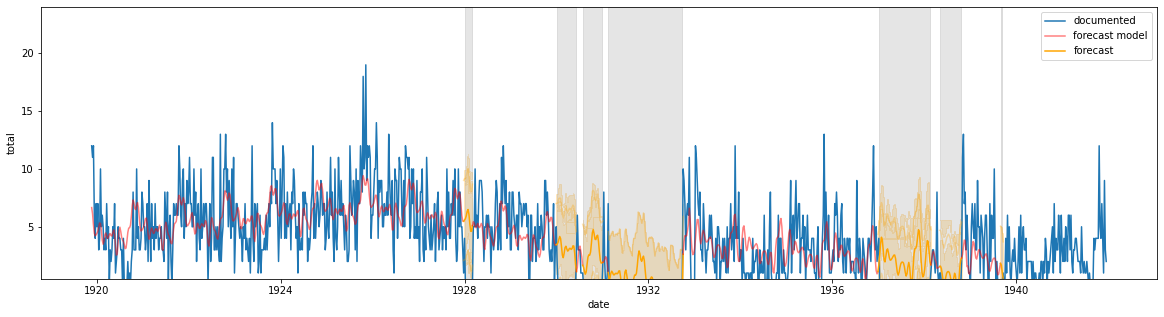

In [79]:
plot_newsubs_weekly_forecast(newsub_weekly_forecasts, show_model=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

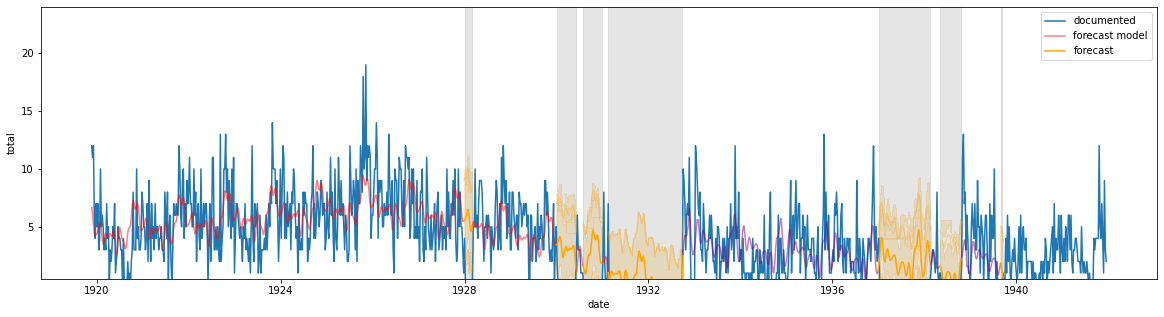

In [80]:
plot_newsubs_weekly_forecast(newsub_weekly_forecasts, show_model=True, separate_model_decades=True)

### what if we fit prophet on all weeks?

In [81]:
# what if we just train prophet on all the data?

from prophet import Prophet

post1932 = pd.to_datetime(date(1932, 9, 27))

newsub_m = Prophet(weekly_seasonality=True)
# rename monthly count columns for prophet and fit the data
newsub_m.fit(newmember_subscriptions_by_week.rename(columns={'date': 'ds', 'total': 'y'}))

# show some number of months before/after the gap and forecast
oneweek = timedelta(days=7)

# lists to aggregate forecasts and models
all_newsub_weekly_forecasts_dfs = []

# there's a significant difference between 1920s and 1930s data,
# and there's a big gap in 1931-1932
# for gaps after 1936, only include counts after the 1932 gap
#   February 16 1931 to September 26 1932 (588 days)
#   December 31 1936 to February 17 1938 (413 days)

post1932 = pd.to_datetime(date(1932, 9, 27))

for i, gap in enumerate(logbook_gaps):
  gap_start = gap['start']
  gap_end = gap['end']
  print('forecasting %s' % gap)

  weekly_m = Prophet()
  gap_start = gap['start']
  gap_end = gap['end']
  print('forecasting %s' % gap)

  # preceding_data = logbooks_weekly_count[logbooks_weekly_count.logbook_date < gap_start]
  preceding_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date < gap_start]

  # for late gaps, only include counts after september 1932
  if gap_start.year >= 1936:
    preceding_data = preceding_data[preceding_data.date >= post1932 ]

  # drop any zeroes, so prophet doesn't fit to missing data
  preceding_data = preceding_data[preceding_data.total.gt(0)]

  # rename monthly count columns for prophet and fit thed ata
  weekly_m.fit(preceding_data.rename(columns={'date': 'ds', 'total': 'y'}))


  # make a future dataframe to cover the gap 
  # (need at least 1 extra; may want to add more while testing)
  forecast_for = math.ceil(gap['days']/ 7) + 7
  # forecast_for = float(gap['days'])/7.0 + 7
  print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))

  # use mini prophet to make the future relative to our gap
  newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')

  # newsub_weeks_future = newsub_m.make_future_dataframe(periods=forecast_for, freq='W')
  print(newsub_weeks_future.tail())
  newsub_weeks_fcst = newsub_m.predict(newsub_weeks_future)

  # plot the forecast around our gap
  forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
  display(forecast_near_gap.head())
  # all_gap_forecasts_dfs.append(forecast_near_gap)

  newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

  forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

  all_newsub_weekly_forecasts_dfs.append(newsub_weeks_fcst.copy())


all_newsub_weekly_forecasts_dfs
  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks
            ds
423 1928-03-18
424 1928-03-25
425 1928-04-01
426 1928-04-08
427 1928-04-15


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
412 1928-01-01  10.424578    1.296042    8.135295    10.424578    10.424578   
413 1928-01-08  10.407496    1.968337    8.500394    10.407496    10.407496   
414 1928-01-15  10.390414    2.188163    8.855236    10.390414    10.390414   
415 1928-01-22  10.373331    2.495455    9.291010    10.373331    10.373331   
416 1928-01-29  10.356249    2.230209    9.018461    10.356249    10.356249   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
412       -5.718629             -5.718629             -5.718629 -5.398148   
413       -5.343248             -5.343248             -5.343248 -5.398148   
414       -4.902915             -4.902915             -4.902915 -5.398148   
415       -4.583488             -4.583488             -4.583488 -5.398148   
416       -4.587371             -4.587371             -4.587371 -5.398148   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
412     -5.398148     -5.398148 -0.320481     -0.320481     -0.320481   
413     -5.398148     -5.398148  0.054899      0.054899      0.054899   
414     -5.398148     -5.398148  0.495233      0.495233      0.495233   
415     -5.398148     -5.398148  0.814659      0.814659      0.814659   
416     -5.398148     -5.398148  0.810776      0.810776      0.810776   

     multiplicative_terms  multiplicative_terms_lower  \
412                   0.0                         0.0   
413                   0.0                         0.0   
414                   0.0                         0.0   
415                   0.0                         0.0   
416                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
412                         0.0  4.705949  
413                         0.0  5.064248  
414                         0.0  5.487499  
415                         0.0  5.789843  
416                         0.0  5.768877

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks
            ds
529 1930-06-22
530 1930-06-29
531 1930-07-06
532 1930-07-13
533 1930-07-20


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
504 1929-12-29  8.648005   -0.740763    6.179622     8.648005     8.648005   
505 1930-01-05  8.630923   -0.059570    6.468356     8.630923     8.630923   
506 1930-01-12  8.613841    0.101396    6.972818     8.613841     8.613841   
507 1930-01-19  8.596758    0.423759    7.097226     8.596758     8.596758   
508 1930-01-26  8.579676    0.531242    7.481630     8.579676     8.579676   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
504       -5.811634             -5.811634             -5.811634 -5.398148   
505       -5.492214             -5.492214             -5.492214 -5.398148   
506       -5.057476             -5.057476             -5.057476 -5.398148   
507       -4.669646             -4.669646             -4.669646 -5.398148   
508       -4.540621             -4.540621             -4.540621 -5.398148   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
504     -5.398148     -5.398148 -0.413486     -0.413486     -0.413486   
505     -5.398148     -5.398148 -0.094066     -0.094066     -0.094066   
506     -5.398148     -5.398148  0.340672      0.340672      0.340672   
507     -5.398148     -5.398148  0.728501      0.728501      0.728501   
508     -5.398148     -5.398148  0.857526      0.857526      0.857526   

     multiplicative_terms  multiplicative_terms_lower  \
504                   0.0                         0.0   
505                   0.0                         0.0   
506                   0.0                         0.0   
507                   0.0                         0.0   
508                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
504                         0.0  2.836372  
505                         0.0  3.138710  
506                         0.0  3.556365  
507                         0.0  3.927112  
508                         0.0  4.039054

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks
            ds
538 1931-01-18
539 1931-01-25
540 1931-02-01
541 1931-02-08
542 1931-02-15


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
513 1930-07-27  8.148928   -1.452210    5.262486     8.148928     8.148928   
514 1930-08-03  8.134525   -1.825160    4.912697     8.134525     8.134525   
515 1930-08-10  8.120122   -1.919214    4.716294     8.120122     8.120122   
516 1930-08-17  8.105718   -1.988224    4.502939     8.105718     8.105718   
517 1930-08-24  8.091315   -1.797868    5.053795     8.091315     8.091315   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
513       -6.316209             -6.316209             -6.316209 -5.398148   
514       -6.574469             -6.574469             -6.574469 -5.398148   
515       -6.760194             -6.760194             -6.760194 -5.398148   
516       -6.754504             -6.754504             -6.754504 -5.398148   
517       -6.501166             -6.501166             -6.501166 -5.398148   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
513     -5.398148     -5.398148 -0.918061     -0.918061     -0.918061   
514     -5.398148     -5.398148 -1.176321     -1.176321     -1.176321   
515     -5.398148     -5.398148 -1.362047     -1.362047     -1.362047   
516     -5.398148     -5.398148 -1.356356     -1.356356     -1.356356   
517     -5.398148     -5.398148 -1.103018     -1.103018     -1.103018   

     multiplicative_terms  multiplicative_terms_lower  \
513                   0.0                         0.0   
514                   0.0                         0.0   
515                   0.0                         0.0   
516                   0.0                         0.0   
517                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
513                         0.0  1.832720  
514                         0.0  1.560056  
515                         0.0  1.359927  
516                         0.0  1.351215  
517                         0.0  1.590149

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks
            ds
605 1932-10-16
606 1932-10-23
607 1932-10-30
608 1932-11-06
609 1932-11-13


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
518 1931-02-15  7.731233   -1.091112    5.427469     7.731233     7.731233   
519 1931-02-22  7.716829   -1.482471    5.404674     7.716829     7.716829   
520 1931-03-01  7.702426   -0.979501    5.575485     7.702426     7.702426   
521 1931-03-08  7.688023   -0.859445    5.970792     7.688023     7.688023   
522 1931-03-15  7.681489   -0.861917    5.906453     7.681489     7.681489   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
518       -5.623736             -5.623736             -5.623736 -5.398148   
519       -5.719879             -5.719879             -5.719879 -5.398148   
520       -5.495872             -5.495872             -5.495872 -5.398148   
521       -5.253043             -5.253043             -5.253043 -5.398148   
522       -5.257842             -5.257842             -5.257842 -5.398148   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
518     -5.398148     -5.398148 -0.225589     -0.225589     -0.225589   
519     -5.398148     -5.398148 -0.321731     -0.321731     -0.321731   
520     -5.398148     -5.398148 -0.097724     -0.097724     -0.097724   
521     -5.398148     -5.398148  0.145104      0.145104      0.145104   
522     -5.398148     -5.398148  0.140306      0.140306      0.140306   

     multiplicative_terms  multiplicative_terms_lower  \
518                   0.0                         0.0   
519                   0.0                         0.0   
520                   0.0                         0.0   
521                   0.0                         0.0   
522                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
518                         0.0  2.107496  
519                         0.0  1.996951  
520                         0.0  2.206554  
521                         0.0  2.434979  
522                         0.0  2.423647

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks
            ds
248 1938-03-06
249 1938-03-13
250 1938-03-20
251 1938-03-27
252 1938-04-03


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
186 1936-12-27  7.663722   -1.845978    5.039530     7.663722     7.663722   
187 1937-01-03  7.664558   -1.432110    5.522513     7.664558     7.664558   
188 1937-01-10  7.665394   -0.719057    5.835698     7.665394     7.665394   
189 1937-01-17  7.666230   -0.618007    6.249462     7.666230     7.666230   
190 1937-01-24  7.667066   -0.462730    6.730436     7.667066     7.667066   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
186       -5.859018             -5.859018             -5.859018 -5.398148   
187       -5.587843             -5.587843             -5.587843 -5.398148   
188       -5.169338             -5.169338             -5.169338 -5.398148   
189       -4.750665             -4.750665             -4.750665 -5.398148   
190       -4.538436             -4.538436             -4.538436 -5.398148   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
186     -5.398148     -5.398148 -0.460871     -0.460871     -0.460871   
187     -5.398148     -5.398148 -0.189695     -0.189695     -0.189695   
188     -5.398148     -5.398148  0.228809      0.228809      0.228809   
189     -5.398148     -5.398148  0.647482      0.647482      0.647482   
190     -5.398148     -5.398148  0.859711      0.859711      0.859711   

     multiplicative_terms  multiplicative_terms_lower  \
186                   0.0                         0.0   
187                   0.0                         0.0   
188                   0.0                         0.0   
189                   0.0                         0.0   
190                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
186                         0.0  1.804704  
187                         0.0  2.076715  
188                         0.0  2.496056  
189                         0.0  2.915565  
190                         0.0  3.128630

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks
            ds
224 1938-11-06
225 1938-11-13
226 1938-11-20
227 1938-11-27
228 1938-12-04


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
197 1938-05-01  7.722250   -1.080012    5.493821     7.722250     7.722250   
198 1938-05-08  7.723086   -1.184390    5.621878     7.723086     7.723086   
199 1938-05-15  7.723922   -1.001039    5.461197     7.723922     7.723922   
200 1938-05-22  7.724758   -1.689535    5.432091     7.724758     7.724758   
201 1938-05-29  7.725594   -2.175088    4.640041     7.725594     7.725594   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
197       -5.499919             -5.499919             -5.499919 -5.398148   
198       -5.480533             -5.480533             -5.480533 -5.398148   
199       -5.541784             -5.541784             -5.541784 -5.398148   
200       -5.856318             -5.856318             -5.856318 -5.398148   
201       -6.380299             -6.380299             -6.380299 -5.398148   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
197     -5.398148     -5.398148 -0.101772     -0.101772     -0.101772   
198     -5.398148     -5.398148 -0.082386     -0.082386     -0.082386   
199     -5.398148     -5.398148 -0.143636     -0.143636     -0.143636   
200     -5.398148     -5.398148 -0.458171     -0.458171     -0.458171   
201     -5.398148     -5.398148 -0.982151     -0.982151     -0.982151   

     multiplicative_terms  multiplicative_terms_lower  \
197                   0.0                         0.0   
198                   0.0                         0.0   
199                   0.0                         0.0   
200                   0.0                         0.0   
201                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
197                         0.0  2.222330  
198                         0.0  2.242553  
199                         0.0  2.182138  
200                         0.0  1.868439  
201                         0.0  1.345295

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks
            ds
239 1939-09-03
240 1939-09-10
241 1939-09-17
242 1939-09-24
243 1939-10-01


ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
238 1939-08-27  7.779942   -2.019501    4.869680     7.779942     7.779942   
239 1939-09-03  7.780778   -1.722162    5.287560     7.780778     7.780778   
240 1939-09-10  7.781614   -1.481241    5.313833     7.781614     7.781614   
241 1939-09-17  7.782450   -1.910943    5.223004     7.782450     7.782450   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
238       -6.361669             -6.361669             -6.361669 -5.398148   
239       -6.055888             -6.055888             -6.055888 -5.398148   
240       -5.975353             -5.975353             -5.975353 -5.398148   
241       -6.039498             -6.039498             -6.039498 -5.398148   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
238     -5.398148     -5.398148 -0.963521     -0.963521     -0.963521   
239     -5.398148     -5.398148 -0.657741     -0.657741     -0.657741   
240     -5.398148     -5.398148 -0.577206     -0.577206     -0.577206   
241     -5.398148     -5.398148 -0.641351     -0.641351     -0.641351   

     multiplicative_terms  multiplicative_terms_lower  \
238                   0.0                         0.0   
239                   0.0                         0.0   
240                   0.0                         0.0   
241                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
238                         0.0  1.418273  
239                         0.0  1.724889  
240                         0.0  1.806261  
241                         0.0  1.742952

[            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
 0   1919-11-23  10.176542    3.485713   10.099444    10.176542    10.176542   
 1   1919-11-30  10.182642    2.579195    9.446111    10.182642    10.182642   
 2   1919-12-07  10.188742    1.901986    8.560088    10.188742    10.188742   
 3   1919-12-14  10.194842    1.386173    8.312968    10.194842    10.194842   
 4   1919-12-21  10.200942    1.013516    7.869054    10.200942    10.200942   
 ..         ...        ...         ...         ...          ...          ...   
 423 1928-03-18  10.236672    1.596370    8.496609    10.236672    10.236672   
 424 1928-03-25  10.219589    1.126162    8.065845    10.219589    10.219589   
 425 1928-04-01  10.202507    0.914972    7.860801    10.202507    10.202507   
 426 1928-04-08  10.185424    1.203661    7.872083    10.185424    10.185424   
 427 1928-04-15  10.168342    1.297237    7.862435    10.168342    10.168342   
 
      additive_terms  additive_terms_l

In [82]:
newsub_weekly_forecasts_df = pd.concat(all_newsub_weekly_forecasts_dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

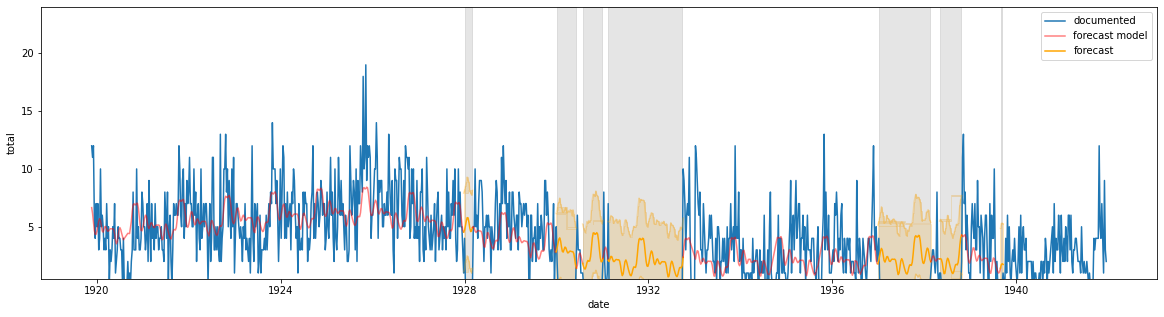

In [83]:
plot_newsubs_weekly_forecast(newsub_weekly_forecasts_df, show_model=True) #, separate_model_decades=True)

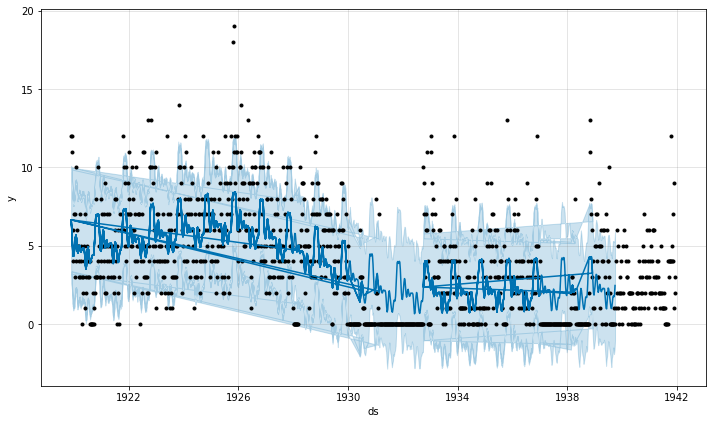

In [84]:
fig1 = newsub_m.plot(newsub_weekly_forecasts_df)

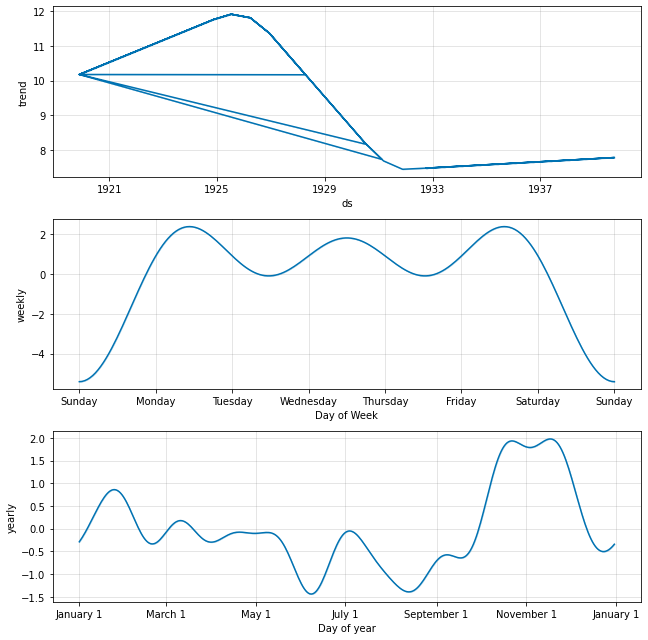

In [85]:
fig2 = newsub_m.plot_components(newsub_weekly_forecasts_df)

In [86]:
# plot new subscriptions logbooks with gaps
from altair import datum

newsubs_forecast_base = alt.Chart(newsub_weekly_forecasts).encode(
    alt.X('ds:T', axis=alt.Axis(title='date'))
).properties(
    width=1200,
    height=275
)

newsubs_forecast_line = newsubs_forecast_base.mark_line(color="orange").encode(
    alt.Y('yhat',
          axis=alt.Axis(title='new subscriptions per week'), scale=alt.Scale(domain=[0, 20])),
)
# .transform_filter(
    # alt.FieldLTPredicate(field='ds', lt=date(1919, 1,1))
# )

newsubs_area = newsubs_forecast_base.mark_area(opacity=0.3, color='orange').encode(
    alt.Y('yhat_upper',
          axis=alt.Axis(title=None), scale=alt.Scale(domain=[0, 20])),
    alt.Y2('yhat_lower')
)

# add newsubs last so it will be layered on top
newsubs_line + logbook_gaps_span + newsubs_area + newsubs_forecast_line

alt.LayerChart(...)

### forecast again, with growth and cap

the default forecast behavior is following a downward trend in the existing data leading into our later gaps, but based on the data afterwards that doesn't look right. 




In [87]:
# when is the largest week? 
growth_cap = newmember_subscriptions_by_week.total.max()
newmember_subscriptions_by_week[newmember_subscriptions_by_week.total == growth_cap]

date  total
311 1925-11-08     19

In [88]:
from datetime import date, timedelta
import math

from prophet import Prophet

post1932 = pd.to_datetime(date(1932, 9, 27))


def growth_forecast_missing_newsubs():
  # show some number of months before/after the gap and forecast
  oneweek = timedelta(days=7)
  sixweeks = timedelta(days=7*6)

  # lists to aggregate forecasts and models
  all_newsub_weekly_forecasts_dfs = []

  # there's a significant difference between 1920s and 1930s data,
  # and there's a big gap in 1931-1932
  # for gaps after 1936, only include counts after the 1932 gap
  #   February 16 1931 to September 26 1932 (588 days)
  #   December 31 1936 to February 17 1938 (413 days)

  post1932 = pd.to_datetime(date(1932, 9, 27))

  # use largest week across all data as our growth cap
  growth_cap = newmember_subscriptions_by_week.total.max()
  print('max from all data is %s' % growth_cap)


  for i, gap in enumerate(logbook_gaps):
    weekly_m = Prophet(growth='logistic', weekly_seasonality=True)  # use logistic growth instead of linear
    gap_start = gap['start']
    gap_end = gap['end']
    print('forecasting %s' % gap)

    preceding_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date < gap_start]

    # for late gaps, only include counts after september 1932
    if gap_start.year >= 1936:
      preceding_data = preceding_data[preceding_data.date >= post1932 ]

    # drop any zeroes, so prophet doesn't fit to missing data
    preceding_data = preceding_data[preceding_data.total.gt(0)]

    # rename monthly count columns for prophet and fit the data
    data_to_fit = preceding_data.rename(columns={'date': 'ds', 'total': 'y'})
    data_to_fit['floor'] = 0
    # (should this be max from current data or next? or both? or all?)
    data_to_fit['cap'] = growth_cap
    weekly_m.fit(data_to_fit)

    # make a future dataframe to cover the gap 
    # (need at least 1 extra; may want to add more while testing)
    forecast_for = math.ceil(gap['days']/ 7) + 7
    print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))
    newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')

    # post_gap_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date > gap_end][newmember_subscriptions_by_week.date < (gap_end + sixweeks)]
    newsub_weeks_future['floor'] = 0
    newsub_weeks_future['cap'] = growth_cap
    newsub_weeks_fcst = weekly_m.predict(newsub_weeks_future)

    # plot the forecast around our gap
    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
    display(forecast_near_gap.head())
    # all_gap_forecasts_dfs.append(forecast_near_gap)

    newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

    all_newsub_weekly_forecasts_dfs.append(newsub_weeks_fcst.copy())

  # combine all the forecasts into a single df
  newsub_weekly_forecasts_dfs = pd.concat(all_newsub_weekly_forecasts_dfs)
  # all_gap_forecasts = pd.concat(all_gap_forecasts_dfs)

  return newsub_weekly_forecasts_dfs


newsub_weekly_growth_forecasts = growth_forecast_missing_newsubs()
newsub_weekly_growth_forecasts

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


max from all data is 19
forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
412 1928-01-01  0.002428   19      0    2.259820    9.217085     0.002428   
413 1928-01-08  0.002409   19      0    2.388458    9.502484     0.002409   
414 1928-01-15  0.002390   19      0    2.978213   10.026360     0.002390   
415 1928-01-22  0.002371   19      0    3.679991   10.849143     0.002371   
416 1928-01-29  0.002353   19      0    3.819893   10.769102     0.002353   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
412     0.002428        5.828387              5.828387  ...  6.032644   
413     0.002409        6.118213              6.118213  ...  6.032644   
414     0.002390        6.604547              6.604547  ...  6.032644   
415     0.002371        7.193083              7.193083  ...  6.032644   
416     0.002353        7.412014              7.412014  ...  6.032644   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
412      6.032644      6.032644 -0.204257     -0.204257     -0.204257   
413      6.032644      6.032644  0.085569      0.085569      0.085569   
414      6.032644      6.032644  0.571903      0.571903      0.571903   
415      6.032644      6.032644  1.160439      1.160439      1.160439   
416      6.032644      6.032644  1.379370      1.379370      1.379370   

     multiplicative_terms  multiplicative_terms_lower  \
412                   0.0                         0.0   
413                   0.0                         0.0   
414                   0.0                         0.0   
415                   0.0                         0.0   
416                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
412                         0.0  5.830816  
413                         0.0  6.120623  
414                         0.0  6.606938  
415                         0.0  7.195454  
416                         0.0  7.414366  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
504 1929-12-29  9.943319   19      0    2.597078    9.441838     9.943319   
505 1930-01-05  9.944565   19      0    2.961408    9.609609     9.944565   
506 1930-01-12  9.945812   19      0    3.486722    9.838136     9.945812   
507 1930-01-19  9.947058   19      0    4.040696   10.875457     9.947058   
508 1930-01-26  9.948304   19      0    4.242510   11.091038     9.948304   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
504     9.943319       -4.123368             -4.123368  ... -3.638517   
505     9.944565       -3.784465             -3.784465  ... -3.638517   
506     9.945812       -3.187585             -3.187585  ... -3.638517   
507     9.947058       -2.506937             -2.506937  ... -3.638517   
508     9.948304       -2.169848             -2.169848  ... -3.638517   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
504     -3.638517     -3.638517 -0.484851     -0.484851     -0.484851   
505     -3.638517     -3.638517 -0.145948     -0.145948     -0.145948   
506     -3.638517     -3.638517  0.450932      0.450932      0.450932   
507     -3.638517     -3.638517  1.131579      1.131579      1.131579   
508     -3.638517     -3.638517  1.468669      1.468669      1.468669   

     multiplicative_terms  multiplicative_terms_lower  \
504                   0.0                         0.0   
505                   0.0                         0.0   
506                   0.0                         0.0   
507                   0.0                         0.0   
508                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
504                         0.0  5.819951  
505                         0.0  6.160101  
506                         0.0  6.758227  
507                         0.0  7.440121  
508                         0.0  7.778456  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
513 1930-07-27  0.007332   19      0    1.327404    8.130239     0.007332   
514 1930-08-03  0.007288   19      0    1.311289    8.257707     0.007288   
515 1930-08-10  0.007244   19      0    1.694640    8.295270     0.007244   
516 1930-08-17  0.007200   19      0    1.251909    8.272132     0.007200   
517 1930-08-24  0.007157   19      0    1.435321    8.621646     0.007157   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
513     0.007332        4.818895              4.818895  ...  5.862762   
514     0.007288        4.864597              4.864597  ...  5.862762   
515     0.007244        4.781350              4.781350  ...  5.862762   
516     0.007200        4.688430              4.688430  ...  5.862762   
517     0.007157        4.881372              4.881372  ...  5.862762   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
513      5.862762      5.862762 -1.043867     -1.043867     -1.043867   
514      5.862762      5.862762 -0.998165     -0.998165     -0.998165   
515      5.862762      5.862762 -1.081412     -1.081412     -1.081412   
516      5.862762      5.862762 -1.174332     -1.174332     -1.174332   
517      5.862762      5.862762 -0.981389     -0.981389     -0.981389   

     multiplicative_terms  multiplicative_terms_lower  \
513                   0.0                         0.0   
514                   0.0                         0.0   
515                   0.0                         0.0   
516                   0.0                         0.0   
517                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
513                         0.0  4.826227  
514                         0.0  4.871885  
515                         0.0  4.788594  
516                         0.0  4.695630  
517                         0.0  4.888529  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
518 1931-02-15  9.602312   19      0    2.068453    8.850146     9.602312   
519 1931-02-22  9.602672   19      0    1.756198    8.785246     9.602672   
520 1931-03-01  9.603032   19      0    2.115266    9.152785     9.603032   
521 1931-03-08  9.603391   19      0    2.580807    9.608196     9.603391   
522 1931-03-15  9.603751   19      0    2.243999    9.384106     9.603751   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
518     9.602312       -4.119941             -4.119941  ... -3.565623   
519     9.602672       -4.327564             -4.327564  ... -3.565623   
520     9.603032       -3.955562             -3.955562  ... -3.565623   
521     9.603391       -3.582907             -3.582907  ... -3.565623   
522     9.603751       -3.657701             -3.657701  ... -3.565623   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
518     -3.565623     -3.565623 -0.554318     -0.554318     -0.554318   
519     -3.565623     -3.565623 -0.761941     -0.761941     -0.761941   
520     -3.565623     -3.565623 -0.389940     -0.389940     -0.389940   
521     -3.565623     -3.565623 -0.017284     -0.017284     -0.017284   
522     -3.565623     -3.565623 -0.092078     -0.092078     -0.092078   

     multiplicative_terms  multiplicative_terms_lower  \
518                   0.0                         0.0   
519                   0.0                         0.0   
520                   0.0                         0.0   
521                   0.0                         0.0   
522                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
518                         0.0  5.482371  
519                         0.0  5.275108  
520                         0.0  5.647469  
521                         0.0  6.020484  
522                         0.0  5.946049  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
186 1936-12-27  6.605094   19      0   -0.423926    5.276829     6.605094   
187 1937-01-03  6.598154   19      0    0.052786    5.909515     6.598154   
188 1937-01-10  6.591218   19      0    0.487784    6.525144     6.591218   
189 1937-01-17  6.584286   19      0    1.640535    7.543302     6.584285   
190 1937-01-24  6.577356   19      0    2.250145    8.061965     6.577354   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
186     6.605094       -4.293581             -4.293581  ... -3.575246   
187     6.598154       -3.636471             -3.636471  ... -3.575246   
188     6.591218       -2.770288             -2.770288  ... -3.575246   
189     6.584286       -1.876569             -1.876569  ... -3.575246   
190     6.577359       -1.417058             -1.417058  ... -3.575246   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
186     -3.575246     -3.575246 -0.718335     -0.718335     -0.718335   
187     -3.575246     -3.575246 -0.061225     -0.061225     -0.061225   
188     -3.575246     -3.575246  0.804958      0.804958      0.804958   
189     -3.575246     -3.575246  1.698677      1.698677      1.698677   
190     -3.575246     -3.575246  2.158188      2.158188      2.158188   

     multiplicative_terms  multiplicative_terms_lower  \
186                   0.0                         0.0   
187                   0.0                         0.0   
188                   0.0                         0.0   
189                   0.0                         0.0   
190                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
186                         0.0  2.311513  
187                         0.0  2.961683  
188                         0.0  3.820930  
189                         0.0  4.707716  
190                         0.0  5.160298  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
197 1938-05-01  0.111489   19      0   -0.195745    5.691816     0.111489   
198 1938-05-08  0.110358   19      0    0.273904    6.058214     0.110358   
199 1938-05-15  0.109239   19      0    0.542734    5.986600     0.109239   
200 1938-05-22  0.108131   19      0   -0.000607    5.900672     0.108131   
201 1938-05-29  0.107033   19      0   -0.510876    5.283032     0.107033   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
197     0.111489        2.617128              2.617128  ...  2.971498   
198     0.110358        2.931202              2.931202  ...  2.971498   
199     0.109239        3.111385              3.111385  ...  2.971498   
200     0.108131        2.857573              2.857573  ...  2.971498   
201     0.107033        2.198074              2.198074  ...  2.971498   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
197      2.971498      2.971498 -0.354369     -0.354369     -0.354369   
198      2.971498      2.971498 -0.040296     -0.040296     -0.040296   
199      2.971498      2.971498  0.139887      0.139887      0.139887   
200      2.971498      2.971498 -0.113925     -0.113925     -0.113925   
201      2.971498      2.971498 -0.773424     -0.773424     -0.773424   

     multiplicative_terms  multiplicative_terms_lower  \
197                   0.0                         0.0   
198                   0.0                         0.0   
199                   0.0                         0.0   
200                   0.0                         0.0   
201                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
197                         0.0  2.728618  
198                         0.0  3.041560  
199                         0.0  3.220624  
200                         0.0  2.965704  
201                         0.0  2.305107  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
238 1939-08-27  0.181809   19      0    0.362683    6.456927     0.181809   
239 1939-09-03  0.180779   19      0   -0.216808    5.776223     0.180779   
240 1939-09-10  0.179754   19      0   -1.413187    4.658502     0.179754   
241 1939-09-17  0.178736   19      0   -1.381131    4.810509     0.178736   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
238     0.181809        3.215434              3.215434  ...  3.231015   
239     0.180779        2.510458              2.510458  ...  3.231015   
240     0.179754        1.627070              1.627070  ...  3.231015   
241     0.178736        1.514221              1.514221  ...  3.231015   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
238      3.231015      3.231015 -0.015581     -0.015581     -0.015581   
239      3.231015      3.231015 -0.720557     -0.720557     -0.720557   
240      3.231015      3.231015 -1.603945     -1.603945     -1.603945   
241      3.231015      3.231015 -1.716794     -1.716794     -1.716794   

     multiplicative_terms  multiplicative_terms_lower  \
238                   0.0                         0.0   
239                   0.0                         0.0   
240                   0.0                         0.0   
241                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
238                         0.0  3.397243  
239                         0.0  2.691236  
240                         0.0  1.806824  
241                         0.0  1.692956  

[4 rows x 21 columns]

ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
0   1919-11-23  0.069339   19      0    4.842691   11.999401     0.069339   
1   1919-11-30  0.068793   19      0    4.165215   11.214137     0.068793   
2   1919-12-07  0.068252   19      0    3.293317   10.245082     0.068252   
3   1919-12-14  0.067715   19      0    2.279438    9.425314     0.067715   
4   1919-12-21  0.067181   19      0    2.045391    9.043181     0.067181   
..         ...       ...  ...    ...         ...         ...          ...   
239 1939-09-03  0.180779   19      0   -0.216808    5.776223     0.180779   
240 1939-09-10  0.179754   19      0   -1.413187    4.658502     0.179754   
241 1939-09-17  0.178736   19      0   -1.381131    4.810509     0.178736   
242 1939-09-24  0.177723   19      0   -0.331719    5.471749     0.177723   
243 1939-10-01  0.176715   19      0    0.263227    6.561660     0.176715   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
0       0.069339        8.317297              8.317297  ...  6.032644   
1       0.068793        7.593559              7.593559  ...  6.032644   
2       0.068252        6.497992              6.497992  ...  6.032644   
3       0.067715        5.719785              5.719785  ...  6.032644   
4       0.067181        5.533379              5.533379  ...  6.032644   
..           ...             ...                   ...  ...       ...   
239     0.180779        2.510458              2.510458  ...  3.231015   
240     0.179754        1.627070              1.627070  ...  3.231015   
241     0.178736        1.514221              1.514221  ...  3.231015   
242     0.177723        2.365788              2.365788  ...  3.231015   
243     0.176715        3.464891              3.464891  ...  3.231015   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0        6.032644      6.032644  2.284653      2.284653      2.284653   
1        6.032644      6.032644  1.560915      1.560915      1.560915   
2        6.032644      6.032644  0.465348      0.465348      0.465348   
3        6.032644      6.032644 -0.312859     -0.312859     -0.312859   
4        6.032644      6.032644 -0.499265     -0.499265     -0.499265   
..            ...           ...       ...           ...           ...   
239      3.231015      3.231015 -0.720557     -0.720557     -0.720557   
240      3.231015      3.231015 -1.603945     -1.603945     -1.603945   
241      3.231015      3.231015 -1.716794     -1.716794     -1.716794   
242      3.231015      3.231015 -0.865227     -0.865227     -0.865227   
243      3.231015      3.231015  0.233876      0.233876      0.233876   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
239                   0.0                         0.0   
240                   0.0                         0.0   
241                   0.0                         0.0   
242                   0.0                         0.0   
243                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
0                           0.0  8.386637  
1                           0.0  7.662353  
2                           0.0  6.566244  
3                           0.0  5.787500  
4                           0.0  5.600560  
..                          ...       ...  
239                         0.0  2.691236  
240                         0.0  1.806824  
241                         0.0  1.692956  
242                         0.0  2.543510  
243                         0.0  3.641606  

[2841 rows x 21 columns]

#### plot the forecasts

<Figure size 432x288 with 0 Axes>

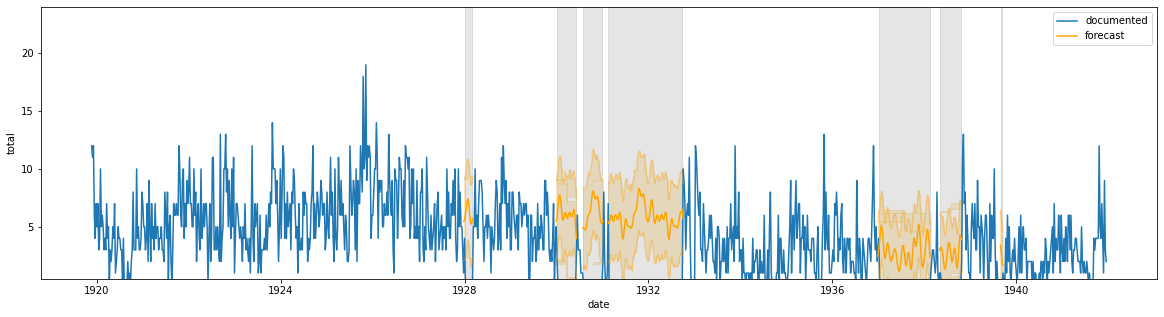

In [89]:
plot_newsubs_weekly_forecast(newsub_weekly_growth_forecasts)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

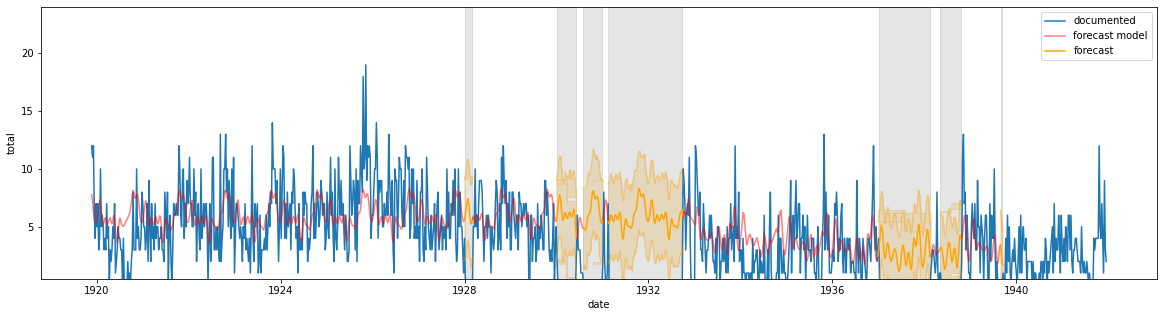

In [90]:
plot_newsubs_weekly_forecast(newsub_weekly_growth_forecasts, show_model=True)

### fit on all weeks, logistic growth

In [91]:
lognewsub_m = Prophet(weekly_seasonality=True, growth='logistic')
# use largest week across all data as our growth cap
growth_cap = newmember_subscriptions_by_week.total.max()

newmember_weekly_subs = newmember_subscriptions_by_week.rename(columns={'date': 'ds', 'total': 'y'})
newmember_weekly_subs['floor'] = 0
newmember_weekly_subs['cap'] = growth_cap
# rename monthly count columns for prophet and fit the data
lognewsub_m.fit(newmember_weekly_subs)

# lognewsub_weeks_fcst

post1932 = pd.to_datetime(date(1932, 9, 27))

# show some number of months before/after the gap and forecast
oneweek = timedelta(days=7)

# lists to aggregate forecasts and models
all_lognewsub_forecasts_dfs = []

# there's a significant difference between 1920s and 1930s data,
# and there's a big gap in 1931-1932
# for gaps after 1936, only include counts after the 1932 gap
#   February 16 1931 to September 26 1932 (588 days)
#   December 31 1936 to February 17 1938 (413 days)

post1932 = pd.to_datetime(date(1932, 9, 27))

for i, gap in enumerate(logbook_gaps):
  gap_start = gap['start']
  gap_end = gap['end']
  print('forecasting %s' % gap)

  weekly_m = Prophet()
  gap_start = gap['start']
  gap_end = gap['end']
  print('forecasting %s' % gap)

  # preceding_data = logbooks_weekly_count[logbooks_weekly_count.logbook_date < gap_start]
  preceding_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date < gap_start]

  # for late gaps, only include counts after september 1932
  if gap_start.year >= 1936:
    preceding_data = preceding_data[preceding_data.date >= post1932 ]

  # drop any zeroes, so prophet doesn't fit to missing data
  # FIXME: needed/wanted?
  preceding_data = preceding_data[preceding_data.total.gt(0)]

  preceding_data['floor'] = 0
  preceding_data['cap'] = growth_cap

  # rename monthly count columns for prophet and fit the data
  weekly_m.fit(preceding_data.rename(columns={'date': 'ds', 'total': 'y'}))

  # make a future dataframe to cover the gap 
  # (need at least 1 extra; may want to add more while testing)
  forecast_for = math.ceil(gap['days']/ 7) + 7
  # forecast_for = float(gap['days'])/7.0 + 7
  print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))

  # use mini prophet to make the future relative to our gap
  newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')

  # newsub_weeks_future = newsub_m.make_future_dataframe(periods=forecast_for, freq='W')
  newsub_weeks_future['floor'] = 0
  newsub_weeks_future['cap'] = growth_cap
  newsub_weeks_fcst = lognewsub_m.predict(newsub_weeks_future)

  # plot the forecast around our gap
  forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
  display(forecast_near_gap.head())
  # all_gap_forecasts_dfs.append(forecast_near_gap)

  newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

  forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

  all_lognewsub_forecasts_dfs.append(newsub_weeks_fcst.copy())


all_lognewsub_forecasts_dfs  


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
412 1928-01-01  2.773468   19      0    0.176345    7.544783     2.773468   
413 1928-01-08  2.768381   19      0    0.167183    7.770026     2.768381   
414 1928-01-15  2.763302   19      0    0.689886    8.241529     2.763302   
415 1928-01-22  2.758231   19      0    0.943585    8.574165     2.758231   
416 1928-01-29  2.753167   19      0    0.965793    8.499973     2.753167   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
412     2.773468        0.923024              0.923024  ...  1.295368   
413     2.768381        1.296671              1.296671  ...  1.295368   
414     2.763302        1.742610              1.742610  ...  1.295368   
415     2.758231        2.069447              2.069447  ...  1.295368   
416     2.753167        2.068643              2.068643  ...  1.295368   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
412      1.295368      1.295368 -0.372344     -0.372344     -0.372344   
413      1.295368      1.295368  0.001303      0.001303      0.001303   
414      1.295368      1.295368  0.447241      0.447241      0.447241   
415      1.295368      1.295368  0.774078      0.774078      0.774078   
416      1.295368      1.295368  0.773275      0.773275      0.773275   

     multiplicative_terms  multiplicative_terms_lower  \
412                   0.0                         0.0   
413                   0.0                         0.0   
414                   0.0                         0.0   
415                   0.0                         0.0   
416                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
412                         0.0  3.696493  
413                         0.0  4.065052  
414                         0.0  4.505912  
415                         0.0  4.827677  
416                         0.0  4.821810  

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
504 1929-12-29  2.284740   19      0   -0.777521    6.608527     2.284740   
505 1930-01-05  2.280424   19      0   -0.636660    7.223236     2.280424   
506 1930-01-12  2.276114   19      0    0.219373    7.727009     2.276114   
507 1930-01-19  2.271812   19      0    0.703822    7.917176     2.271812   
508 1930-01-26  2.267516   19      0    0.740787    8.106751     2.267516   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
504     2.284740        0.832241              0.832241  ...  1.295368   
505     2.280424        1.147404              1.147404  ...  1.295368   
506     2.276114        1.585441              1.585441  ...  1.295368   
507     2.271812        1.980915              1.980915  ...  1.295368   
508     2.267516        2.114937              2.114937  ...  1.295368   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
504      1.295368      1.295368 -0.463128     -0.463128     -0.463128   
505      1.295368      1.295368 -0.147964     -0.147964     -0.147964   
506      1.295368      1.295368  0.290073      0.290073      0.290073   
507      1.295368      1.295368  0.685547      0.685547      0.685547   
508      1.295368      1.295368  0.819568      0.819568      0.819568   

     multiplicative_terms  multiplicative_terms_lower  \
504                   0.0                         0.0   
505                   0.0                         0.0   
506                   0.0                         0.0   
507                   0.0                         0.0   
508                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
504                         0.0  3.116981  
505                         0.0  3.427828  
506                         0.0  3.861556  
507                         0.0  4.252727  
508                         0.0  4.382453  

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
513 1930-07-27  2.158281   19      0   -1.044930    6.263449     2.158281   
514 1930-08-03  2.154173   19      0   -1.574291    5.938835     2.154173   
515 1930-08-10  2.150071   19      0   -1.461369    6.018635     2.150071   
516 1930-08-17  2.145977   19      0   -1.583645    6.058083     2.145977   
517 1930-08-24  2.141889   19      0   -1.214221    5.990069     2.141889   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
513     2.158281        0.400015              0.400015  ...  1.295368   
514     2.154173        0.141467              0.141467  ...  1.295368   
515     2.150071       -0.041791             -0.041791  ...  1.295368   
516     2.145977       -0.031162             -0.031162  ...  1.295368   
517     2.141889        0.225696              0.225696  ...  1.295368   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
513      1.295368      1.295368 -0.895354     -0.895354     -0.895354   
514      1.295368      1.295368 -1.153901     -1.153901     -1.153901   
515      1.295368      1.295368 -1.337160     -1.337160     -1.337160   
516      1.295368      1.295368 -1.326530     -1.326530     -1.326530   
517      1.295368      1.295368 -1.069672     -1.069672     -1.069672   

     multiplicative_terms  multiplicative_terms_lower  \
513                   0.0                         0.0   
514                   0.0                         0.0   
515                   0.0                         0.0   
516                   0.0                         0.0   
517                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
513                         0.0  2.558296  
514                         0.0  2.295640  
515                         0.0  2.108280  
516                         0.0  2.114815  
517                         0.0  2.367585  

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
518 1931-02-15  2.041882   19      0   -0.641950    6.950980     2.041882   
519 1931-02-22  2.037968   19      0   -0.659964    6.519151     2.037968   
520 1931-03-01  2.034061   19      0   -0.461988    6.553583     2.034061   
521 1931-03-08  2.030161   19      0   -0.431650    7.034803     2.030161   
522 1931-03-15  2.026267   19      0   -0.336444    7.233380     2.026267   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
518     2.041882        1.032731              1.032731  ...  1.295368   
519     2.037968        0.941905              0.941905  ...  1.295368   
520     2.034061        1.170628              1.170628  ...  1.295368   
521     2.030161        1.414869              1.414869  ...  1.295368   
522     2.026267        1.410164              1.410164  ...  1.295368   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
518      1.295368      1.295368 -0.262638     -0.262638     -0.262638   
519      1.295368      1.295368 -0.353463     -0.353463     -0.353463   
520      1.295368      1.295368 -0.124740     -0.124740     -0.124740   
521      1.295368      1.295368  0.119501      0.119501      0.119501   
522      1.295368      1.295368  0.114796      0.114796      0.114796   

     multiplicative_terms  multiplicative_terms_lower  \
518                   0.0                         0.0   
519                   0.0                         0.0   
520                   0.0                         0.0   
521                   0.0                         0.0   
522                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
518                         0.0  3.074612  
519                         0.0  2.979873  
520                         0.0  3.204689  
521                         0.0  3.445030  
522                         0.0  3.436431  

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
186 1936-12-27  1.115594   19      0   -1.862569    6.031799     1.115594   
187 1937-01-03  1.113340   19      0   -1.591500    5.954609     1.113340   
188 1937-01-10  1.111089   19      0   -1.219182    6.198065     1.111089   
189 1937-01-17  1.108843   19      0   -0.970427    6.814035     1.108843   
190 1937-01-24  1.106601   19      0   -0.281620    6.747806     1.106601   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
186     1.115594        0.786637              0.786637  ...  1.295368   
187     1.113340        1.052197              1.052197  ...  1.295368   
188     1.111089        1.472088              1.472088  ...  1.295368   
189     1.108843        1.897984              1.897984  ...  1.295368   
190     1.106601        2.116382              2.116382  ...  1.295368   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
186      1.295368      1.295368 -0.508732     -0.508732     -0.508732   
187      1.295368      1.295368 -0.243172     -0.243172     -0.243172   
188      1.295368      1.295368  0.176720      0.176720      0.176720   
189      1.295368      1.295368  0.602616      0.602616      0.602616   
190      1.295368      1.295368  0.821014      0.821014      0.821014   

     multiplicative_terms  multiplicative_terms_lower  \
186                   0.0                         0.0   
187                   0.0                         0.0   
188                   0.0                         0.0   
189                   0.0                         0.0   
190                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
186                         0.0  1.902231  
187                         0.0  2.165537  
188                         0.0  2.583178  
189                         0.0  3.006827  
190                         0.0  3.222983  

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
197 1938-05-01  0.967709   19      0   -1.799291    5.751747     0.967709   
198 1938-05-08  0.965737   19      0   -1.700861    5.881107     0.965737   
199 1938-05-15  0.963768   19      0   -1.934428    5.598552     0.963768   
200 1938-05-22  0.961804   19      0   -1.921103    5.584611     0.961804   
201 1938-05-29  0.959843   19      0   -2.714369    4.768783     0.959843   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
197     0.967709        1.186399              1.186399  ...  1.295368   
198     0.965737        1.210165              1.210165  ...  1.295368   
199     0.963768        1.150938              1.150938  ...  1.295368   
200     0.961804        0.836613              0.836613  ...  1.295368   
201     0.959843        0.314043              0.314043  ...  1.295368   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
197      1.295368      1.295368 -0.108970     -0.108970     -0.108970   
198      1.295368      1.295368 -0.085204     -0.085204     -0.085204   
199      1.295368      1.295368 -0.144430     -0.144430     -0.144430   
200      1.295368      1.295368 -0.458756     -0.458756     -0.458756   
201      1.295368      1.295368 -0.981325     -0.981325     -0.981325   

     multiplicative_terms  multiplicative_terms_lower  \
197                   0.0                         0.0   
198                   0.0                         0.0   
199                   0.0                         0.0   
200                   0.0                         0.0   
201                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
197                         0.0  2.154107  
198                         0.0  2.175901  
199                         0.0  2.114706  
200                         0.0  1.798417  
201                         0.0  1.273887  

[5 rows x 21 columns]

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
238 1939-08-27  0.840232   19      0   -2.521510    4.826603     0.840232   
239 1939-09-03  0.838508   19      0   -2.304849    5.145916     0.838508   
240 1939-09-10  0.836787   19      0   -2.176928    5.504899     0.836787   
241 1939-09-17  0.835069   19      0   -2.007039    5.234835     0.835069   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
238     0.840232        0.365523              0.365523  ...  1.295368   
239     0.838508        0.670235              0.670235  ...  1.295368   
240     0.836787        0.750808              0.750808  ...  1.295368   
241     0.835069        0.691064              0.691064  ...  1.295368   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
238      1.295368      1.295368 -0.929846     -0.929846     -0.929846   
239      1.295368      1.295368 -0.625133     -0.625133     -0.625133   
240      1.295368      1.295368 -0.544560     -0.544560     -0.544560   
241      1.295368      1.295368 -0.604304     -0.604304     -0.604304   

     multiplicative_terms  multiplicative_terms_lower  \
238                   0.0                         0.0   
239                   0.0                         0.0   
240                   0.0                         0.0   
241                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
238                         0.0  1.205755  
239                         0.0  1.508743  
240                         0.0  1.587595  
241                         0.0  1.526133  

[4 rows x 21 columns]

[            ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
 0   1919-11-23  5.662880   19      0    5.166971   12.912978     5.662880   
 1   1919-11-30  5.654267   19      0    4.625288   12.027306     5.654267   
 2   1919-12-07  5.645663   19      0    3.696566   11.400240     5.645663   
 3   1919-12-14  5.637066   19      0    2.932522   10.694312     5.637066   
 4   1919-12-21  5.628476   19      0    2.686255   10.171762     5.628476   
 ..         ...       ...  ...    ...         ...         ...          ...   
 423 1928-03-18  2.717938   19      0    0.396566    7.664758     2.717938   
 424 1928-03-25  2.712935   19      0    0.313452    7.484544     2.712935   
 425 1928-04-01  2.707941   19      0    0.124769    7.601922     2.707941   
 426 1928-04-08  2.702954   19      0    0.091603    7.254841     2.702954   
 427 1928-04-15  2.697975   19      0    0.163443    7.500939     2.697975   
 
      trend_upper  additive_terms  additive_terms_lower  ...  

In [92]:
lognewsub_weeks_fcst = pd.concat(all_lognewsub_forecasts_dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

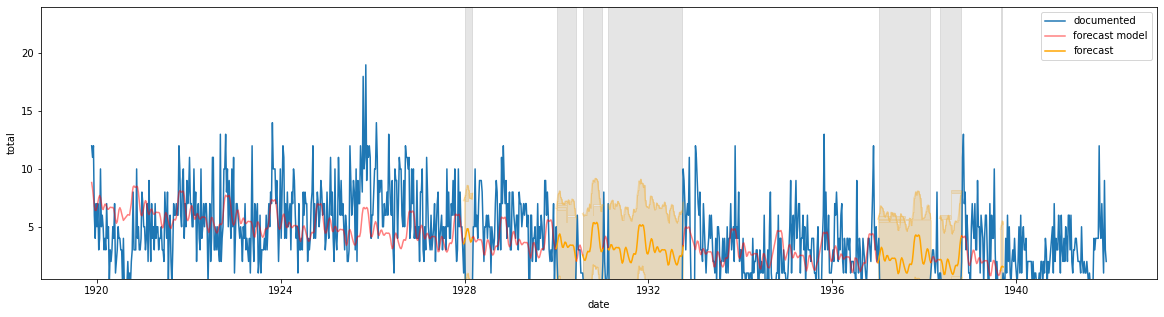

In [93]:
plot_newsubs_weekly_forecast(lognewsub_weeks_fcst, show_model=True)

### aggregate forecast values

In [94]:
%%capture
!pip install DateTimeRange

In [95]:
from datetimerange import DateTimeRange


onemonth = timedelta(days=31)
fivedays = timedelta(days=5)
oneday = timedelta(days=5)
oneweek = timedelta(days=7)

# newsub_member_total = len(subscription_first_events.member_id.unique())
# member_total = len(events_df.member_id.unique())

# allow overrides for aggregrating uniq name estimates
def aggregrate_missing_newsub_estimates(forecast_df, newmember_subscriptions_by_week=newmember_subscriptions_by_week, newsub_member_total=None, member_total=None):

  newsub_weekly_missing = 0
  newsub_weekly_missing_upper = 0
  newsub_weekly_missing_lower = 0

  if newsub_member_total is None:
    newsub_member_total = len(subscription_first_events.member_id.unique())
  if member_total is None:
    member_total = len(events_df.member_id.unique())


  newsub_weekly_estimates = []

  for i, gap in enumerate(logbook_gaps): 
    gap_start = gap['start']
    gap_end = gap['end']
    # print(gap_start, gap_end)
    # print('gap range ')
    gap_range = DateTimeRange(gap_start, gap_end)
    # print(gap_range)

    # get documented counts for this time period
    gap_counts = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date >= gap_start) & (newmember_subscriptions_by_week.date <= gap_end + oneweek)]
    # now get the forecast for the same weeks
    
    # weekly_forecast = newsub_weekly_forecasts_df[(newsub_weekly_forecasts_df.ds >= gap_start) & (newsub_weekly_forecasts_df.ds <= gap_end + oneweek)]

    weekly_forecast = forecast_df[(forecast_df.ds >= gap_start) & (forecast_df.ds <= gap_end + oneweek)]
    # print(weekly_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].head())

    for week in gap_counts.itertuples():
      week_start = week.date 

      # do logbook weeks and forecast weeks match?
      # missing estimate is the forecast value minus any actual recorded count for this day
      documented_week = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date == week.date]  #.iloc[0]
      # seems possible there's no documented week
      if documented_week.shape[0]:
        documented_week = documented_week.iloc[0]
      else: 
        documented_week = None

      # check if the padding put us past the end of the current gap
      if week_start > gap_end:
        continue

      # get the end of the same month (first of the next month minus one day)
      week_end = week_start + oneweek
      # how many days from this month overlap with our gap?
      gap_intersection = gap_range.intersection(DateTimeRange(week_start, week_end))
      overlap_days = gap_intersection.timedelta.days
      if overlap_days != 7:
        print('gap overlap for %s is %d days' % (week_end, overlap_days))
      # what is our threshold for using the forecast value instead of recorded? 
      # let's try 3 days
      if overlap_days > 3:
        week_total = 0
        if not documented_week.empty:
          week_total = week.total

        # get the forecast value for this week
        week_forecast = weekly_forecast[(weekly_forecast.ds >= week_start) & (weekly_forecast.ds <= week_end)].iloc[0]
        # missing estimate is the forecast value minus any actual recorded count for this month
        newsub_weekly_missing += max(0, (max(0, week_forecast.yhat) - week_total))
        newsub_weekly_missing_upper += (week_forecast.yhat_upper - week_total)
        # cap lower estimate at zero
        newsub_weekly_missing_lower += max(0, (max(0, week_forecast.yhat_lower) - week_total))

        # aggregate forecast values so we can output as csv for reference
        newsub_weekly_estimates.append({
            'date': week.date,
            'documented_total': week_total,
            'gap_days': overlap_days,
            'forecast': week_forecast.yhat,
            'forecast_upper': week_forecast.yhat_upper,
            'forecast_lower': week_forecast.yhat_lower,
            'forecast_range': week_forecast.yhat_upper - week_forecast.yhat_lower,
        })

        newsub_estimates_df = pd.DataFrame(newsub_weekly_estimates)
        newsub_estimates_df.to_csv('newsub_weekly_forecast.csv', index=False)

  print('''\n\nmissing estimates:
    %s
    upper: %s
    lower: %s''' % (newsub_weekly_missing, newsub_weekly_missing_upper, newsub_weekly_missing_lower))
  
  estimated_total = newsub_member_total + newsub_weekly_missing
  estimated_total_upper = newsub_member_total + newsub_weekly_missing_upper
  estimated_total_lower = newsub_member_total + newsub_weekly_missing_lower

  est_percent = (member_total / estimated_total ) * 100
  est_percent_upper = (member_total / estimated_total_upper ) * 100
  est_percent_lower = (member_total / estimated_total_lower ) * 100

  # summarize the result
  print('''
  total unique members: %d
  total members from first subscriptions: %d
  estimated missing subscriptions: %.2f (upper %.2f, lower %.2f)
  estimated total subscriptions from logbooks: %.2f (upper %.2f, lower %.2f)
  total missing: %d (upper %d, lower %d)
  estimated percent: %.2f (upper %.2f, lower %.2f)
  ''' % (member_total, newsub_member_total, 
         # estimated missing
          newsub_weekly_missing, newsub_weekly_missing_upper, newsub_weekly_missing_lower,
         # estimated total
          estimated_total, estimated_total_upper, estimated_total_lower, 
         # total missing
          max(0, estimated_total - member_total),
            estimated_total_upper - member_total,
          max(0, estimated_total_lower - member_total),
          est_percent, est_percent_upper, est_percent_lower
          ))
  
  # return (newsub_weekly_missing, newsub_weekly_missing_upper, newsub_weekly_missing_lower)
  
# newsub_missing, newsub_missing_upper, newsub_missing_lower = aggregrate_missing_newsub_estimates()

### summarize

In [96]:
# initial forecast, calculated the same way as membership activity
aggregrate_missing_newsub_estimates(newsub_weekly_forecasts)

gap overlap for 1928-03-04 00:00:00 is 3 days
gap overlap for 1930-06-08 00:00:00 is 0 days
gap overlap for 1931-01-04 00:00:00 is 3 days
gap overlap for 1932-10-02 00:00:00 is 0 days
gap overlap for 1938-02-20 00:00:00 is 3 days
gap overlap for 1938-10-23 00:00:00 is 4 days
gap overlap for 1939-09-17 00:00:00 is 2 days


missing estimates:
    459.35352816239197
    upper: 1136.1365018416288
    lower: 94.02469085899733

  total unique members: 5139
  total members from first subscriptions: 4320
  estimated missing subscriptions: 459.35 (upper 1136.14, lower 94.02)
  estimated total subscriptions from logbooks: 4779.35 (upper 5456.14, lower 4414.02)
  total missing: 0 (upper 317, lower 0)
  estimated percent: 107.53 (upper 94.19, lower 116.42)
  


In [97]:
# second forecast, fitting prophet on all data 
# - this result seems better than the first linear model
aggregrate_missing_newsub_estimates(newsub_weekly_forecasts_df)


gap overlap for 1928-03-04 00:00:00 is 3 days
gap overlap for 1930-06-08 00:00:00 is 0 days
gap overlap for 1931-01-04 00:00:00 is 3 days
gap overlap for 1932-10-02 00:00:00 is 0 days
gap overlap for 1938-02-20 00:00:00 is 3 days
gap overlap for 1938-10-23 00:00:00 is 4 days
gap overlap for 1939-09-17 00:00:00 is 2 days


missing estimates:
    498.92351611172603
    upper: 1230.081184620866
    lower: 32.972645546675395

  total unique members: 5139
  total members from first subscriptions: 4320
  estimated missing subscriptions: 498.92 (upper 1230.08, lower 32.97)
  estimated total subscriptions from logbooks: 4818.92 (upper 5550.08, lower 4352.97)
  total missing: 0 (upper 411, lower 0)
  estimated percent: 106.64 (upper 92.59, lower 118.06)
  


In [98]:
# third forecast, with logistic growth and cap
aggregrate_missing_newsub_estimates(newsub_weekly_growth_forecasts)

gap overlap for 1928-03-04 00:00:00 is 3 days
gap overlap for 1930-06-08 00:00:00 is 0 days
gap overlap for 1931-01-04 00:00:00 is 3 days
gap overlap for 1932-10-02 00:00:00 is 0 days
gap overlap for 1938-02-20 00:00:00 is 3 days
gap overlap for 1938-10-23 00:00:00 is 4 days
gap overlap for 1939-09-17 00:00:00 is 2 days


missing estimates:
    1030.2251804119082
    upper: 1731.8896065851477
    lower: 367.86717374828953

  total unique members: 5139
  total members from first subscriptions: 4320
  estimated missing subscriptions: 1030.23 (upper 1731.89, lower 367.87)
  estimated total subscriptions from logbooks: 5350.23 (upper 6051.89, lower 4687.87)
  total missing: 211 (upper 912, lower 0)
  estimated percent: 96.05 (upper 84.92, lower 109.62)
  


## new members by first subscription, aggregated by unique name

In [99]:
member_events.head()

event_type      member_id       date                   source_type
671    Subscription          cahun 1919-11-17  Lending Library Card;Logbook
29914  Subscription       worthing 1919-11-17                       Logbook
29915  Subscription  flot-marcelle 1919-11-17                       Logbook
672    Subscription        regnier 1919-11-18  Logbook;Lending Library Card
676    Subscription         ulmann 1919-11-18  Logbook;Lending Library Card

In [100]:
# member events doesn't include names, so join to get it back in

events_df[['member_id', 'member_names', 'member_sort_names']]

member_id         member_names     member_sort_names
0       linossier-raymonde   Raymonde Linossier   Linossier, Raymonde
1                  garreta          Mme Garreta          Garreta, Mme
2                     rhys             Mr. Rhys             Rhys, Mr.
3                    walsh         Ernest Walsh         Walsh, Ernest
4                lincoln-1          Mr. Lincoln          Lincoln, Mr.
...                    ...                  ...                   ...
35518        gutmann-henri        Henri Gutmann        Gutmann, Henri
35519  bernheim-antoinette  Antoinette Bernheim  Bernheim, Antoinette
35520           baldwin-mr          Mr. Baldwin          Baldwin, Mr.
35521  bernheim-antoinette  Antoinette Bernheim  Bernheim, Antoinette
35522           davies-m-a         M. A. Davies         Davies, M. A.

[35523 rows x 3 columns]

In [101]:
member_uniqname_events = pd.merge(member_events, events_df[['member_id', 'member_names']], on='member_id')

In [102]:
member_uniqname_events

event_type     member_id       date                   source_type  \
0         Subscription         cahun 1919-11-17  Lending Library Card;Logbook   
1         Subscription         cahun 1919-11-17  Lending Library Card;Logbook   
2         Subscription         cahun 1919-11-17  Lending Library Card;Logbook   
3         Subscription         cahun 1919-11-17  Lending Library Card;Logbook   
4               Borrow         cahun 1919-11-19          Lending Library Card   
...                ...           ...        ...                           ...   
6784391   Subscription        azgema 1941-12-06                       Logbook   
6784392   Subscription        godard 1941-12-09                       Logbook   
6784393   Subscription        godard 1941-12-09                       Logbook   
6784394        Renewal    kohlberg-8 1941-12-09                       Logbook   
6784395  Reimbursement  desraux-mlle 1941-12-22                       Logbook   

                             member_names  
0        Claude Cahun / Mlle Lucie Schwob  
1        Claude Cahun / Mlle Lucie Schwob  
2        Claude Cahun / Mlle Lucie Schwob  
3        Claude Cahun / Mlle Lucie Schwob  
4        Claude Cahun / Mlle Lucie Schwob  
...                                   ...  
6784391                            Azgema  
6784392                            Godard  
6784393                            Godard  
6784394                          Kohlberg  
6784395                      Mlle Desraux  

[6784396 rows x 5 columns]

In [103]:
# go back to member events, limit to logbooks AND by event type, then group and get first event for each member
subscription_uniqname_first_events = member_uniqname_events[member_uniqname_events.source_type.str.contains('Logbook') & member_uniqname_events.event_type.isin(['Subscription', 'Renewal'])].groupby("member_names").first().reset_index()
subscription_uniqname_first_events

member_names    event_type            member_id  \
0      "Friend of Mlle Pottecher"  Subscription  pottecher-friend-of   
1              "Friend of Renoir"  Subscription     friend-of-renoir   
2                      A. Bigorie  Subscription              bigorie   
3                       A. Clarke  Subscription             clarke-a   
4                   A. Derevianko  Subscription           derevianko   
...                           ...           ...                  ...   
3970                   van Altena  Subscription           van-altena   
3971                  van Leeuhof       Renewal          van-leeuhof   
3972                      van Zyl  Subscription              van-zyl   
3973               Édouard Roditi  Subscription       roditi-edouard   
3974  Étienne Benoist de Beaulieu  Subscription             beaulieu   

           date                   source_type  
0    1922-04-08                       Logbook  
1    1920-12-06                       Logbook  
2    1929-10-11                       Logbook  
3    1925-10-21          Logbook;Address Book  
4    1933-07-04          Logbook;Address Book  
...         ...                           ...  
3970 1934-05-12                       Logbook  
3971 1928-05-18                       Logbook  
3972 1935-10-25                       Logbook  
3973 1928-05-18  Logbook;Lending Library Card  
3974 1936-11-19          Logbook;Address Book  

[3975 rows x 5 columns]

In [104]:
# get new member monthly count based only on subscriptions, so we can forecast with prophet
newmember_uniqname_subscriptions_by_week = subscription_uniqname_first_events.groupby([pd.Grouper(key='date', freq='W')])['member_names'].count().reset_index()
newmember_uniqname_subscriptions_by_week.rename(columns={'member_names': 'total'}, inplace=True)
newmember_uniqname_subscriptions_by_week

date  total
0    1919-11-23     12
1    1919-11-30     11
2    1919-12-07     12
3    1919-12-14      6
4    1919-12-21      4
...         ...    ...
1147 1941-11-16      4
1148 1941-11-23      1
1149 1941-11-30      9
1150 1941-12-07      3
1151 1941-12-14      1

[1152 rows x 2 columns]

### prophet on new subscriptions by uniq name

In [105]:
from datetime import date, timedelta
import math

from prophet import Prophet

post1932 = pd.to_datetime(date(1932, 9, 27))


def growth_forecast_missing_uniqname_newsubs():
  # show some number of months before/after the gap and forecast
  oneweek = timedelta(days=7)
  sixweeks = timedelta(days=7*6)

  # lists to aggregate forecasts and models
  all_newsub_weekly_forecasts_dfs = []

  # there's a significant difference between 1920s and 1930s data,
  # and there's a big gap in 1931-1932
  # for gaps after 1936, only include counts after the 1932 gap
  #   February 16 1931 to September 26 1932 (588 days)
  #   December 31 1936 to February 17 1938 (413 days)

  post1932 = pd.to_datetime(date(1932, 9, 27))

  # use largest week across all data as our growth cap
  growth_cap = newmember_uniqname_subscriptions_by_week.total.max()
  print('max from all data is %s' % growth_cap)


  for i, gap in enumerate(logbook_gaps):
    weekly_m = Prophet(growth='logistic', weekly_seasonality=True)  # use logistic growth instead of linear
    gap_start = gap['start']
    gap_end = gap['end']
    print('forecasting %s' % gap)

    preceding_data = newmember_uniqname_subscriptions_by_week[newmember_uniqname_subscriptions_by_week.date < gap_start]

    # for late gaps, only include counts after september 1932
    if gap_start.year >= 1936:
      preceding_data = preceding_data[preceding_data.date >= post1932 ]

    # drop any zeroes, so prophet doesn't fit to missing data
    preceding_data = preceding_data[preceding_data.total.gt(0)]

    # rename monthly count columns for prophet and fit the data
    data_to_fit = preceding_data.rename(columns={'date': 'ds', 'total': 'y'})
    data_to_fit['floor'] = 0
    # (should this be max from current data or next? or both? or all?)
    data_to_fit['cap'] = growth_cap
    weekly_m.fit(data_to_fit)

    # make a future dataframe to cover the gap 
    # (need at least 1 extra; may want to add more while testing)
    forecast_for = math.ceil(gap['days']/ 7) + 7
    print('gap is %s days, forecast for %d weeks' % (gap['days'], forecast_for))
    newsub_weeks_future = weekly_m.make_future_dataframe(periods=forecast_for, freq='W')

    # post_gap_data = newmember_subscriptions_by_week[newmember_subscriptions_by_week.date > gap_end][newmember_subscriptions_by_week.date < (gap_end + sixweeks)]
    newsub_weeks_future['floor'] = 0
    newsub_weeks_future['cap'] = growth_cap
    newsub_weeks_fcst = weekly_m.predict(newsub_weeks_future)

    # plot the forecast around our gap
    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]
    display(forecast_near_gap.head())
    # all_gap_forecasts_dfs.append(forecast_near_gap)

    newsub_weekly_count_near_gap = newmember_subscriptions_by_week[(newmember_subscriptions_by_week.date > (gap_start - oneweek)) & (newmember_subscriptions_by_week.date < (gap_end + oneweek))]

    forecast_near_gap = newsub_weeks_fcst[(newsub_weeks_fcst.ds > (gap_start - oneweek)) & (newsub_weeks_fcst.ds < (gap_end + oneweek))]

    all_newsub_weekly_forecasts_dfs.append(newsub_weeks_fcst.copy())

  # combine all the forecasts into a single df
  newsub_weekly_forecasts_dfs = pd.concat(all_newsub_weekly_forecasts_dfs)
  # all_gap_forecasts = pd.concat(all_gap_forecasts_dfs)

  return newsub_weekly_forecasts_dfs


uniqname_newsub_weekly_growth_forecasts = growth_forecast_missing_uniqname_newsubs()
uniqname_newsub_weekly_growth_forecasts

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


max from all data is 19
forecasting {'start': Timestamp('1928-01-01 00:00:00'), 'end': Timestamp('1928-02-29 00:00:00'), 'days': 59}
gap is 59 days, forecast for 16 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
412 1928-01-01  0.005295   19      0    1.833833    8.429138     0.005295   
413 1928-01-08  0.005253   19      0    2.126479    8.952294     0.005253   
414 1928-01-15  0.005211   19      0    2.614841    9.693293     0.005211   
415 1928-01-22  0.005170   19      0    3.244743   10.298092     0.005170   
416 1928-01-29  0.005129   19      0    3.474210   10.359220     0.005129   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
412     0.005295        5.220139              5.220139  ...  5.640884   
413     0.005253        5.514949              5.514949  ...  5.640884   
414     0.005211        6.070229              6.070229  ...  5.640884   
415     0.005170        6.681576              6.681576  ...  5.640884   
416     0.005129        6.881021              6.881021  ...  5.640884   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
412      5.640884      5.640884 -0.420745     -0.420745     -0.420745   
413      5.640884      5.640884 -0.125935     -0.125935     -0.125935   
414      5.640884      5.640884  0.429345      0.429345      0.429345   
415      5.640884      5.640884  1.040691      1.040691      1.040691   
416      5.640884      5.640884  1.240137      1.240137      1.240137   

     multiplicative_terms  multiplicative_terms_lower  \
412                   0.0                         0.0   
413                   0.0                         0.0   
414                   0.0                         0.0   
415                   0.0                         0.0   
416                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
412                         0.0  5.225434  
413                         0.0  5.520202  
414                         0.0  6.075440  
415                         0.0  6.686746  
416                         0.0  6.886150  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-01-03 00:00:00'), 'end': Timestamp('1930-06-01 00:00:00'), 'days': 149}
gap is 149 days, forecast for 29 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
504 1929-12-29  9.474003   19      0    1.757289    8.077990     9.474003   
505 1930-01-05  9.473905   19      0    1.962354    8.575681     9.473905   
506 1930-01-12  9.473807   19      0    2.501167    8.941320     9.473807   
507 1930-01-19  9.473709   19      0    2.906886    9.774126     9.473709   
508 1930-01-26  9.473611   19      0    3.630067    9.964713     9.473611   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
504     9.474003       -4.497640             -4.497640  ... -3.909111   
505     9.473905       -4.267153             -4.267153  ... -3.909111   
506     9.473807       -3.696202             -3.696202  ... -3.909111   
507     9.473709       -2.997369             -2.997369  ... -3.909111   
508     9.473611       -2.643619             -2.643619  ... -3.909111   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
504     -3.909111     -3.909111 -0.588528     -0.588528     -0.588528   
505     -3.909111     -3.909111 -0.358042     -0.358042     -0.358042   
506     -3.909111     -3.909111  0.212909      0.212909      0.212909   
507     -3.909111     -3.909111  0.911742      0.911742      0.911742   
508     -3.909111     -3.909111  1.265492      1.265492      1.265492   

     multiplicative_terms  multiplicative_terms_lower  \
504                   0.0                         0.0   
505                   0.0                         0.0   
506                   0.0                         0.0   
507                   0.0                         0.0   
508                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
504                         0.0  4.976364  
505                         0.0  5.206752  
506                         0.0  5.777605  
507                         0.0  6.476340  
508                         0.0  6.829992  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1930-08-01 00:00:00'), 'end': Timestamp('1930-12-31 00:00:00'), 'days': 152}
gap is 152 days, forecast for 29 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
515 1930-07-27  0.008226   19      0    1.141082    8.044035     0.008226   
516 1930-08-03  0.008178   19      0    1.259024    7.706423     0.008178   
517 1930-08-10  0.008130   19      0    0.960643    7.315287     0.008130   
518 1930-08-17  0.008082   19      0    0.911792    7.375433     0.008082   
519 1930-08-24  0.008034   19      0    1.496667    7.873007     0.008034   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
515     0.008226        4.627571              4.627571  ...  5.462948   
516     0.008178        4.487708              4.487708  ...  5.462948   
517     0.008130        4.257874              4.257874  ...  5.462948   
518     0.008082        4.173191              4.173191  ...  5.462948   
519     0.008034        4.464296              4.464296  ...  5.462948   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
515      5.462948      5.462948 -0.835378     -0.835378     -0.835378   
516      5.462948      5.462948 -0.975240     -0.975240     -0.975240   
517      5.462948      5.462948 -1.205074     -1.205074     -1.205074   
518      5.462948      5.462948 -1.289757     -1.289757     -1.289757   
519      5.462948      5.462948 -0.998652     -0.998652     -0.998652   

     multiplicative_terms  multiplicative_terms_lower  \
515                   0.0                         0.0   
516                   0.0                         0.0   
517                   0.0                         0.0   
518                   0.0                         0.0   
519                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
515                         0.0  4.635797  
516                         0.0  4.495886  
517                         0.0  4.266004  
518                         0.0  4.181273  
519                         0.0  4.472330  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1931-02-17 00:00:00'), 'end': Timestamp('1932-09-25 00:00:00'), 'days': 586}
gap is 586 days, forecast for 91 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
520 1931-02-15  9.162158   19      0    1.448686    8.054797     9.162158   
521 1931-02-22  9.161152   19      0    1.771462    8.002693     9.161152   
522 1931-03-01  9.160145   19      0    1.570664    8.414322     9.160145   
523 1931-03-08  9.159138   19      0    1.864905    8.672727     9.159138   
524 1931-03-15  9.158132   19      0    1.667441    8.242315     9.158132   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
520     9.162158       -4.366589             -4.366589  ... -3.941836   
521     9.161152       -4.416192             -4.416192  ... -3.941836   
522     9.160145       -4.080031             -4.080031  ... -3.941836   
523     9.159138       -3.933020             -3.933020  ... -3.941836   
524     9.158132       -4.234198             -4.234198  ... -3.941836   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
520     -3.941836     -3.941836 -0.424754     -0.424754     -0.424754   
521     -3.941836     -3.941836 -0.474356     -0.474356     -0.474356   
522     -3.941836     -3.941836 -0.138196     -0.138196     -0.138196   
523     -3.941836     -3.941836  0.008815      0.008815      0.008815   
524     -3.941836     -3.941836 -0.292362     -0.292362     -0.292362   

     multiplicative_terms  multiplicative_terms_lower  \
520                   0.0                         0.0   
521                   0.0                         0.0   
522                   0.0                         0.0   
523                   0.0                         0.0   
524                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
520                         0.0  4.795569  
521                         0.0  4.744960  
522                         0.0  5.080114  
523                         0.0  5.226118  
524                         0.0  4.923934  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1937-01-01 00:00:00'), 'end': Timestamp('1938-02-16 00:00:00'), 'days': 411}
gap is 411 days, forecast for 66 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
180 1936-12-27  6.761106   19      0   -0.666167    4.953615     6.761106   
181 1937-01-03  6.754150   19      0    0.042253    5.811815     6.754150   
182 1937-01-10  6.747197   19      0    0.787635    6.419456     6.747197   
183 1937-01-17  6.740247   19      0    1.310058    6.910373     6.740247   
184 1937-01-24  6.733300   19      0    1.510098    7.281153     6.733300   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
180     6.761106       -4.716774             -4.716774  ... -4.079414   
181     6.754150       -4.056921             -4.056921  ... -4.079414   
182     6.747197       -3.325159             -3.325159  ... -4.079414   
183     6.740247       -2.695898             -2.695898  ... -4.079414   
184     6.733301       -2.442948             -2.442948  ... -4.079414   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
180     -4.079414     -4.079414 -0.637360     -0.637360     -0.637360   
181     -4.079414     -4.079414  0.022493      0.022493      0.022493   
182     -4.079414     -4.079414  0.754255      0.754255      0.754255   
183     -4.079414     -4.079414  1.383516      1.383516      1.383516   
184     -4.079414     -4.079414  1.636466      1.636466      1.636466   

     multiplicative_terms  multiplicative_terms_lower  \
180                   0.0                         0.0   
181                   0.0                         0.0   
182                   0.0                         0.0   
183                   0.0                         0.0   
184                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
180                         0.0  2.044332  
181                         0.0  2.697229  
182                         0.0  3.422038  
183                         0.0  4.044349  
184                         0.0  4.290353  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1938-05-06 00:00:00'), 'end': Timestamp('1938-10-20 00:00:00'), 'days': 167}
gap is 167 days, forecast for 31 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
191 1938-05-01  0.133285   19      0   -0.487562    4.515084     0.133285   
192 1938-05-08  0.132023   19      0   -0.384947    4.998846     0.132023   
193 1938-05-15  0.130772   19      0   -0.159174    5.056595     0.130772   
194 1938-05-22  0.129534   19      0   -0.388153    4.928990     0.129534   
195 1938-05-29  0.128307   19      0   -0.864419    4.259940     0.128307   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
191     0.133285        1.942704              1.942704  ...  2.596817   
192     0.132023        2.259471              2.259471  ...  2.596817   
193     0.130772        2.449856              2.449856  ...  2.596817   
194     0.129534        2.238572              2.238572  ...  2.596817   
195     0.128307        1.652229              1.652229  ...  2.596817   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
191      2.596817      2.596817 -0.654114     -0.654114     -0.654114   
192      2.596817      2.596817 -0.337346     -0.337346     -0.337346   
193      2.596817      2.596817 -0.146961     -0.146961     -0.146961   
194      2.596817      2.596817 -0.358246     -0.358246     -0.358246   
195      2.596817      2.596817 -0.944588     -0.944588     -0.944588   

     multiplicative_terms  multiplicative_terms_lower  \
191                   0.0                         0.0   
192                   0.0                         0.0   
193                   0.0                         0.0   
194                   0.0                         0.0   
195                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
191                         0.0  2.075989  
192                         0.0  2.391494  
193                         0.0  2.580628  
194                         0.0  2.368105  
195                         0.0  1.780536  

[5 rows x 21 columns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


forecasting {'start': Timestamp('1939-08-29 00:00:00'), 'end': Timestamp('1939-09-12 00:00:00'), 'days': 14}
gap is 14 days, forecast for 9 weeks


ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
233 1939-08-27  0.258189   19      0    0.262857    5.834496     0.258189   
234 1939-09-03  0.256902   19      0   -0.591373    5.306985     0.256902   
235 1939-09-10  0.255622   19      0   -1.497478    4.389931     0.255622   
236 1939-09-17  0.254348   19      0   -1.476861    4.309842     0.254348   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
233     0.258189        2.821459              2.821459  ...  2.706633   
234     0.256903        2.097934              2.097934  ...  2.706633   
235     0.255622        1.240357              1.240357  ...  2.706633   
236     0.254348        1.103565              1.103565  ...  2.706633   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
233      2.706633      2.706633  0.114826      0.114826      0.114826   
234      2.706633      2.706633 -0.608699     -0.608699     -0.608699   
235      2.706633      2.706633 -1.466276     -1.466276     -1.466276   
236      2.706633      2.706633 -1.603068     -1.603068     -1.603068   

     multiplicative_terms  multiplicative_terms_lower  \
233                   0.0                         0.0   
234                   0.0                         0.0   
235                   0.0                         0.0   
236                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
233                         0.0  3.079648  
234                         0.0  2.354836  
235                         0.0  1.495979  
236                         0.0  1.357913  

[4 rows x 21 columns]

ds     trend  cap  floor  yhat_lower  yhat_upper  trend_lower  \
0   1919-11-23  0.151181   19      0    4.647994   11.251473     0.151181   
1   1919-11-30  0.149994   19      0    3.836845   10.597786     0.149994   
2   1919-12-07  0.148817   19      0    2.735531    9.632101     0.148817   
3   1919-12-14  0.147649   19      0    2.329814    8.932492     0.147649   
4   1919-12-21  0.146490   19      0    1.993298    8.616475     0.146490   
..         ...       ...  ...    ...         ...         ...          ...   
234 1939-09-03  0.256902   19      0   -0.591373    5.306985     0.256902   
235 1939-09-10  0.255622   19      0   -1.497478    4.389931     0.255622   
236 1939-09-17  0.254348   19      0   -1.476861    4.309842     0.254348   
237 1939-09-24  0.253080   19      0   -0.875946    4.973884     0.253080   
238 1939-10-01  0.251818   19      0    0.274455    5.701702     0.251818   

     trend_upper  additive_terms  additive_terms_lower  ...    weekly  \
0       0.151181        7.664279              7.664279  ...  5.640884   
1       0.149994        6.978280              6.978280  ...  5.640884   
2       0.148817        6.042899              6.042899  ...  5.640884   
3       0.147649        5.367428              5.367428  ...  5.640884   
4       0.146490        5.120115              5.120115  ...  5.640884   
..           ...             ...                   ...  ...       ...   
234     0.256903        2.097934              2.097934  ...  2.706633   
235     0.255622        1.240357              1.240357  ...  2.706633   
236     0.254348        1.103565              1.103565  ...  2.706633   
237     0.253080        1.826897              1.826897  ...  2.706633   
238     0.251819        2.779653              2.779653  ...  2.706633   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0        5.640884      5.640884  2.023395      2.023395      2.023395   
1        5.640884      5.640884  1.337396      1.337396      1.337396   
2        5.640884      5.640884  0.402014      0.402014      0.402014   
3        5.640884      5.640884 -0.273456     -0.273456     -0.273456   
4        5.640884      5.640884 -0.520769     -0.520769     -0.520769   
..            ...           ...       ...           ...           ...   
234      2.706633      2.706633 -0.608699     -0.608699     -0.608699   
235      2.706633      2.706633 -1.466276     -1.466276     -1.466276   
236      2.706633      2.706633 -1.603068     -1.603068     -1.603068   
237      2.706633      2.706633 -0.879737     -0.879737     -0.879737   
238      2.706633      2.706633  0.073019      0.073019      0.073019   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
234                   0.0                         0.0   
235                   0.0                         0.0   
236                   0.0                         0.0   
237                   0.0                         0.0   
238                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
0                           0.0  7.815460  
1                           0.0  7.128274  
2                           0.0  6.191716  
3                           0.0  5.515077  
4                           0.0  5.266605  
..                          ...       ...  
234                         0.0  2.354836  
235                         0.0  1.495979  
236                         0.0  1.357913  
237                         0.0  2.079977  
238                         0.0  3.031471  

[2828 rows x 21 columns]

<Figure size 432x288 with 0 Axes>

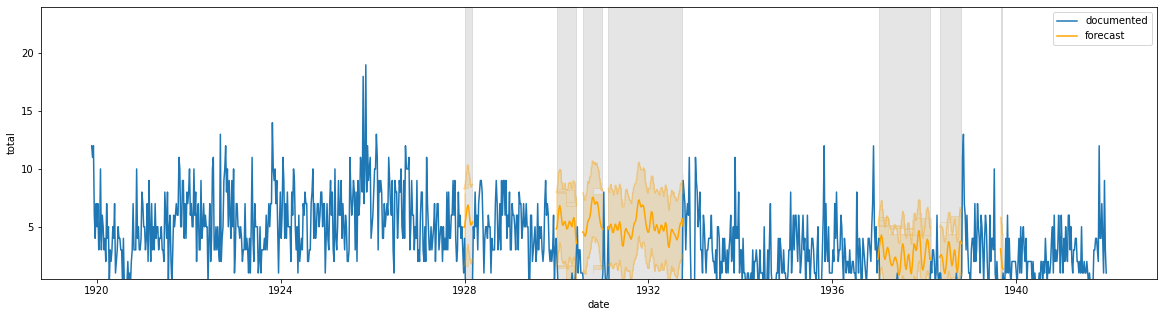

In [106]:
plot_newsubs_weekly_forecast(uniqname_newsub_weekly_growth_forecasts, show_model=False, separate_model_decades=False, newmember_subscriptions_by_week=newmember_uniqname_subscriptions_by_week)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Figure size 432x288 with 0 Axes>

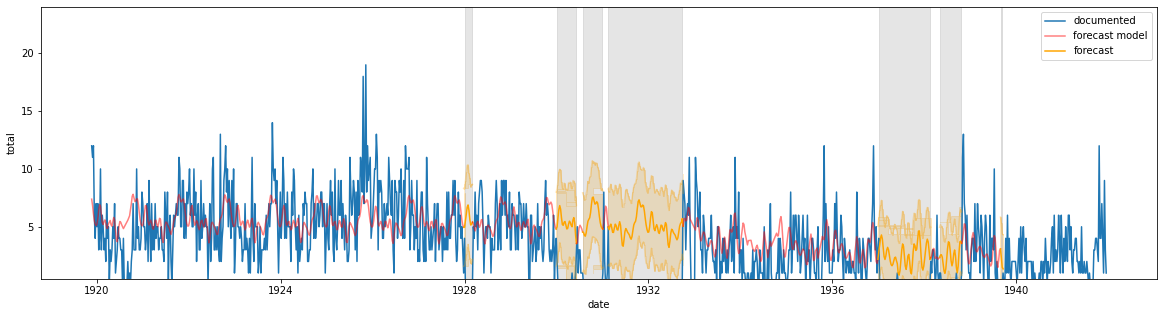

In [107]:
plot_newsubs_weekly_forecast(uniqname_newsub_weekly_growth_forecasts, show_model=True, separate_model_decades=False, newmember_subscriptions_by_week=newmember_uniqname_subscriptions_by_week)


### summarize


In [108]:
uniqname_newsub_member_total = len(subscription_uniqname_first_events.member_names.unique())
uniqname_newsub_member_total

3975

In [109]:
uniqname_member_total = len(events_df.member_names.unique())
uniqname_member_total

4720

In [110]:

aggregrate_missing_newsub_estimates(uniqname_newsub_weekly_growth_forecasts, newmember_subscriptions_by_week=newmember_uniqname_subscriptions_by_week, newsub_member_total=uniqname_newsub_member_total, member_total=uniqname_member_total)


gap overlap for 1928-03-04 00:00:00 is 3 days
gap overlap for 1930-06-08 00:00:00 is 0 days
gap overlap for 1931-01-04 00:00:00 is 3 days
gap overlap for 1932-10-02 00:00:00 is 0 days
gap overlap for 1938-02-20 00:00:00 is 3 days
gap overlap for 1938-10-23 00:00:00 is 4 days
gap overlap for 1939-09-17 00:00:00 is 2 days


missing estimates:
    897.0643818583792
    upper: 1558.8033738867168
    lower: 281.96358675374705

  total unique members: 4720
  total members from first subscriptions: 3975
  estimated missing subscriptions: 897.06 (upper 1558.80, lower 281.96)
  estimated total subscriptions from logbooks: 4872.06 (upper 5533.80, lower 4256.96)
  total missing: 152 (upper 813, lower 0)
  estimated percent: 96.88 (upper 85.29, lower 110.88)
  


## recalculate Kevin's simpler missing member estimate


In [111]:
total_accounts = len(events_df.member_uris.unique())
total_logbook_accounts = len(logbook_events_df.member_uris.unique())
total_logbook_events = logbook_events_df.shape[0]

# new member per logbook event
n_accounts_per_logbook_event = total_logbook_accounts / total_logbook_events

# estimated total number of logbook events
# from prophet:
#  13,955 events (upper 15,220; lower 12,358
# from KM estimate: 13,597

est_total_logbook_events = 13955
est_total_logbook_events_upper = 15220
est_total_logbook_events_lower = 12358


est_logbook_accounts = est_total_logbook_events * n_accounts_per_logbook_event
est_logbook_accounts_upper = est_total_logbook_events_upper * n_accounts_per_logbook_event
est_logbook_accounts_lower = est_total_logbook_events_lower * n_accounts_per_logbook_event


n_missing_accounts = int(est_logbook_accounts - total_accounts)
n_missing_accounts_upper = int(est_logbook_accounts_upper - total_accounts)
n_missing_accounts_lower = int(est_logbook_accounts_lower - total_accounts)


# how many accounts do we have 
percent_surviving_accounts = (total_accounts / est_logbook_accounts) * 100
percent_surviving_accounts_upper = (total_accounts / est_logbook_accounts_upper) * 100
percent_surviving_accounts_lower = (total_accounts / est_logbook_accounts_lower) * 100


print("""
total accounts: %d
total accounts from logbooks: %d:
total logbook events: %d
new member per logbook event: %.2f
est total members from logbooks: %.2f (upper %.2f, lower %.2f)
est missing accounts: %.2f (upper %.2f, lower %.2f)
percent covered: %.2f (upper %.2f, lower %.2f)
percent missing: 
""" % (
    total_accounts,
    total_logbook_accounts,
    total_logbook_events,
    n_accounts_per_logbook_event,
    # est total members
    est_logbook_accounts, est_logbook_accounts_upper, est_logbook_accounts_lower,
    n_missing_accounts, n_missing_accounts_upper, n_missing_accounts_lower,
    percent_surviving_accounts, percent_surviving_accounts_upper, percent_surviving_accounts_lower
))


total accounts: 5139
total accounts from logbooks: 4604:
total logbook events: 11601
new member per logbook event: 0.40
est total members from logbooks: 5538.21 (upper 6040.24, lower 4904.42)
est missing accounts: 399.00 (upper 901.00, lower -234.00)
percent covered: 92.79 (upper 85.08, lower 104.78)
percent missing: 



In [112]:
len(events_df.member_uris.unique())

5139

In [113]:
len(events_df.member_names.unique())  # use this one, since it includes titles and merges slightly fewer accounts

4720

In [114]:
len(events_df.member_sort_names.unique())

4714

In [115]:
def simple_missing_member_est_collapsed():
  # group by name instead of id
  total_accounts = len(events_df.member_names.unique())
  total_logbook_accounts = len(logbook_events_df.member_names.unique())
  total_logbook_events = logbook_events_df.shape[0]

  # new member per logbook event
  n_accounts_per_logbook_event = total_logbook_accounts / total_logbook_events

  # estimated total number of logbook events
  # from prophet:
  #  13,955 events (upper 15,220; lower 12,358
  # from KM estimate: 13,597

  est_total_logbook_events = 13955
  est_total_logbook_events_upper = 15220
  est_total_logbook_events_lower = 12358


  est_logbook_accounts = est_total_logbook_events * n_accounts_per_logbook_event
  est_logbook_accounts_upper = est_total_logbook_events_upper * n_accounts_per_logbook_event
  est_logbook_accounts_lower = est_total_logbook_events_lower * n_accounts_per_logbook_event


  n_missing_accounts = int(est_logbook_accounts - total_accounts)
  n_missing_accounts_upper = int(est_logbook_accounts_upper - total_accounts)
  n_missing_accounts_lower = int(est_logbook_accounts_lower - total_accounts)


  # how many accounts do we have 
  percent_surviving_accounts = (total_accounts / est_logbook_accounts) * 100
  percent_surviving_accounts_upper = (total_accounts / est_logbook_accounts_upper) * 100
  percent_surviving_accounts_lower = (total_accounts / est_logbook_accounts_lower) * 100


  print("""
  ** counting by unique name instead of member id**
  total accounts: %d
  total accounts from logbooks: %d:
  total logbook events: %d
  new member per logbook event: %.2f
  est total members from logbooks: %.2f (upper %.2f, lower %.2f)
  est missing accounts: %.2f (upper %.2f, lower %.2f)
  percent covered: %.2f (upper %.2f, lower %.2f)
  """ % (
      total_accounts,
      total_logbook_accounts,
      total_logbook_events,
      n_accounts_per_logbook_event,
      # est total members
      est_logbook_accounts, est_logbook_accounts_upper, est_logbook_accounts_lower,
      n_missing_accounts, n_missing_accounts_upper, n_missing_accounts_lower,
      percent_surviving_accounts, percent_surviving_accounts_upper, percent_surviving_accounts_lower
  ))


simple_missing_member_est_collapsed()


  ** counting by unique name instead of member id**
  total accounts: 4720
  total accounts from logbooks: 4200:
  total logbook events: 11601
  new member per logbook event: 0.36
  est total members from logbooks: 5052.24 (upper 5510.21, lower 4474.06)
  est missing accounts: 332.00 (upper 790.00, lower -245.00)
  percent covered: 93.42 (upper 85.66, lower 105.50)
  


In [116]:
# why is Kevin's number for unique members different than mine? more than just shared accounts

members_df = pd.read_csv(csv_urls['members'])

In [117]:
members_df.uri.describe()

count                                                  5235
unique                                                 5235
top       https://shakespeareandco.princeton.edu/members...
freq                                                      1
Name: uri, dtype: object

In [118]:
events_df.member_uris.describe()

count                                                 35523
unique                                                 5139
top       https://shakespeareandco.princeton.edu/members...
freq                                                   1523
Name: member_uris, dtype: object

In [119]:
events_df[events_df.member_uris.str.contains(';')].member_uris.describe()

count                                                   557
unique                                                   49
top       https://shakespeareandco.princeton.edu/members...
freq                                                    256
Name: member_uris, dtype: object

In [120]:
# unique accounts from events + number of shared events
5139 + 49

5188

In [121]:
# where is the difference between that number and the 5235 total from members dataset?

# missing borrowing activity

In [122]:
# subset data for only those with complete start and end dates
date_events = events_df[(events_df.start_date.str.len() > 9) & (events_df.end_date.str.len() > 9)].copy()
# turn start/end dates into datetimes
date_events['start_datetime'] = pd.to_datetime(date_events.start_date, format='%Y-%m-%d', errors='ignore')
date_events['end_datetime'] = pd.to_datetime(date_events.end_date, format='%Y-%m-%d', errors='ignore')
date_events = date_events.sort_values(by=['start_datetime'])
date_events.head()

event_type  start_date    end_date  \
671    Subscription  1919-11-17  1919-12-17   
29915  Subscription  1919-11-17  1920-11-17   
29914  Subscription  1919-11-17  1920-02-17   
674          Borrow  1919-11-18  1919-11-28   
29916  Subscription  1919-11-18  1920-05-18   

                                             member_uris  \
671    https://shakespeareandco.princeton.edu/members...   
29915  https://shakespeareandco.princeton.edu/members...   
29914  https://shakespeareandco.princeton.edu/members...   
674    https://shakespeareandco.princeton.edu/members...   
29916  https://shakespeareandco.princeton.edu/members...   

                           member_names member_sort_names  \
671    Claude Cahun / Mlle Lucie Schwob     Cahun, Claude   
29915                     Marcelle Flot    Flot, Marcelle   
29914                     Mrs. Worthing    Worthing, Mrs.   
674                       Denise Ulmann    Ulmann, Denise   
29916                        Anne Evans       Evans, Anne   

       subscription_price_paid  subscription_deposit subscription_duration  \
671                        4.0                   NaN               1 month   
29915                     28.0                   NaN                1 year   
29914                     12.0                   NaN              3 months   
674                        NaN                   NaN                   NaN   
29916                     35.0                  14.0              6 months   

       subscription_duration_days  ...                   source_type  \
671                          30.0  ...  Lending Library Card;Logbook   
29915                       366.0  ...                       Logbook   
29914                        92.0  ...                       Logbook   
674                           NaN  ...          Lending Library Card   
29916                       182.0  ...                       Logbook   

                                         source_citation  \
671    Sylvia Beach, Lucie Schwob Lending Library Car...   
29915  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
29914  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
674    Sylvia Beach, Mlle Denise Ulmann Lending Libra...   
29916  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   

                                         source_manifest  \
671    https://figgy.princeton.edu/concern/scanned_re...   
29915                                                NaN   
29914                                                NaN   
674    https://figgy.princeton.edu/concern/scanned_re...   
29916                                                NaN   

                                            source_image  \
671    https://iiif.princeton.edu/loris/figgy_prod/3a...   
29915                                                NaN   
29914                                                NaN   
674    https://iiif.princeton.edu/loris/figgy_prod/86...   
29916                                                NaN   

                                        first_member_uri  second_member_uri  \
671    https://shakespeareandco.princeton.edu/members...               None   
29915  https://shakespeareandco.princeton.edu/members...               None   
29914  https://shakespeareandco.princeton.edu/members...               None   
674    https://shakespeareandco.princeton.edu/members...               None   
29916  https://shakespeareandco.princeton.edu/members...               None   

           member_id          item_id start_datetime end_datetime  
671            cahun             None     1919-11-17   1919-12-17  
29915  flot-marcelle             None     1919-11-17   1920-11-17  
29914       worthing             None     1919-11-17   1920-02-17  
674           ulmann  wilde-profundis     1919-11-18   1919-11-28  
29916     evans-anne             None     1919-11-18   1920-05-18  

[5 rows x 34 columns]

In [123]:
# borrow events 
borrow_events = date_events[date_events.event_type == 'Borrow']

# subset data for subscription events with complete dates
subscription_events = date_events[date_events.event_type.isin(['Subscription', 'Renewal', 'Supplement'])].copy()

In [124]:
# some subscriptions (~377) do not have subscription volume documented;
# subscription volume is 1 at minumim
subscription_events["subscription_volumes"] = subscription_events.subscription_volumes.apply(lambda x: x if pd.notna(x) else 1)

In [125]:
# date range for subscriptions
earliest_date = date_events.start_datetime.iloc[0]
# end date for the last subscription
subs_end_date = subscription_events.end_datetime.max()

In [126]:
# load members
members_df = pd.read_csv(csv_urls['members'])

# for now, use has card to identify borrows that belong to subscriptions (but this is approximate)
member_subs = subscription_events.copy()
member_subs[['first_member_uri','second_member_uri']] = member_subs.member_uris.str.split(';', expand=True)
# handle multiple member uris (joint accounts) in subscriptions by merging on the first one (has card should be same)
member_subs = pd.merge(left=member_subs, right=members_df, left_on="first_member_uri", right_on="uri")
member_subs = member_subs[member_subs.has_card]


In [127]:
# make a copy of the dataframe so pandas won't complain about setting values on a slice
subscriptions_df = subscription_events.copy()

def borrows_within_sub(subscription):
  # identify and count any borrow events that *start* during this subscription
  # (do we want start or any overlap? start matters more when estimating book events)
  return len(borrow_events[(borrow_events.member_id == subscription.member_id) & 
              (subscription.start_date <= borrow_events.start_date) & (borrow_events.start_date <= subscription.end_date)])

subscriptions_df['documented_borrows'] = subscriptions_df.apply(borrows_within_sub, axis=1)
subscriptions_df.head()

event_type  start_date    end_date  \
671    Subscription  1919-11-17  1919-12-17   
29915  Subscription  1919-11-17  1920-11-17   
29914  Subscription  1919-11-17  1920-02-17   
29916  Subscription  1919-11-18  1920-05-18   
672    Subscription  1919-11-18  1919-12-18   

                                             member_uris  \
671    https://shakespeareandco.princeton.edu/members...   
29915  https://shakespeareandco.princeton.edu/members...   
29914  https://shakespeareandco.princeton.edu/members...   
29916  https://shakespeareandco.princeton.edu/members...   
672    https://shakespeareandco.princeton.edu/members...   

                           member_names member_sort_names  \
671    Claude Cahun / Mlle Lucie Schwob     Cahun, Claude   
29915                     Marcelle Flot    Flot, Marcelle   
29914                     Mrs. Worthing    Worthing, Mrs.   
29916                        Anne Evans       Evans, Anne   
672                       Henri Regnier    Regnier, Henri   

       subscription_price_paid  subscription_deposit subscription_duration  \
671                        4.0                   NaN               1 month   
29915                     28.0                   NaN                1 year   
29914                     12.0                   NaN              3 months   
29916                     35.0                  14.0              6 months   
672                        4.0                   5.6               1 month   

       subscription_duration_days  ...  \
671                          30.0  ...   
29915                       366.0  ...   
29914                        92.0  ...   
29916                       182.0  ...   
672                          30.0  ...   

                                         source_citation  \
671    Sylvia Beach, Lucie Schwob Lending Library Car...   
29915  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
29914  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
29916  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
672    Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   

                                         source_manifest  \
671    https://figgy.princeton.edu/concern/scanned_re...   
29915                                                NaN   
29914                                                NaN   
29916                                                NaN   
672    ;https://figgy.princeton.edu/concern/scanned_r...   

                                            source_image  \
671    https://iiif.princeton.edu/loris/figgy_prod/3a...   
29915                                                NaN   
29914                                                NaN   
29916                                                NaN   
672    ;https://iiif.princeton.edu/loris/figgy_prod/c...   

                                        first_member_uri second_member_uri  \
671    https://shakespeareandco.princeton.edu/members...              None   
29915  https://shakespeareandco.princeton.edu/members...              None   
29914  https://shakespeareandco.princeton.edu/members...              None   
29916  https://shakespeareandco.princeton.edu/members...              None   
672    https://shakespeareandco.princeton.edu/members...              None   

           member_id  item_id start_datetime end_datetime documented_borrows  
671            cahun     None     1919-11-17   1919-12-17                  3  
29915  flot-marcelle     None     1919-11-17   1920-11-17                  0  
29914       worthing     None     1919-11-17   1920-02-17                  0  
29916     evans-anne     None     1919-11-18   1920-05-18                  0  
672          regnier     None     1919-11-18   1919-12-18                  1  

[5 rows x 35 columns]

In [128]:
# check — example subscriptions with no borrows
subscriptions_df[subscriptions_df.documented_borrows == 0].head()

event_type  start_date    end_date  \
29915  Subscription  1919-11-17  1920-11-17   
29914  Subscription  1919-11-17  1920-02-17   
29916  Subscription  1919-11-18  1920-05-18   
677    Subscription  1919-11-18  1919-12-18   
681    Subscription  1919-11-20  1920-05-20   

                                             member_uris       member_names  \
29915  https://shakespeareandco.princeton.edu/members...      Marcelle Flot   
29914  https://shakespeareandco.princeton.edu/members...      Mrs. Worthing   
29916  https://shakespeareandco.princeton.edu/members...         Anne Evans   
677    https://shakespeareandco.princeton.edu/members...          M. Keller   
681    https://shakespeareandco.princeton.edu/members...  Jacqueline Morand   

        member_sort_names  subscription_price_paid  subscription_deposit  \
29915      Flot, Marcelle                     28.0                   NaN   
29914      Worthing, Mrs.                     12.0                   NaN   
29916         Evans, Anne                     35.0                  14.0   
677            Keller, M.                      5.0                   7.0   
681    Morand, Jacqueline                     16.0                   7.0   

      subscription_duration  subscription_duration_days  ...  \
29915                1 year                       366.0  ...   
29914              3 months                        92.0  ...   
29916              6 months                       182.0  ...   
677                 1 month                        30.0  ...   
681                6 months                       182.0  ...   

                                         source_citation source_manifest  \
29915  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...             NaN   
29914  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...             NaN   
29916  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...             NaN   
677    Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...             NaN   
681    Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...             NaN   

      source_image                                   first_member_uri  \
29915          NaN  https://shakespeareandco.princeton.edu/members...   
29914          NaN  https://shakespeareandco.princeton.edu/members...   
29916          NaN  https://shakespeareandco.princeton.edu/members...   
677            NaN  https://shakespeareandco.princeton.edu/members...   
681            NaN  https://shakespeareandco.princeton.edu/members...   

      second_member_uri          member_id  item_id start_datetime  \
29915              None      flot-marcelle     None     1919-11-17   
29914              None           worthing     None     1919-11-17   
29916              None         evans-anne     None     1919-11-18   
677                None           keller-m     None     1919-11-18   
681                None  morand-jacqueline     None     1919-11-20   

      end_datetime documented_borrows  
29915   1920-11-17                  0  
29914   1920-02-17                  0  
29916   1920-05-18                  0  
677     1919-12-18                  0  
681     1920-05-20                  0  

[5 rows x 35 columns]

In [129]:
# check — example subscriptions with at least one borrow
subscriptions_df[subscriptions_df.documented_borrows > 0].head()

event_type  start_date    end_date  \
671  Subscription  1919-11-17  1919-12-17   
672  Subscription  1919-11-18  1919-12-18   
676  Subscription  1919-11-18  1919-12-18   
679  Subscription  1919-11-19  1920-05-19   
688  Subscription  1919-11-25  1920-02-25   

                                           member_uris  \
671  https://shakespeareandco.princeton.edu/members...   
672  https://shakespeareandco.princeton.edu/members...   
676  https://shakespeareandco.princeton.edu/members...   
679  https://shakespeareandco.princeton.edu/members...   
688  https://shakespeareandco.princeton.edu/members...   

                         member_names   member_sort_names  \
671  Claude Cahun / Mlle Lucie Schwob       Cahun, Claude   
672                     Henri Regnier      Regnier, Henri   
676                     Denise Ulmann      Ulmann, Denise   
679                   Maurice Oerthel    Oerthel, Maurice   
688                 Madeleine Rolland  Rolland, Madeleine   

     subscription_price_paid  subscription_deposit subscription_duration  \
671                      4.0                   NaN               1 month   
672                      4.0                   5.6               1 month   
676                      6.4                  11.2               1 month   
679                     16.0                   NaN              6 months   
688                      9.6                   7.0              3 months   

     subscription_duration_days  ...  \
671                        30.0  ...   
672                        30.0  ...   
676                        30.0  ...   
679                       182.0  ...   
688                        92.0  ...   

                                       source_citation  \
671  Sylvia Beach, Lucie Schwob Lending Library Car...   
672  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
676  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
679  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   
688  Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...   

                                       source_manifest  \
671  https://figgy.princeton.edu/concern/scanned_re...   
672  ;https://figgy.princeton.edu/concern/scanned_r...   
676  ;https://figgy.princeton.edu/concern/scanned_r...   
679  ;https://figgy.princeton.edu/concern/scanned_r...   
688  ;https://figgy.princeton.edu/concern/scanned_r...   

                                          source_image  \
671  https://iiif.princeton.edu/loris/figgy_prod/3a...   
672  ;https://iiif.princeton.edu/loris/figgy_prod/c...   
676  ;https://iiif.princeton.edu/loris/figgy_prod/8...   
679  ;https://iiif.princeton.edu/loris/figgy_prod/a...   
688  ;https://iiif-cloud.princeton.edu/iiif/2/be%2F...   

                                      first_member_uri second_member_uri  \
671  https://shakespeareandco.princeton.edu/members...              None   
672  https://shakespeareandco.princeton.edu/members...              None   
676  https://shakespeareandco.princeton.edu/members...              None   
679  https://shakespeareandco.princeton.edu/members...              None   
688  https://shakespeareandco.princeton.edu/members...              None   

             member_id  item_id start_datetime end_datetime documented_borrows  
671              cahun     None     1919-11-17   1919-12-17                  3  
672            regnier     None     1919-11-18   1919-12-18                  1  
676             ulmann     None     1919-11-18   1919-12-18                  4  
679            oerthel     None     1919-11-19   1920-05-19                 13  
688  rolland-madeleine     None     1919-11-25   1920-02-25                 16  

[5 rows x 35 columns]

In [130]:
# identify the subset of subscriptions with at least one borrow event
subs_with_borrows = subscriptions_df[subscriptions_df.documented_borrows > 0]

In [131]:
# identify borrow events that fall within a subscription
borrow_events_df = borrow_events.copy()

def borrow_within_subscription(borrow):
  return bool(len(subscriptions_df[(subscriptions_df.member_id == borrow.member_id) & 
              (subscriptions_df.start_date <= borrow.start_date) &
              (subscriptions_df.end_date >= borrow.start_date)]))

borrow_events_df['within_subscription'] = borrow_events_df.apply(borrow_within_subscription, axis=1)


In [132]:
# check to confirm
borrow_events_df[~borrow_events_df.within_subscription]

event_type  start_date    end_date  \
768       Borrow  1920-01-12  1920-01-22   
779       Borrow  1920-01-22  1920-03-13   
830       Borrow  1920-03-13  1920-04-17   
865       Borrow  1920-04-13  1920-04-19   
863       Borrow  1920-04-13  1921-04-22   
...          ...         ...         ...   
29903     Borrow  1961-06-30  1961-10-04   
29904     Borrow  1961-06-30  1961-10-04   
29905     Borrow  1961-06-30  1961-10-04   
29908     Borrow  1961-10-04  1962-03-21   
29907     Borrow  1961-10-04  1962-03-21   

                                             member_uris       member_names  \
768    https://shakespeareandco.princeton.edu/members...  Blanche Reverchon   
779    https://shakespeareandco.princeton.edu/members...  Blanche Reverchon   
830    https://shakespeareandco.princeton.edu/members...  Blanche Reverchon   
865    https://shakespeareandco.princeton.edu/members...      André Maurois   
863    https://shakespeareandco.princeton.edu/members...      André Maurois   
...                                                  ...                ...   
29903  https://shakespeareandco.princeton.edu/members...      Henri Michaux   
29904  https://shakespeareandco.princeton.edu/members...      Henri Michaux   
29905  https://shakespeareandco.princeton.edu/members...      Henri Michaux   
29908  https://shakespeareandco.princeton.edu/members...          Ann Samyn   
29907  https://shakespeareandco.princeton.edu/members...          Ann Samyn   

        member_sort_names  subscription_price_paid  subscription_deposit  \
768    Reverchon, Blanche                      NaN                   NaN   
779    Reverchon, Blanche                      NaN                   NaN   
830    Reverchon, Blanche                      NaN                   NaN   
865        Maurois, André                      NaN                   NaN   
863        Maurois, André                      NaN                   NaN   
...                   ...                      ...                   ...   
29903      Michaux, Henri                      NaN                   NaN   
29904      Michaux, Henri                      NaN                   NaN   
29905      Michaux, Henri                      NaN                   NaN   
29908          Samyn, Ann                      NaN                   NaN   
29907          Samyn, Ann                      NaN                   NaN   

      subscription_duration  subscription_duration_days  ...  \
768                     NaN                         NaN  ...   
779                     NaN                         NaN  ...   
830                     NaN                         NaN  ...   
865                     NaN                         NaN  ...   
863                     NaN                         NaN  ...   
...                     ...                         ...  ...   
29903                   NaN                         NaN  ...   
29904                   NaN                         NaN  ...   
29905                   NaN                         NaN  ...   
29908                   NaN                         NaN  ...   
29907                   NaN                         NaN  ...   

                                         source_citation  \
768    Sylvia Beach, Blanche Reverchon Lending Librar...   
779    Sylvia Beach, Blanche Reverchon Lending Librar...   
830    Sylvia Beach, Blanche Reverchon Lending Librar...   
865    Sylvia Beach, André Maurois Lending Library Ca...   
863    Sylvia Beach, André Maurois Lending Library Ca...   
...                                                  ...   
29903  Sylvia Beach, Henri Michaux Lending Library Ca...   
29904  Sylvia Beach, Henri Michaux Lending Library Ca...   
29905  Sylvia Beach, Henri Michaux Lending Library Ca...   
29908  Sylvia Beach, Mademoiselle Anne Samyn Lending ...   
29907  Sylvia Beach, Mademoiselle Anne Samyn Lending ...   

                                         source_manifest  \
768    https://figgy.princeton.edu/concern/scanned_re...   
779  

In [133]:
borrows_within_subscriptions = borrow_events_df[borrow_events_df.within_subscription]

In [134]:
from datetime import date, timedelta
# arbritrary end date while testing
#end_day = date(1925, 6, 1)
# go through end of last subscription end date
#end_day = subs_end_date
one_day = timedelta(days=1)
# start with the earliest start date
day = date_events.start_datetime.iloc[0]

dates = []
books_out = []
borrow_events_perday = []
subscription_vols = []
card_subscription_vols = []
book_subscription_vols = []


while day < subs_end_date:
    dates.append(day)
    # get total number of borrowing events spanning this date; include start date, exclude end (to avoid double counting)
    books_out.append(len(borrows_within_subscriptions[(borrows_within_subscriptions.start_datetime <= day) & (borrows_within_subscriptions.end_datetime > day)]))
    # total number of volumes from active subscriptions for this date
    subscription_vols.append(subscription_events[(subscription_events.start_datetime <= day) & (day < subscription_events.end_datetime)].subscription_volumes.sum())
    # total number of volumes from subscriptions for members with extant cards
    card_subscription_vols.append(member_subs[(member_subs.start_datetime <= day) & (day < member_subs.end_datetime)].subscription_volumes.sum())

    # total number of volumes from subscriptions for subscriptions with at least one borrow event
    book_subscription_vols.append(subs_with_borrows[(subs_with_borrows.start_datetime <= day) & (day < subs_with_borrows.end_datetime)].subscription_volumes.sum())

    # count actual borrow events that started on this date
    borrow_events_perday.append(len(borrow_events[borrow_events.start_datetime == day]))

    day += one_day

borrowing_df  = pd.DataFrame()
borrowing_df['date'] = dates
borrowing_df['books_out'] = books_out
borrowing_df['borrow_event_count'] = borrow_events_perday
borrowing_df['subscription_volumes'] = subscription_vols
borrowing_df['card_subscription_volumes'] = card_subscription_vols
borrowing_df['book_subscription_volumes'] = book_subscription_vols
borrowing_df

date  books_out  borrow_event_count  subscription_volumes  \
0    1919-11-17          0                   0                   3.0   
1    1919-11-18          3                   3                   9.0   
2    1919-11-19          5                   2                  10.0   
3    1919-11-20          5                   0                  11.0   
4    1919-11-21          5                   0                  13.0   
...         ...        ...                 ...                   ...   
8321 1942-08-29          2                   0                   1.0   
8322 1942-08-30          2                   0                   1.0   
8323 1942-08-31          2                   0                   1.0   
8324 1942-09-01          2                   0                   1.0   
8325 1942-09-02          2                   0                   1.0   

      card_subscription_volumes  book_subscription_volumes  
0                           1.0                        1.0  
1                           4.0                        4.0  
2                           5.0                        5.0  
3                           5.0                        5.0  
4                           5.0                        5.0  
...                         ...                        ...  
8321                        1.0                        1.0  
8322                        1.0                        1.0  
8323                        1.0                        1.0  
8324                        1.0                        1.0  
8325                        1.0                        1.0  

[8326 rows x 6 columns]

In [135]:
# where do card member subs and book subs differ?
borrowing_df[borrowing_df.card_subscription_volumes != borrowing_df.book_subscription_volumes]

date  books_out  borrow_event_count  subscription_volumes  \
5    1919-11-22          4                   2                  14.0   
6    1919-11-23          4                   0                  14.0   
7    1919-11-24          4                   1                  16.0   
8    1919-11-25          5                   1                  17.0   
9    1919-11-26          5                   0                  19.0   
...         ...        ...                 ...                   ...   
8077 1941-12-28         19                   0                  90.0   
8078 1941-12-29         18                   0                  86.0   
8079 1941-12-30         16                   0                  83.0   
8080 1941-12-31         15                   0                  83.0   
8081 1942-01-01         15                   0                  81.0   

      card_subscription_volumes  book_subscription_volumes  
5                           6.0                        5.0  
6                           6.0                        5.0  
7                           7.0                        5.0  
8                           8.0                        6.0  
9                           8.0                        6.0  
...                         ...                        ...  
8077                       28.0                       27.0  
8078                       27.0                       26.0  
8079                       26.0                       25.0  
8080                       26.0                       25.0  
8081                       26.0                       25.0  

[6743 rows x 6 columns]

In [136]:
# what is the ratio of subscriptions to borrow events?
borrowing_df['book_events_per_subscription_vol'] = borrowing_df.apply(lambda x: x.borrow_event_count / x.book_subscription_volumes, axis=1)
borrowing_df

date  books_out  borrow_event_count  subscription_volumes  \
0    1919-11-17          0                   0                   3.0   
1    1919-11-18          3                   3                   9.0   
2    1919-11-19          5                   2                  10.0   
3    1919-11-20          5                   0                  11.0   
4    1919-11-21          5                   0                  13.0   
...         ...        ...                 ...                   ...   
8321 1942-08-29          2                   0                   1.0   
8322 1942-08-30          2                   0                   1.0   
8323 1942-08-31          2                   0                   1.0   
8324 1942-09-01          2                   0                   1.0   
8325 1942-09-02          2                   0                   1.0   

      card_subscription_volumes  book_subscription_volumes  \
0                           1.0                        1.0   
1                           4.0                        4.0   
2                           5.0                        5.0   
3                           5.0                        5.0   
4                           5.0                        5.0   
...                         ...                        ...   
8321                        1.0                        1.0   
8322                        1.0                        1.0   
8323                        1.0                        1.0   
8324                        1.0                        1.0   
8325                        1.0                        1.0   

      book_events_per_subscription_vol  
0                                 0.00  
1                                 0.75  
2                                 0.40  
3                                 0.00  
4                                 0.00  
...                                ...  
8321                              0.00  
8322                              0.00  
8323                              0.00  
8324                              0.00  
8325                              0.00  

[8326 rows x 7 columns]

In [137]:
borrowing_df['book_events_per_subscription_vol'].describe()

count    8326.000000
mean        0.094945
std         0.142912
min         0.000000
25%         0.000000
50%         0.069767
75%         0.146341
max         6.000000
Name: book_events_per_subscription_vol, dtype: float64

In [138]:
# aggregate subscriptions by day so that we can get a weekly/monthly average of the _total_ subscription volumes

borrowing_daily = borrowing_df.groupby([pd.Grouper(key='date', freq='D')]) \
  .agg({'book_subscription_volumes':'sum',
        'borrow_event_count': 'sum', 'card_subscription_volumes':'sum', 
        'book_subscription_volumes': 'sum', 
        'subscription_volumes': 'sum'}).reset_index()
borrowing_daily.head(13)

date  book_subscription_volumes  borrow_event_count  \
0  1919-11-17                        1.0                   0   
1  1919-11-18                        4.0                   3   
2  1919-11-19                        5.0                   2   
3  1919-11-20                        5.0                   0   
4  1919-11-21                        5.0                   0   
5  1919-11-22                        5.0                   2   
6  1919-11-23                        5.0                   0   
7  1919-11-24                        5.0                   1   
8  1919-11-25                        6.0                   1   
9  1919-11-26                        6.0                   0   
10 1919-11-27                        6.0                   0   
11 1919-11-28                        6.0                   2   
12 1919-11-29                        7.0                   1   

    card_subscription_volumes  subscription_volumes  
0                         1.0                   3.0  
1                         4.0                   9.0  
2                         5.0                  10.0  
3                         5.0                  11.0  
4                         5.0                  13.0  
5                         6.0                  14.0  
6                         6.0                  14.0  
7                         7.0                  16.0  
8                         8.0                  17.0  
9                         8.0                  19.0  
10                        8.0                  19.0  
11                        8.0                  20.0  
12                        9.0                  27.0

In [139]:
# counting by day is too small, we need to aggregate a bit; let's try weekly
# borrowing_weekly = borrowing_df.groupby([pd.Grouper(key='date', freq='W')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum', 'card_subscription_volumes':'mean', 'book_subscription_volumes': 'mean', 'subscription_volumes': 'mean'})
# borrowing_weekly = borrowing_weekly.reset_index()
# borrowing_weekly

# take an average of the total subscription volumes by day; count up all the borrow events during the week
# (or do we actually want the maximum?!)
# borrowing_weekly = borrowing_daily.groupby([pd.Grouper(key='date', freq='W')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum', 'card_subscription_volumes':'mean', 'book_subscription_volumes': 'mean', 'subscription_volumes': 'mean'})
borrowing_weekly = borrowing_daily.groupby([pd.Grouper(key='date', freq='W')]).agg({'book_subscription_volumes':'max','borrow_event_count': 'sum', 'card_subscription_volumes':'max', 'subscription_volumes': 'max'})
borrowing_weekly = borrowing_weekly.reset_index()
borrowing_weekly


date  book_subscription_volumes  borrow_event_count  \
0    1919-11-23                        5.0                   7   
1    1919-11-30                        7.0                   5   
2    1919-12-07                       10.0                   9   
3    1919-12-14                       10.0                   5   
4    1919-12-21                       10.0                   7   
...         ...                        ...                 ...   
1185 1942-08-09                        1.0                   0   
1186 1942-08-16                        1.0                   0   
1187 1942-08-23                        1.0                   2   
1188 1942-08-30                        1.0                   0   
1189 1942-09-06                        1.0                   0   

      card_subscription_volumes  subscription_volumes  
0                           6.0                  14.0  
1                           9.0                  27.0  
2                          13.0                  41.0  
3                          14.0                  47.0  
4                          14.0                  48.0  
...                         ...                   ...  
1185                        1.0                   1.0  
1186                        1.0                   1.0  
1187                        1.0                   1.0  
1188                        1.0                   1.0  
1189                        1.0                   1.0  

[1190 rows x 5 columns]

In [140]:
borrowing_weekly.borrow_event_count.describe()

count    1190.000000
mean       16.490756
std        12.728959
min         0.000000
25%         8.000000
50%        13.000000
75%        23.000000
max        84.000000
Name: borrow_event_count, dtype: float64

In [141]:
borrowing_weekly['ratio'] = borrowing_weekly.apply(lambda row: row.borrow_event_count / row.book_subscription_volumes, axis=1)
borrowing_weekly.ratio.describe()

count    1190.000000
mean        0.642890
std         0.364388
min         0.000000
25%         0.428571
50%         0.636364
75%         0.833333
max         6.000000
Name: ratio, dtype: float64

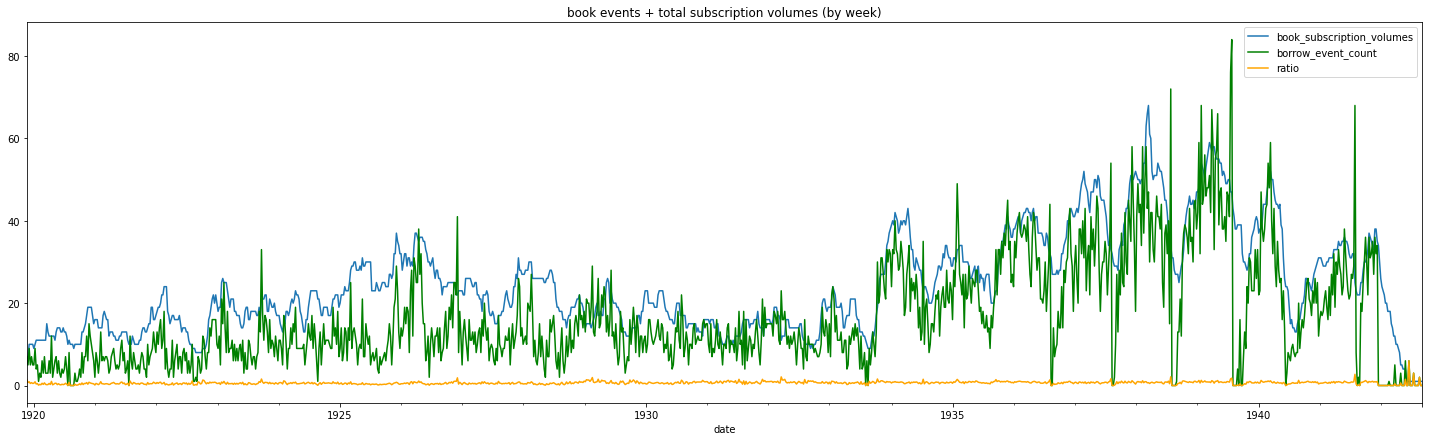

In [142]:

# get current axis so we can plot two series on the same axis
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='book_subscription_volumes',ax=ax, figsize=(25,7), title='book events + total subscription volumes (by week)')
borrowing_weekly.plot(kind='line',x='date',y='borrow_event_count', color='green', ax=ax)
borrowing_weekly.plot(kind='line',x='date',y='ratio', color='orange', ax=ax)


plt.show()


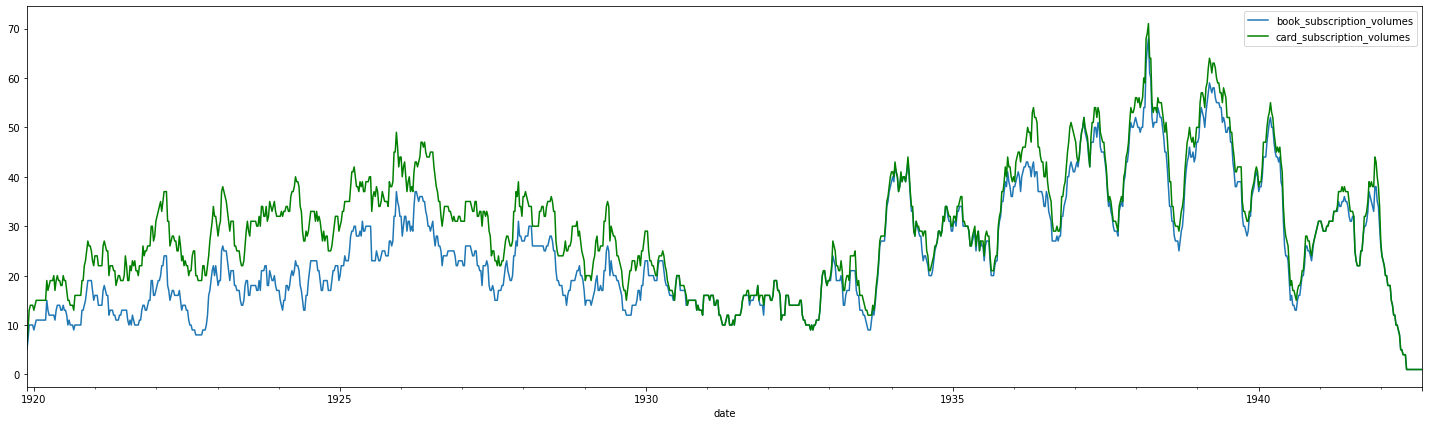

In [143]:
# how different are card volumes and book subscription volumes?

ax = plt.gca()
borrowing_weekly.plot(kind='line',x='date',y='book_subscription_volumes',ax=ax, figsize=(25,7))
borrowing_weekly.plot(kind='line',x='date',y='card_subscription_volumes', color='green', ax=ax)

plt.show()

In [144]:
# let's try aggregating by month
# borrowing_monthly = borrowing_df.groupby([pd.Grouper(key='date', freq='MS')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum'})
# borrowing_monthly = borrowing_monthly.reset_index()
# borrowing_monthly

# borrowing_monthly = borrowing_daily.groupby([pd.Grouper(key='date', freq='MS')]).agg({'book_subscription_volumes':'mean','borrow_event_count': 'sum'})

borrowing_monthly = borrowing_daily.groupby([pd.Grouper(key='date', freq='MS')]).agg({'book_subscription_volumes':'max','borrow_event_count': 'sum'})
borrowing_monthly = borrowing_monthly.reset_index()
borrowing_monthly


date  book_subscription_volumes  borrow_event_count
0   1919-11-01                        7.0                  12
1   1919-12-01                       10.0                  30
2   1920-01-01                       11.0                  20
3   1920-02-01                       11.0                  14
4   1920-03-01                       15.0                  18
..         ...                        ...                 ...
270 1942-05-01                        5.0                   6
271 1942-06-01                        1.0                   6
272 1942-07-01                        1.0                   3
273 1942-08-01                        1.0                   2
274 1942-09-01                        1.0                   0

[275 rows x 3 columns]

In [145]:
borrowing_monthly.borrow_event_count.describe()

count    275.000000
mean      71.360000
std       50.290302
min        0.000000
25%       38.500000
50%       53.000000
75%       99.500000
max      251.000000
Name: borrow_event_count, dtype: float64

In [146]:
borrowing_monthly['ratio'] = borrowing_monthly.apply(lambda row: row.borrow_event_count / row.book_subscription_volumes, axis=1)
borrowing_monthly.ratio.describe()

count    275.000000
mean       2.600836
std        0.985389
min        0.000000
25%        1.935417
50%        2.625000
75%        3.264231
max        6.000000
Name: ratio, dtype: float64

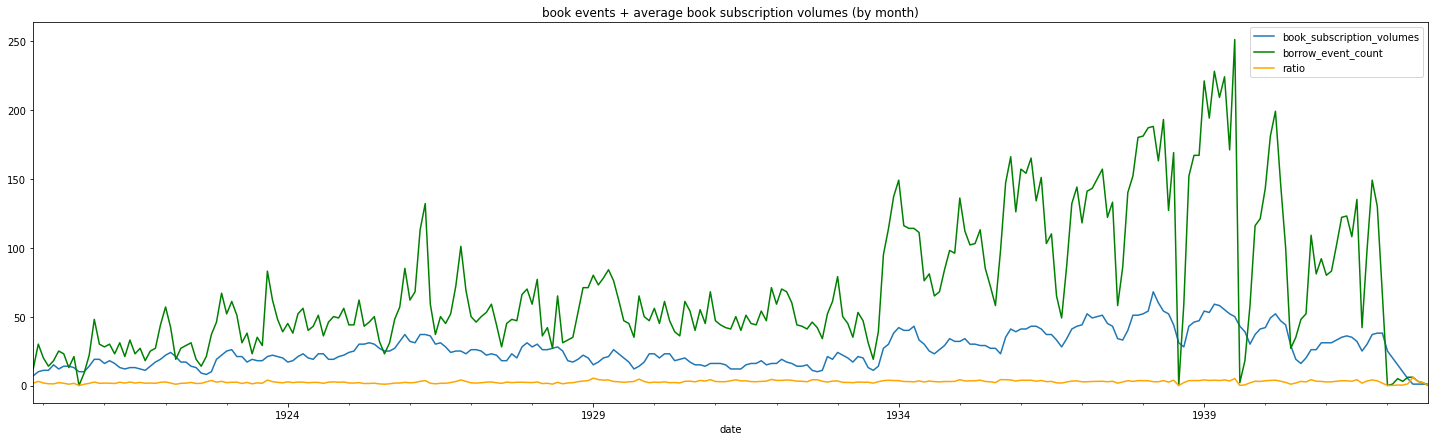

In [147]:
# get current axis so we can plot two series on the same axis
ax = plt.gca()

borrowing_monthly.plot(kind='line',x='date',y='book_subscription_volumes',ax=ax, figsize=(25,7), title='book events + average book subscription volumes (by month)')
borrowing_monthly.plot(kind='line',x='date',y='borrow_event_count', color='green', ax=ax)
borrowing_monthly.plot(kind='line',x='date',y='ratio', color='orange', ax=ax)


plt.show()

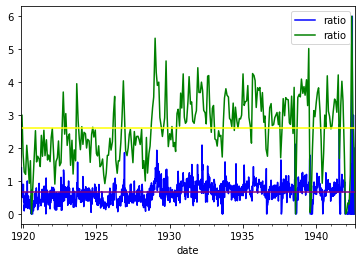

In [148]:
# if we plot just the ratio, how stable is it?
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='ratio', color='blue', ax=ax)
borrowing_monthly.plot(kind='line',x='date',y='ratio', color='green', ax=ax)

# monthly ratio average
#plt.axhline(y=2.858, color='yellow', linestyle='-')  # 2.8 is ratio when we use average subscription
plt.axhline(y=2.6, color='yellow', linestyle='-')  # 2.6 is ratio when we use max # subscriptions


# weekly ratio average
plt.axhline(y=0.663, color='purple', linestyle='-')  # weekly ratio doesn't change noticeably when we switch from mean to max

plt.show()

In [149]:
# ok, now apply our ratio to the non-book subscription volumes
borrowing_weekly['non_book_subs_vols'] = borrowing_weekly.apply(lambda row: row.subscription_volumes - row.book_subscription_volumes, axis=1)
borrowing_weekly.head()

date  book_subscription_volumes  borrow_event_count  \
0 1919-11-23                        5.0                   7   
1 1919-11-30                        7.0                   5   
2 1919-12-07                       10.0                   9   
3 1919-12-14                       10.0                   5   
4 1919-12-21                       10.0                   7   

   card_subscription_volumes  subscription_volumes     ratio  \
0                        6.0                  14.0  1.400000   
1                        9.0                  27.0  0.714286   
2                       13.0                  41.0  0.900000   
3                       14.0                  47.0  0.500000   
4                       14.0                  48.0  0.700000   

   non_book_subs_vols  
0                 9.0  
1                20.0  
2                31.0  
3                37.0  
4                38.0

In [150]:
borrow_events_per_subsvol = borrowing_weekly.ratio.mean()
borrow_events_per_subsvol

0.6428904216675606

In [151]:
# find an example
borrowing_weekly[borrowing_weekly.ratio >= 0.6][borrowing_weekly.ratio <= 0.65]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


date  book_subscription_volumes  borrow_event_count  \
15   1920-03-07                       11.0                   7   
47   1920-10-17                       13.0                   8   
54   1920-12-05                       19.0                  12   
73   1921-04-17                       13.0                   8   
83   1921-06-26                       13.0                   8   
...         ...                        ...                 ...   
1082 1940-08-18                       13.0                   8   
1105 1941-01-26                       29.0                  18   
1108 1941-02-16                       30.0                  19   
1121 1941-05-18                       35.0                  22   
1171 1942-05-03                        5.0                   3   

      card_subscription_volumes  subscription_volumes     ratio  \
15                         15.0                  82.0  0.636364   
47                         19.0                  80.0  0.615385   
54                         26.0                 126.0  0.631579   
73                         22.0                 147.0  0.615385   
83                         20.0                 133.0  0.615385   
...                         ...                   ...       ...   
1082                       15.0                  34.0  0.615385   
1105                       29.0                  83.0  0.620690   
1108                       30.0                  84.0  0.633333   
1121                       38.0                  99.0  0.628571   
1171                        5.0                   6.0  0.600000   

      non_book_subs_vols  
15                  71.0  
47                  67.0  
54                 107.0  
73                 134.0  
83                 120.0  
...                  ...  
1082                21.0  
1105                54.0  
1108                54.0  
1121                64.0  
1171                 1.0  

[81 rows x 7 columns]

In [152]:
borrowing_weekly['estimated_borrow_events'] = borrowing_weekly.non_book_subs_vols.apply(lambda x: x * borrow_events_per_subsvol)
borrowing_weekly

date  book_subscription_volumes  borrow_event_count  \
0    1919-11-23                        5.0                   7   
1    1919-11-30                        7.0                   5   
2    1919-12-07                       10.0                   9   
3    1919-12-14                       10.0                   5   
4    1919-12-21                       10.0                   7   
...         ...                        ...                 ...   
1185 1942-08-09                        1.0                   0   
1186 1942-08-16                        1.0                   0   
1187 1942-08-23                        1.0                   2   
1188 1942-08-30                        1.0                   0   
1189 1942-09-06                        1.0                   0   

      card_subscription_volumes  subscription_volumes     ratio  \
0                           6.0                  14.0  1.400000   
1                           9.0                  27.0  0.714286   
2                          13.0                  41.0  0.900000   
3                          14.0                  47.0  0.500000   
4                          14.0                  48.0  0.700000   
...                         ...                   ...       ...   
1185                        1.0                   1.0  0.000000   
1186                        1.0                   1.0  0.000000   
1187                        1.0                   1.0  2.000000   
1188                        1.0                   1.0  0.000000   
1189                        1.0                   1.0  0.000000   

      non_book_subs_vols  estimated_borrow_events  
0                    9.0                 5.786014  
1                   20.0                12.857808  
2                   31.0                19.929603  
3                   37.0                23.786946  
4                   38.0                24.429836  
...                  ...                      ...  
1185                 0.0                 0.000000  
1186                 0.0                 0.000000  
1187                 0.0                 0.000000  
1188                 0.0                 0.000000  
1189                 0.0                 0.000000  

[1190 rows x 8 columns]

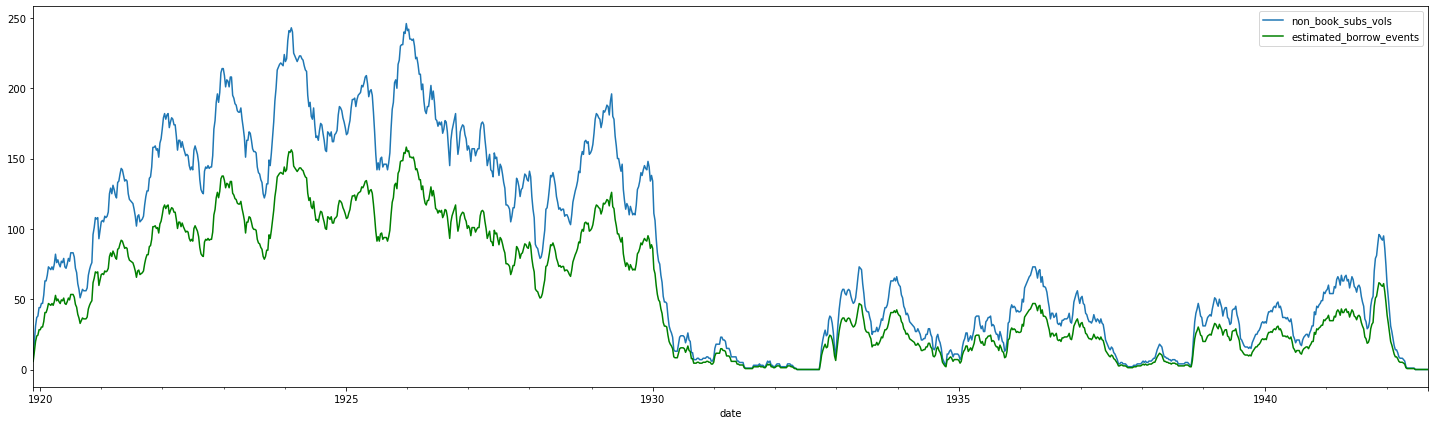

In [153]:
# plot with our estimates
ax = plt.gca()

borrowing_weekly.plot(kind='line',x='date',y='non_book_subs_vols',ax=ax, figsize=(25,7))
borrowing_weekly.plot(kind='line',x='date',y='estimated_borrow_events', color='green', ax=ax)


plt.show()

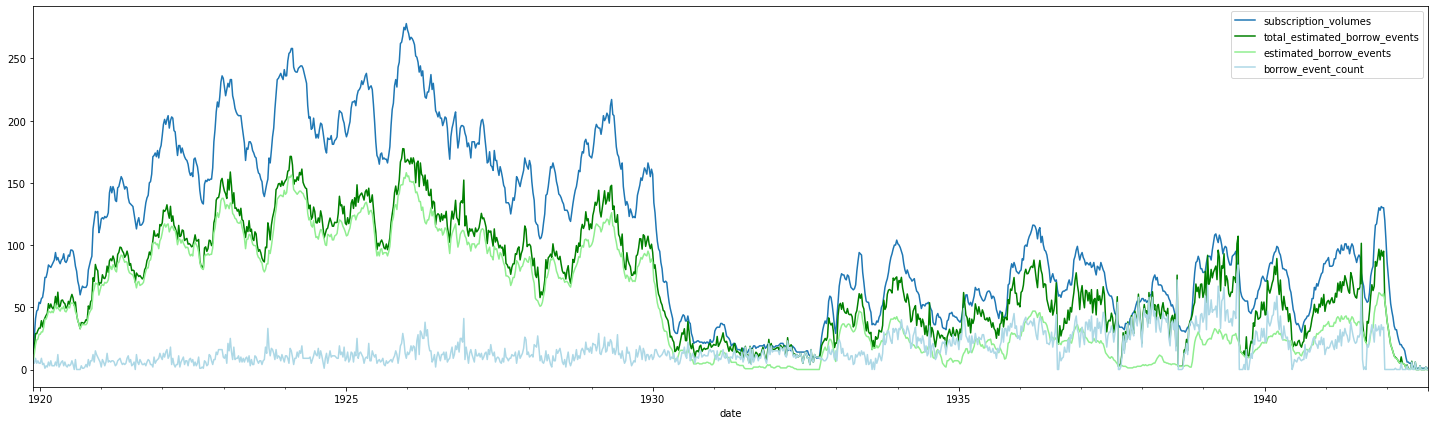

In [154]:
# now combine and plot the total

ax = plt.gca()
# tally up our estimate with the actual event count
borrowing_weekly['total_estimated_borrow_events'] = borrowing_weekly.apply(lambda row: row.estimated_borrow_events + row.borrow_event_count, axis=1)


borrowing_weekly.plot(kind='line',x='date',y='subscription_volumes',ax=ax, figsize=(25,7))
borrowing_weekly.plot(kind='line',x='date',y='total_estimated_borrow_events', color='green', ax=ax)
borrowing_weekly.plot(kind='line',x='date',y='estimated_borrow_events', color='lightgreen', ax=ax)
borrowing_weekly.plot(kind='line',x='date',y='borrow_event_count', color='lightblue', ax=ax)


plt.show()

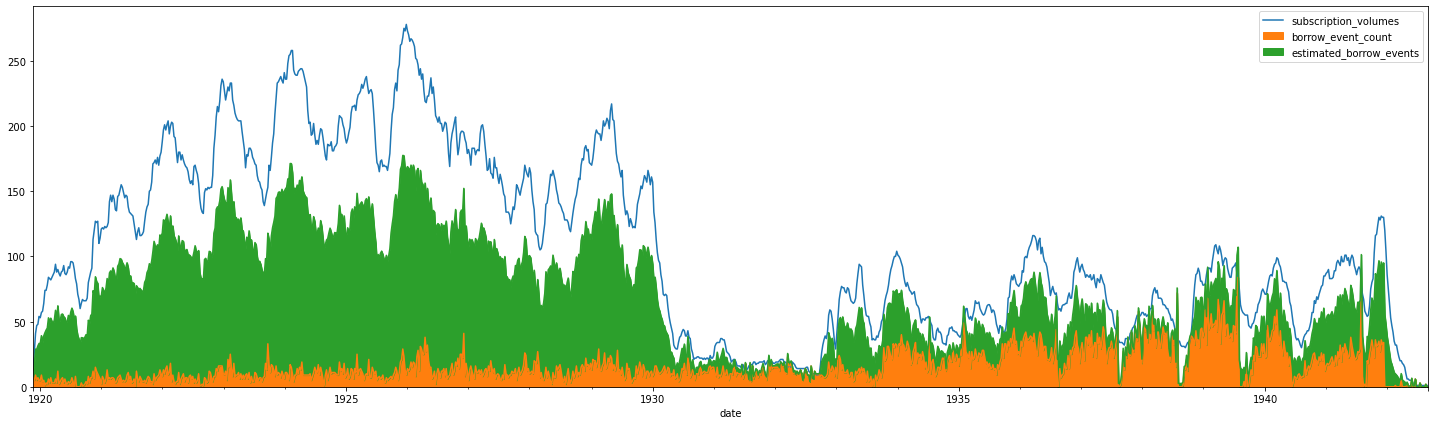

In [155]:
ax = plt.gca()
# total subscriptoin volumes
borrowing_weekly.plot(kind='line',x='date',y='subscription_volumes',ax=ax, figsize=(25,7))
# stacked area chart of actual borrows and estimated missing 
borrowing_weekly[['date', 'borrow_event_count', 'estimated_borrow_events']].plot.area(x='date', stacked=True, ax=ax)
# line plot the total over the stack (not really helpful)
# borrowing_weekly.plot(kind='line',x='date',y='total_estimated_borrow_events', color='yellow', ax=ax)




In [156]:
# how about some numbers?

# total number of estimated missing borrow events based on known subscriptions
est_total_missing_borrows = borrowing_weekly.estimated_borrow_events.sum()
est_total_missing_borrows

63330.49254804972

In [157]:
# how many borrow events did we use to generate our estimate? 
total_borrows_used_to_estimate =  borrows_within_subscriptions.shape[0]
total_borrows_used_to_estimate

17292

In [158]:
all_borrows = events_df[events_df.event_type == 'Borrow']
all_borrows

event_type start_date    end_date  \
2         Borrow       1922  1922-08-23   
8         Borrow       1923  1923-11-07   
12        Borrow       1924  1924-10-22   
13        Borrow       1924  1924-10-22   
22        Borrow       1926  1926-01-14   
...          ...        ...         ...   
35457     Borrow        NaN         NaN   
35460     Borrow        NaN         NaN   
35463     Borrow        NaN         NaN   
35464     Borrow        NaN         NaN   
35485     Borrow        NaN         NaN   

                                             member_uris  \
2      https://shakespeareandco.princeton.edu/members...   
8      https://shakespeareandco.princeton.edu/members...   
12     https://shakespeareandco.princeton.edu/members...   
13     https://shakespeareandco.princeton.edu/members...   
22     https://shakespeareandco.princeton.edu/members...   
...                                                  ...   
35457  https://shakespeareandco.princeton.edu/members...   
35460  https://shakespeareandco.princeton.edu/members...   
35463  https://shakespeareandco.princeton.edu/members...   
35464  https://shakespeareandco.princeton.edu/members...   
35485  https://shakespeareandco.princeton.edu/members...   

                                      member_names  \
2                                         Mr. Rhys   
8             Eyre de Lanux / Mrs. Pierre de Lanux   
12                                     Simone Téry   
13                                     Simone Téry   
22     Ada (Hitchcock) MacLeish;Archibald MacLeish   
...                                            ...   
35457                               Bernard Hommel   
35460                               Bernard Hommel   
35463                               Bernard Hommel   
35464                               Bernard Hommel   
35485                               Bernard Hommel   

                       member_sort_names  subscription_price_paid  \
2                              Rhys, Mr.                      NaN   
8                         de Lanux, Eyre                      NaN   
12                          Téry, Simone                      NaN   
13                          Téry, Simone                      NaN   
22     MacLeish, Ada;MacLeish, Archibald                      NaN   
...                                  ...                      ...   
35457                    Hommel, Bernard                      NaN   
35460                    Hommel, Bernard                      NaN   
35463                    Hommel, Bernard                      NaN   
35464                    Hommel, Bernard                      NaN   
35485                    Hommel, Bernard                      NaN   

       subscription_deposit subscription_duration  subscription_duration_days  \
2                       NaN                   NaN                         NaN   
8                       NaN                   NaN                         NaN   
12                      NaN                   NaN                         NaN   
13                      NaN                   NaN                         NaN   
22                      NaN                   NaN                         NaN   
...                     ...                   ...                         ...   
35457                   NaN                   NaN                         NaN   
35460                   NaN                   NaN                         NaN   
35463                   NaN                   NaN                         NaN   
35464                   NaN                   NaN                         NaN   
35485                   NaN                   NaN                         NaN   

       ...  item_year                                         item_notes  \
2      ...     1902.0                                                NaN   
8      ...     1919.0                                                NaN   
12     ...        NaN                   Unidentified. By or about Joyce.   
13     ...   

In [159]:
all_borrows['year'] = all_borrows.start_date.apply(lambda x: x.split('-')[0] if pd.notna(x) else None)
all_borrows.year.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array(['1922', '1923', '1924', '1926', '1929', '1931', '1934', '1936',
       '1937', '1938', '1940', '1942', '1944', '1946', '1948', '1952',
       '1955', '1956', '1960', '1920', '1921', '1927', '1928', '1932',
       '1935', None, '1939', '1943', '1945', '1947', '1954', '1961', '',
       '1919', '1925', '1930', '1933', '1941', '1949', '1950', '1951',
       '1953', '1957', '1958', '1962'], dtype=object)

In [160]:
official_borrows = all_borrows[all_borrows.year < "1942"]
official_borrows

event_type  start_date    end_date  \
2         Borrow        1922  1922-08-23   
8         Borrow        1923  1923-11-07   
12        Borrow        1924  1924-10-22   
13        Borrow        1924  1924-10-22   
22        Borrow        1926  1926-01-14   
...          ...         ...         ...   
29452     Borrow  1941-12-12         NaN   
29458     Borrow  1941-12-12  1942-03-14   
29459     Borrow  1941-12-12  1942-10-06   
29460     Borrow  1941-12-12  1942-10-06   
29461     Borrow  1941-12-13  1942-05-26   

                                             member_uris  \
2      https://shakespeareandco.princeton.edu/members...   
8      https://shakespeareandco.princeton.edu/members...   
12     https://shakespeareandco.princeton.edu/members...   
13     https://shakespeareandco.princeton.edu/members...   
22     https://shakespeareandco.princeton.edu/members...   
...                                                  ...   
29452  https://shakespeareandco.princeton.edu/members...   
29458  https://shakespeareandco.princeton.edu/members...   
29459  https://shakespeareandco.princeton.edu/members...   
29460  https://shakespeareandco.princeton.edu/members...   
29461  https://shakespeareandco.princeton.edu/members...   

                                      member_names  \
2                                         Mr. Rhys   
8             Eyre de Lanux / Mrs. Pierre de Lanux   
12                                     Simone Téry   
13                                     Simone Téry   
22     Ada (Hitchcock) MacLeish;Archibald MacLeish   
...                                            ...   
29452                              Martine Lacorne   
29458                             Madeleine Blaess   
29459                              François Valéry   
29460                              François Valéry   
29461                           Marie Boscq / Bosq   

                       member_sort_names  subscription_price_paid  \
2                              Rhys, Mr.                      NaN   
8                         de Lanux, Eyre                      NaN   
12                          Téry, Simone                      NaN   
13                          Téry, Simone                      NaN   
22     MacLeish, Ada;MacLeish, Archibald                      NaN   
...                                  ...                      ...   
29452                   Lacorne, Martine                      NaN   
29458                  Blaess, Madeleine                      NaN   
29459                   Valéry, François                      NaN   
29460                   Valéry, François                      NaN   
29461                       Boscq, Marie                      NaN   

       subscription_deposit subscription_duration  subscription_duration_days  \
2                       NaN                   NaN                         NaN   
8                       NaN                   NaN                         NaN   
12                      NaN                   NaN                         NaN   
13                      NaN                   NaN                         NaN   
22                      NaN                   NaN                         NaN   
...                     ...                   ...                         ...   
29452                   NaN                   NaN                         NaN   
29458                   NaN                   NaN                         NaN   
29459                   NaN                   NaN                         NaN   
29460                   NaN                   NaN                         NaN   
29461                   NaN                   NaN                         NaN   

       ...                                         item_notes  \
2      ...                                                NaN   
8      ...                                                NaN   
12     ...                   Unidentified. By or about Joyce.   
13     ...                                   

In [161]:
# how many borrows do we have total? (with/without dates)
# (todo: exclude after last subscription ?)
# members_added = members_added[members_added['date'] < datetime(1942, 1, 1)]

total_borrows = events_df[events_df.event_type == 'Borrow'].shape[0]
total_borrows 

21059

In [162]:
total_official_borrows = official_borrows.shape[0]
total_official_borrows

20597

In [163]:
total_borrows - total_official_borrows

462

In [164]:
total_official_borrows / total_borrows

0.9780616363550027

In [165]:
# what about other book activity?
book_events = events_df[events_df.item_uri.notna()]
total_book_events = book_events.shape[0]
total_book_events

22484

In [166]:
total_official_borrows / total_book_events

0.9160736523750223

In [167]:
total_official_borrows - total_borrows_used_to_estimate  

3305

In [168]:
# estimated total based on subscriptions
est_total = est_total_missing_borrows + total_borrows_used_to_estimate
est_total

80622.49254804972

In [169]:
total_official_borrows / est_total


0.2554746119728873

In [170]:
# how hard to report by decade? 